<a href="https://colab.research.google.com/github/mahault/Drone-governance/blob/main/Drone_governance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Organized code:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import os
import time

##############################################################################
# CORE DRONE MODEL CLASSES
##############################################################################

In [2]:
# class DroneModel:
#     """
#     Physical drone model that simulates position, orientation, and movement
#     based on motor inputs.
#     """
#     def __init__(self):
#         # Drone physical parameters
#         self.mass = 1.0  # kg
#         self.gravity = 9.81  # m/s^2
#         self.I = np.array([0.01, 0.01, 0.02])  # Inertia moments (kg*m^2)
#         self.arm_length = 0.2  # m

#         # State variables
#         self.position = np.zeros(3)  # [x, y, z] in m
#         self.velocity = np.zeros(3)  # [vx, vy, vz] in m/s
#         self.orientation = np.zeros(3)  # [roll, pitch, yaw] in radians
#         self.angular_velocity = np.zeros(3)  # [wx, wy, wz] in rad/s

#         # Control inputs (normalized between 0 and 1)
#         self.motor_speeds = np.array([0.0, 0.0, 0.0, 0.0])

#         # Simulation parameters
#         self.dt = 0.01  # time step for integration

#         # Motor constants
#         self.thrust_coefficient = 5.0  # N/unit
#         self.torque_coefficient = 0.05  # Nm/unit

#         # History for plotting
#         self.history = {
#             'position': [self.position.copy()],
#             'orientation': [self.orientation.copy()],
#             'time': [0.0]
#         }
#         self.current_time = 0.0

#     def update(self, motor_speeds, authorized=True):
#         """Update drone state based on motor inputs."""
#         # If not authorized, zero out the motor speeds to prevent movement
#         if not authorized:
#             print(f"Not authorized! Zeroing motors from {motor_speeds} to zeros")
#             motor_speeds = np.zeros_like(motor_speeds)

#         self.motor_speeds = np.clip(motor_speeds, 0.0, 1.0)

#         # Calculate total thrust and torques
#         thrust = self.thrust_coefficient * np.sum(self.motor_speeds)

#         # Torque calculations remain unchanged
#         roll_torque = self.arm_length * self.thrust_coefficient * (
#             self.motor_speeds[1] + self.motor_speeds[2] -
#             self.motor_speeds[0] - self.motor_speeds[3]
#         )

#         pitch_torque = self.arm_length * self.thrust_coefficient * (
#             self.motor_speeds[0] + self.motor_speeds[1] -
#             self.motor_speeds[2] - self.motor_speeds[3]
#         )

#         yaw_torque = self.torque_coefficient * (
#             -self.motor_speeds[0] + self.motor_speeds[1] -
#             self.motor_speeds[2] + self.motor_speeds[3]
#         )

#         torques = np.array([roll_torque, pitch_torque, yaw_torque])

#         # Calculate acceleration using a simplified but effective approach
#         # Extract orientation angles
#         roll = self.orientation[0]
#         pitch = self.orientation[1]
#         yaw = self.orientation[2]

#         # Calculate sines and cosines
#         cos_roll, sin_roll = np.cos(roll), np.sin(roll)
#         cos_pitch, sin_pitch = np.cos(pitch), np.sin(pitch)
#         cos_yaw, sin_yaw = np.cos(yaw), np.sin(yaw)

#         # Compute force components directly
#         # For simplicity, assume:
#         # - Positive pitch -> Forward (positive X)
#         # - Positive roll -> Right (positive Y)
#         # - Thrust always acts against gravity (primarily in Z)

#         # Force components
#         force_x = thrust * sin_pitch  # Forward/backward (positive pitch -> forward)
#         force_y = thrust * -sin_roll * cos_pitch  # Left/right (positive roll -> right)
#         force_z = thrust * cos_roll * cos_pitch  # Up/down

#         # Apply rotation around yaw axis
#         force_global = np.array([
#             force_x * cos_yaw - force_y * sin_yaw,
#             force_x * sin_yaw + force_y * cos_yaw,
#             force_z
#         ])

#         # Acceleration = Force/mass + gravity
#         acceleration = force_global / self.mass
#         acceleration[2] -= self.gravity  # Gravity acts in negative z

#         # The rest of the method remains unchanged
#         self.velocity += acceleration * self.dt
#         self.position += self.velocity * self.dt

#         # Prevent drone from going underground
#         if self.position[2] < 0:
#             self.position[2] = 0
#             self.velocity[2] = 0

#         # Update angular velocity and orientation
#         angular_acceleration = torques / self.I
#         self.angular_velocity += angular_acceleration * self.dt
#         self.orientation += self.angular_velocity * self.dt

#         # Normalize angles to [-pi, pi]
#         self.orientation = np.mod(self.orientation + np.pi, 2 * np.pi) - np.pi

#         # Update time and history
#         self.current_time += self.dt
#         self.history['position'].append(self.position.copy())
#         self.history['orientation'].append(self.orientation.copy())
#         self.history['time'].append(self.current_time)


# class PIDController:
#     """
#     PID controller for stable drone control.
#     """
#     def __init__(self, kp, ki, kd, output_limits=None):
#         self.kp = kp
#         self.ki = ki
#         self.kd = kd
#         self.output_limits = output_limits

#         self.integral = 0
#         self.previous_error = 0
#         self.first_run = True

#     def update(self, error, dt):
#         # Initialize previous error on first run
#         if self.first_run:
#             self.previous_error = error
#             self.first_run = False

#         # Proportional term
#         p_term = self.kp * error

#         # Integral term
#         self.integral += error * dt
#         i_term = self.ki * self.integral

#         # Derivative term
#         d_term = self.kd * (error - self.previous_error) / dt
#         self.previous_error = error

#         # Calculate output
#         output = p_term + i_term + d_term

#         # Apply limits if specified
#         if self.output_limits is not None:
#             output = np.clip(output, *self.output_limits)

#         return output


# class DroneController:
#     """
#     Basic drone controller using PIDs for position and orientation control.
#     """
#     def __init__(self, drone_model):
#         self.drone = drone_model

#         # PID controllers for position
#         self.pid_x = PIDController(1.0, 0.1, 0.8, output_limits=(-0.4, 0.4))
#         self.pid_y = PIDController(1.0, 0.1, 0.8, output_limits=(-0.4, 0.4))
#         self.pid_z = PIDController(2.0, 0.1, 1.0, output_limits=(-1.0, 1.0))

#         # PID controllers for angles
#         self.pid_roll = PIDController(5.0, 0.0, 2.0, output_limits=(-0.5, 0.5))
#         self.pid_pitch = PIDController(5.0, 0.0, 2.0, output_limits=(-0.5, 0.5))
#         self.pid_yaw = PIDController(3.0, 0.0, 1.0, output_limits=(-0.3, 0.3))

#         # Target positions and orientations
#         self.target_position = np.zeros(3)
#         self.target_yaw = 0.0

#     def set_target(self, position, yaw=0.0):
#         """Set target position and yaw orientation."""
#         self.target_position = np.array(position)
#         self.target_yaw = yaw

#     def update(self):
#         """Calculate control inputs based on current state and targets."""
#         # Position errors
#         pos_error = self.target_position - self.drone.position

#         # Desired roll and pitch based on position error
#         desired_pitch = self.pid_x.update(pos_error[0], self.drone.dt)
#         desired_roll = -self.pid_y.update(pos_error[1], self.drone.dt)  # Negative for correct mapping

#         # Altitude control
#         z_thrust = 0.5 + self.pid_z.update(pos_error[2], self.drone.dt)  # Base thrust plus correction

#         # Angle errors
#         roll_error = desired_roll - self.drone.orientation[0]
#         pitch_error = desired_pitch - self.drone.orientation[1]
#         yaw_error = self.target_yaw - self.drone.orientation[2]

#         # Normalize yaw error to [-pi, pi]
#         yaw_error = np.mod(yaw_error + np.pi, 2 * np.pi) - np.pi

#         # Calculate torque corrections
#         roll_correction = self.pid_roll.update(roll_error, self.drone.dt)
#         pitch_correction = self.pid_pitch.update(pitch_error, self.drone.dt)
#         yaw_correction = self.pid_yaw.update(yaw_error, self.drone.dt)

#         # Calculate motor speeds
#         # For a quadcopter in X configuration:
#         # m0: front-right, m1: front-left, m2: back-left, m3: back-right
#         m0 = z_thrust - roll_correction + pitch_correction - yaw_correction
#         m1 = z_thrust + roll_correction + pitch_correction + yaw_correction
#         m2 = z_thrust + roll_correction - pitch_correction - yaw_correction
#         m3 = z_thrust - roll_correction - pitch_correction + yaw_correction

#         # Ensure motor values are within limits
#         motor_speeds = np.clip(np.array([m0, m1, m2, m3]), 0.0, 1.0)

#         return motor_speeds

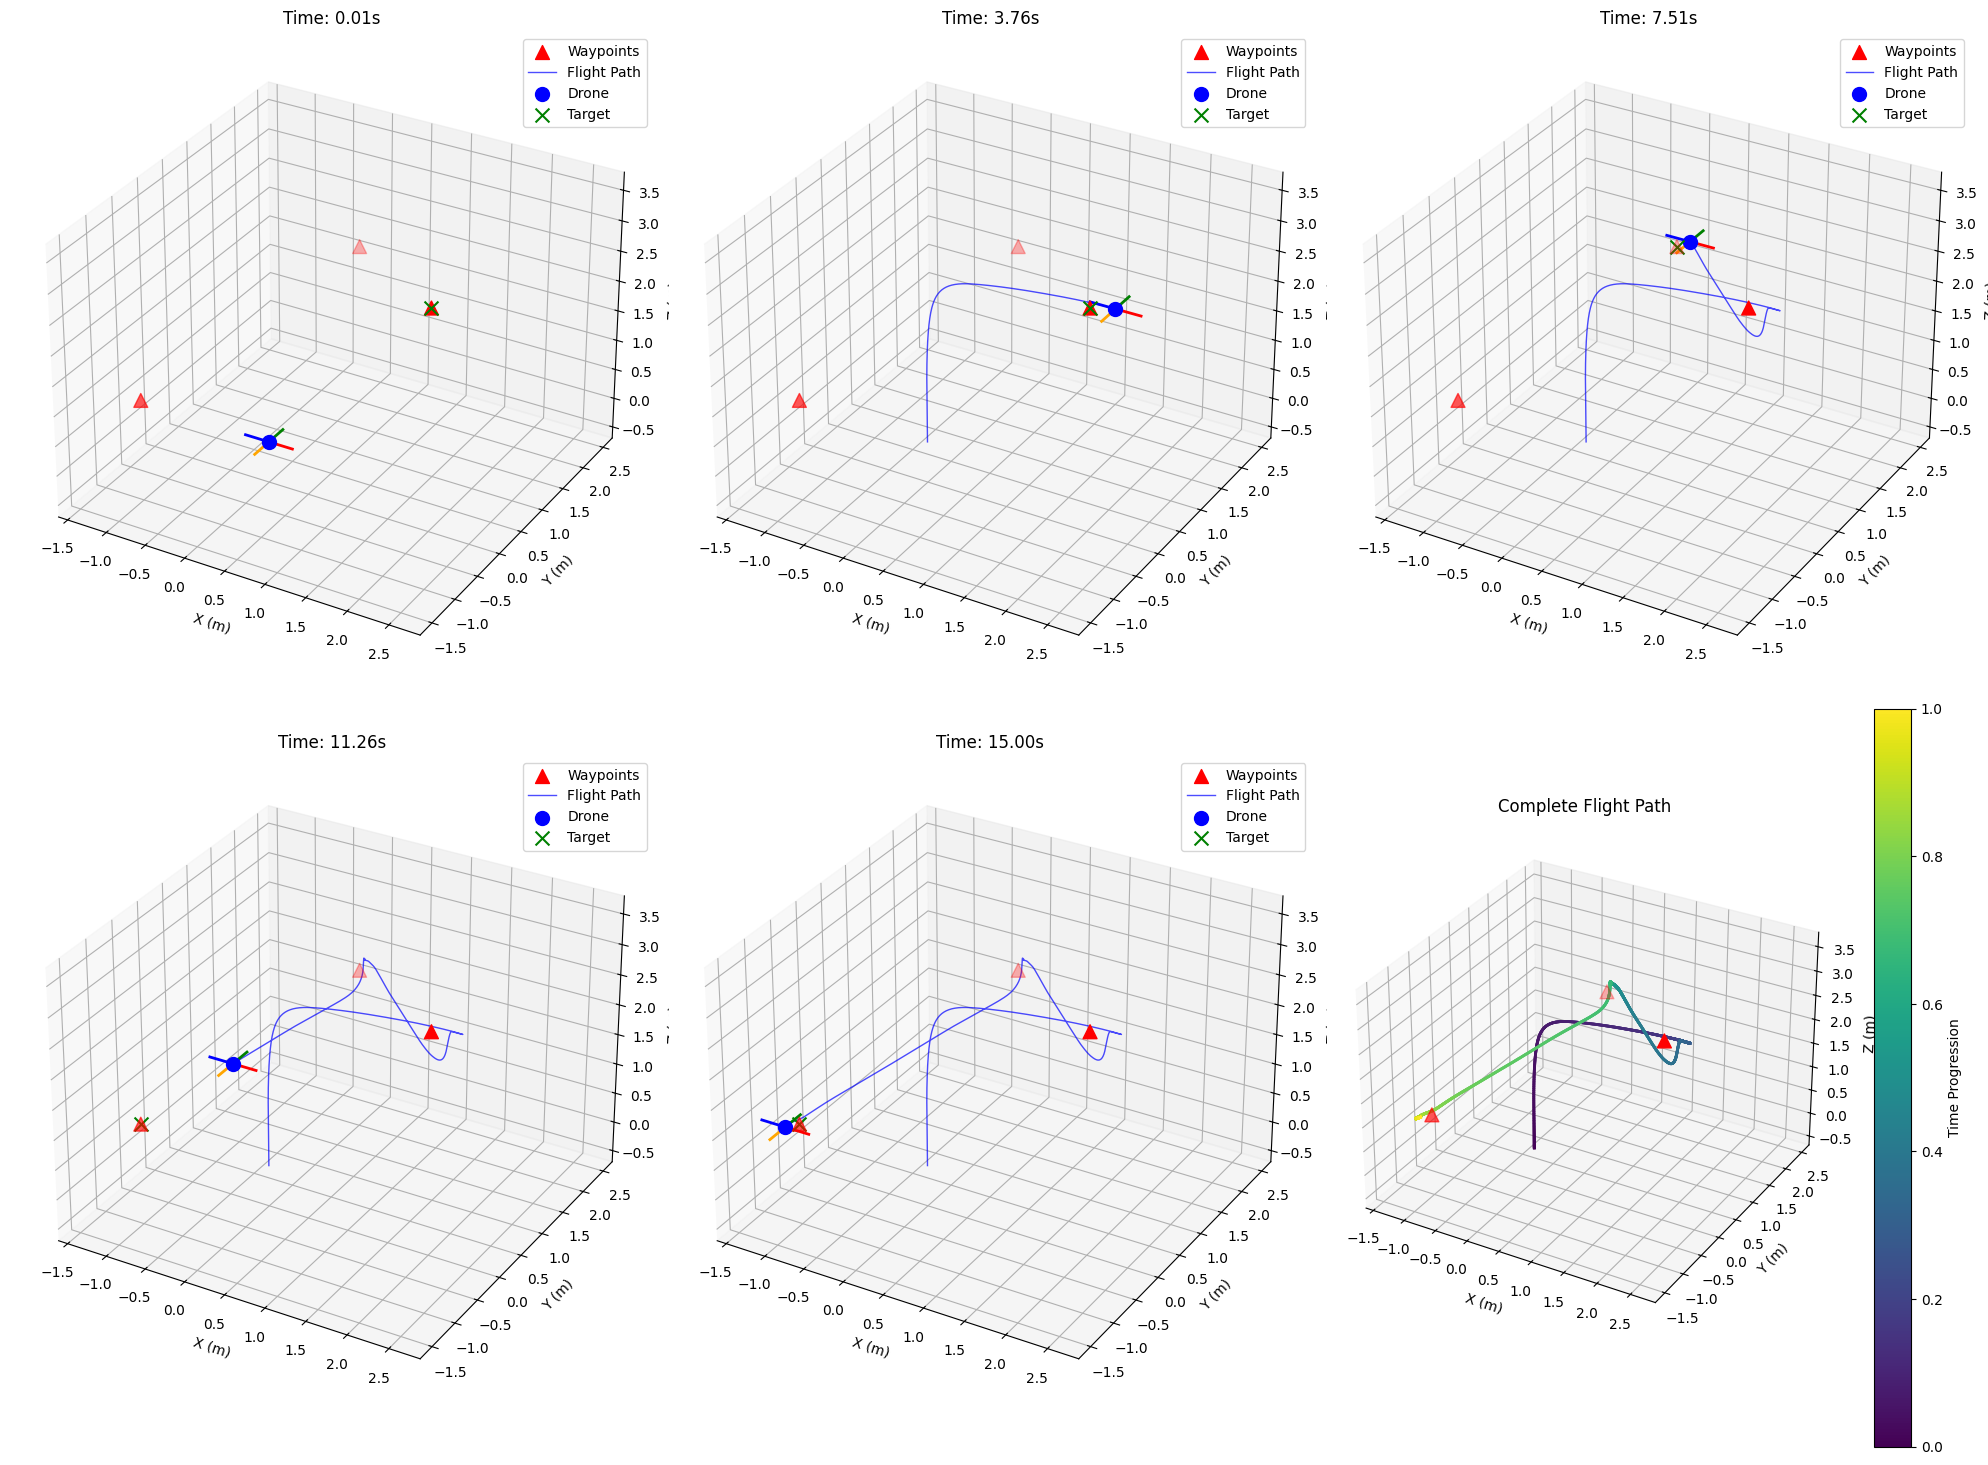

{'positions': array([[ 0.00000000e+00,  0.00000000e+00,  1.01900000e-03],
        [ 0.00000000e+00,  0.00000000e+00,  3.05700000e-03],
        [ 0.00000000e+00,  0.00000000e+00,  6.11400000e-03],
        ...,
        [-1.06813031e+00, -1.17533822e+00,  1.04389558e+00],
        [-1.06741886e+00, -1.17515056e+00,  1.04452689e+00],
        [-1.06672067e+00, -1.17497918e+00,  1.04516626e+00]]),
 'orientations': array([[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.02064435, -0.0082781 ,  0.02311573],
        [ 0.01614432, -0.01378089,  0.02364197],
        [ 0.0216443 , -0.00928368,  0.02417356]]),
 'target_history': array([[ 2.,  0.,  3.],
        [ 2.,  0.,  3.],
        [ 2.,  0.,  3.],
        ...,
        [-1., -1.,  1.],
        [-1., -1.,  1.],
        [-1., -1.,  1.]]),
 'time_history': array([1.000e-02, 2.000e-02, 3.000e-02, ..., 1.498e+01, 1.499e+01,
        1.500e

In [3]:
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython.display import HTML, display
# import matplotlib.animation as animation
# from mpl_toolkits.mplot3d import Axes3D
# import io
# import base64
# from matplotlib import rc

# def simulate_drone_to_waypoints_colab():
#     """Simulate the drone flying to three different waypoints with Colab compatibility."""

#     # Create drone and controller
#     drone = DroneModel()
#     controller = DroneController(drone)

#     # Define three waypoints
#     waypoints = [
#         [2.0, 0.0, 3.0],    # Forward and up
#         [0.0, 2.0, 2.0],    # Right and slightly down
#         [-1.0, -1.0, 1.0]   # Back left and down
#     ]

#     # Duration to spend at each waypoint (seconds)
#     waypoint_time = 5.0

#     # Total simulation time
#     total_time = 3 * waypoint_time

#     # Calculate steps
#     dt = drone.dt
#     total_steps = int(total_time / dt)
#     steps_per_waypoint = int(waypoint_time / dt)

#     # Arrays to store history
#     positions = []
#     orientations = []
#     target_history = []
#     time_history = []

#     # Start at origin
#     drone.position = np.array([0.0, 0.0, 0.0])

#     # Run simulation loop
#     current_waypoint = 0
#     for step in range(total_steps):
#         # Update target waypoint if needed
#         if step % steps_per_waypoint == 0 and current_waypoint < len(waypoints):
#             controller.set_target(waypoints[current_waypoint])
#             current_waypoint = min(current_waypoint + 1, len(waypoints) - 1)

#         # Calculate control inputs
#         motor_speeds = controller.update()

#         # Update drone state
#         drone.update(motor_speeds)

#         # Store history
#         positions.append(drone.position.copy())
#         orientations.append(drone.orientation.copy())
#         target_history.append(controller.target_position.copy())
#         time_history.append(drone.current_time)

#     # Convert to numpy arrays for easier indexing
#     positions = np.array(positions)
#     orientations = np.array(orientations)
#     target_history = np.array(target_history)
#     time_history = np.array(time_history)

#     # Create several static visualizations at different time points
#     timesteps = [0, int(total_steps/4), int(total_steps/2), int(3*total_steps/4), total_steps-1]

#     # Create a figure with subplots
#     fig = plt.figure(figsize=(20, 15))

#     for i, ts in enumerate(timesteps[:5]):  # Limit to first 5 timesteps
#         # Create subplot
#         ax = fig.add_subplot(2, 3, i+1, projection='3d')

#         # Set labels and title
#         ax.set_xlabel('X (m)')
#         ax.set_ylabel('Y (m)')
#         ax.set_zlabel('Z (m)')
#         ax.set_title(f'Time: {time_history[ts]:.2f}s')

#         # Plot waypoints
#         waypoints_array = np.array(waypoints)
#         ax.scatter(waypoints_array[:, 0], waypoints_array[:, 1], waypoints_array[:, 2],
#                   c='red', marker='^', s=100, label='Waypoints')

#         # Plot flight path up to current timestep
#         ax.plot(positions[:ts, 0], positions[:ts, 1], positions[:ts, 2],
#                 'b-', linewidth=1, alpha=0.7, label='Flight Path')

#         # Plot drone position
#         drone_pos = positions[ts]
#         ax.scatter([drone_pos[0]], [drone_pos[1]], [drone_pos[2]],
#                   c='blue', marker='o', s=100, label='Drone')

#         # Plot target
#         target = target_history[ts]
#         ax.scatter([target[0]], [target[1]], [target[2]],
#                   c='green', marker='x', s=100, label='Target')

#         # Drone visualization with arms (simplified)
#         arm_length = 0.3
#         arm_colors = ['red', 'green', 'blue', 'orange']

#         # Create simplified drone arms
#         for j in range(4):
#             angle = j * np.pi/2
#             arm_x = drone_pos[0] + arm_length * np.cos(angle)
#             arm_y = drone_pos[1] + arm_length * np.sin(angle)
#             arm_z = drone_pos[2]

#             ax.plot([drone_pos[0], arm_x], [drone_pos[1], arm_y], [drone_pos[2], arm_z],
#                     color=arm_colors[j], linewidth=2)

#         # Set equal aspect ratio
#         max_range = np.array([
#             positions[:, 0].max() - positions[:, 0].min(),
#             positions[:, 1].max() - positions[:, 1].min(),
#             positions[:, 2].max() - positions[:, 2].min()
#         ]).max() / 2.0 + 0.5  # Add margin

#         mid_x = (positions[:, 0].max() + positions[:, 0].min()) * 0.5
#         mid_y = (positions[:, 1].max() + positions[:, 1].min()) * 0.5
#         mid_z = (positions[:, 2].max() + positions[:, 2].min()) * 0.5

#         ax.set_xlim(mid_x - max_range, mid_x + max_range)
#         ax.set_ylim(mid_y - max_range, mid_y + max_range)
#         ax.set_zlim(mid_z - max_range, mid_z + max_range)

#         # Add legend
#         ax.legend()

#     # Add a full trajectory plot
#     ax = fig.add_subplot(2, 3, 6, projection='3d')
#     ax.set_xlabel('X (m)')
#     ax.set_ylabel('Y (m)')
#     ax.set_zlabel('Z (m)')
#     ax.set_title('Complete Flight Path')

#     # Plot waypoints
#     ax.scatter(waypoints_array[:, 0], waypoints_array[:, 1], waypoints_array[:, 2],
#               c='red', marker='^', s=100, label='Waypoints')

#     # Plot complete flight path with color gradient to show time
#     cmap = plt.get_cmap('viridis')
#     for i in range(1, len(positions)):
#         progress = i / len(positions)
#         ax.plot(positions[i-1:i+1, 0], positions[i-1:i+1, 1], positions[i-1:i+1, 2],
#                 color=cmap(progress), linewidth=2)

#     # Add colorbar to show time progression
#     sm = plt.cm.ScalarMappable(cmap=cmap)
#     sm.set_array([])
#     plt.colorbar(sm, ax=ax, label='Time Progression')

#     # Set equal aspect ratio
#     ax.set_xlim(mid_x - max_range, mid_x + max_range)
#     ax.set_ylim(mid_y - max_range, mid_y + max_range)
#     ax.set_zlim(mid_z - max_range, mid_z + max_range)

#     plt.tight_layout()
#     plt.show()

#     # Return the data for use in other visualizations if needed
#     return {
#         'positions': positions,
#         'orientations': orientations,
#         'target_history': target_history,
#         'time_history': time_history,
#         'waypoints': waypoints
#     }

# # Run the simulation
# simulate_drone_to_waypoints_colab()

TESTING AROUND Authorization - TEST SUCCESSFUL

Not authorized! Zeroing motors from [0.  0.  0.  0.5] to zeros
Not authorized! Zeroing motors from [0.  0.  0.  0.5] to zeros
Not authorized! Zeroing motors from [0.  0.  0.  0.5] to zeros
Not authorized! Zeroing motors from [0.  0.  0.  0.5] to zeros
Not authorized! Zeroing motors from [0.  0.  0.  0.5] to zeros
Not authorized! Zeroing motors from [0.  0.  0.  0.5] to zeros
Not authorized! Zeroing motors from [0.  0.  0.  0.5] to zeros
Not authorized! Zeroing motors from [0.  0.  0.  0.5] to zeros
Not authorized! Zeroing motors from [0.  0.  0.  0.5] to zeros
Not authorized! Zeroing motors from [0.  0.  0.  0.5] to zeros
Not authorized! Zeroing motors from [0.         0.         0.         0.55897312] to zeros
Not authorized! Zeroing motors from [0.         0.         0.         0.67769576] to zeros
Not authorized! Zeroing motors from [0.         0.         0.         0.79839221] to zeros
Not authorized! Zeroing motors from [0.         0.         0.         0.92106345] to zeros
Not au

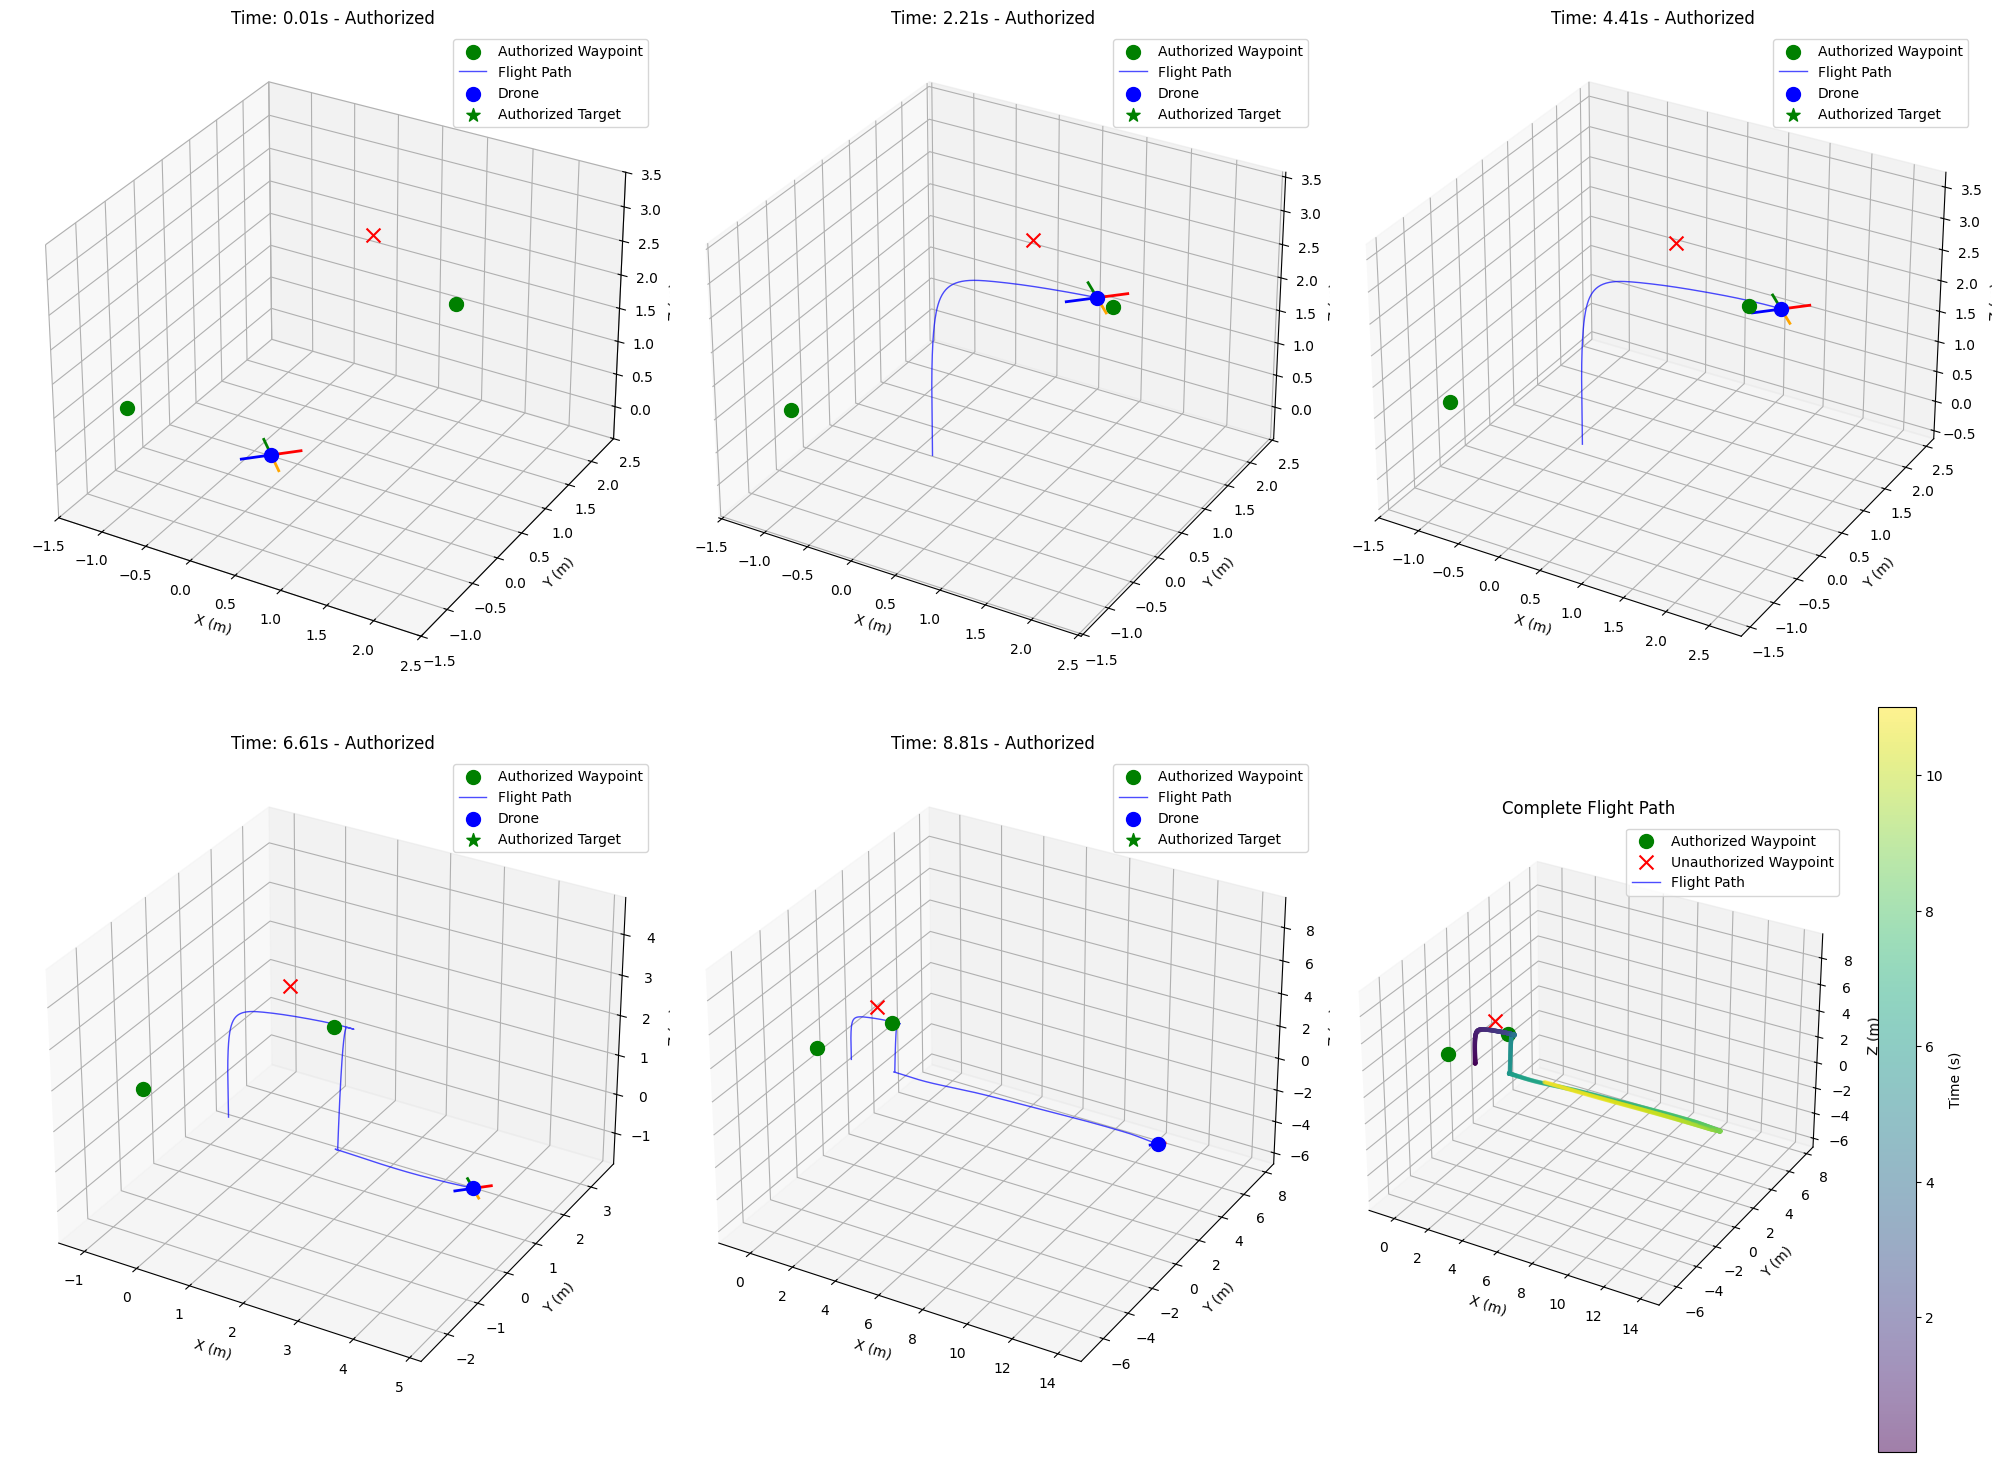

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation


class DroneModel:
    """
    Physical drone model that simulates position, orientation, and movement
    based on motor inputs.
    """
    def __init__(self):
        # Drone physical parameters
        self.mass = 1.0  # kg
        self.gravity = 9.81  # m/s^2
        self.I = np.array([0.01, 0.01, 0.02])  # Inertia moments (kg*m^2)
        self.arm_length = 0.2  # m

        # State variables
        self.position = np.zeros(3)  # [x, y, z] in m
        self.velocity = np.zeros(3)  # [vx, vy, vz] in m/s
        self.orientation = np.zeros(3)  # [roll, pitch, yaw] in radians
        self.angular_velocity = np.zeros(3)  # [wx, wy, wz] in rad/s

        # Control inputs (normalized between 0 and 1)
        self.motor_speeds = np.array([0.0, 0.0, 0.0, 0.0])

        # Simulation parameters
        self.dt = 0.01  # time step for integration

        # Motor constants
        self.thrust_coefficient = 5.0  # N/unit
        self.torque_coefficient = 0.05  # Nm/unit

        # History for plotting
        self.history = {
            'position': [self.position.copy()],
            'orientation': [self.orientation.copy()],
            'time': [0.0]
        }
        self.current_time = 0.0

    def update(self, motor_speeds, authorized=True):
        """Update drone state based on motor inputs."""
        # If not authorized, zero out the motor speeds to prevent movement
        if not authorized:
            print(f"Not authorized! Zeroing motors from {motor_speeds} to zeros")
            motor_speeds = np.zeros_like(motor_speeds)

        self.motor_speeds = np.clip(motor_speeds, 0.0, 1.0)

        # Calculate total thrust and torques
        thrust = self.thrust_coefficient * np.sum(self.motor_speeds)

        # Torque calculations remain unchanged
        roll_torque = self.arm_length * self.thrust_coefficient * (
            self.motor_speeds[1] + self.motor_speeds[2] -
            self.motor_speeds[0] - self.motor_speeds[3]
        )

        pitch_torque = self.arm_length * self.thrust_coefficient * (
            self.motor_speeds[0] + self.motor_speeds[1] -
            self.motor_speeds[2] - self.motor_speeds[3]
        )

        yaw_torque = self.torque_coefficient * (
            -self.motor_speeds[0] + self.motor_speeds[1] -
            self.motor_speeds[2] + self.motor_speeds[3]
        )

        torques = np.array([roll_torque, pitch_torque, yaw_torque])

        # Calculate acceleration using a simplified but effective approach
        # Extract orientation angles
        roll = self.orientation[0]
        pitch = self.orientation[1]
        yaw = self.orientation[2]

        # Calculate sines and cosines
        cos_roll, sin_roll = np.cos(roll), np.sin(roll)
        cos_pitch, sin_pitch = np.cos(pitch), np.sin(pitch)
        cos_yaw, sin_yaw = np.cos(yaw), np.sin(yaw)

        # Compute force components directly
        # For simplicity, assume:
        # - Positive pitch -> Forward (positive X)
        # - Positive roll -> Right (positive Y)
        # - Thrust always acts against gravity (primarily in Z)

        # Force components
        force_x = thrust * sin_pitch  # Forward/backward (positive pitch -> forward)
        force_y = thrust * -sin_roll * cos_pitch  # Left/right (positive roll -> right)
        force_z = thrust * cos_roll * cos_pitch  # Up/down

        # Apply rotation around yaw axis
        force_global = np.array([
            force_x * cos_yaw - force_y * sin_yaw,
            force_x * sin_yaw + force_y * cos_yaw,
            force_z
        ])

        # Acceleration = Force/mass + gravity
        acceleration = force_global / self.mass
        acceleration[2] -= self.gravity  # Gravity acts in negative z

        # The rest of the method remains unchanged
        self.velocity += acceleration * self.dt
        self.position += self.velocity * self.dt

        # Prevent drone from going underground
        if self.position[2] < 0:
            self.position[2] = 0
            self.velocity[2] = 0

        # Update angular velocity and orientation
        angular_acceleration = torques / self.I
        self.angular_velocity += angular_acceleration * self.dt
        self.orientation += self.angular_velocity * self.dt

        # Normalize angles to [-pi, pi]
        self.orientation = np.mod(self.orientation + np.pi, 2 * np.pi) - np.pi

        # Update time and history
        self.current_time += self.dt
        self.history['position'].append(self.position.copy())
        self.history['orientation'].append(self.orientation.copy())
        self.history['time'].append(self.current_time)


class PIDController:
    """
    PID controller for stable drone control.
    """
    def __init__(self, kp, ki, kd, output_limits=None):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.output_limits = output_limits

        self.integral = 0
        self.previous_error = 0
        self.first_run = True

    def update(self, error, dt):
        # Initialize previous error on first run
        if self.first_run:
            self.previous_error = error
            self.first_run = False

        # Proportional term
        p_term = self.kp * error

        # Integral term
        self.integral += error * dt
        i_term = self.ki * self.integral

        # Derivative term
        d_term = self.kd * (error - self.previous_error) / dt
        self.previous_error = error

        # Calculate output
        output = p_term + i_term + d_term

        # Apply limits if specified
        if self.output_limits is not None:
            output = np.clip(output, *self.output_limits)

        return output


class DroneController:
    """
    Basic drone controller using PIDs for position and orientation control.
    """
    def __init__(self, drone_model):
        self.drone = drone_model

        # PID controllers for position
        self.pid_x = PIDController(1.0, 0.1, 0.8, output_limits=(-0.4, 0.4))
        self.pid_y = PIDController(1.0, 0.1, 0.8, output_limits=(-0.4, 0.4))
        self.pid_z = PIDController(2.0, 0.1, 1.0, output_limits=(-1.0, 1.0))

        # PID controllers for angles
        self.pid_roll = PIDController(5.0, 0.0, 2.0, output_limits=(-0.5, 0.5))
        self.pid_pitch = PIDController(5.0, 0.0, 2.0, output_limits=(-0.5, 0.5))
        self.pid_yaw = PIDController(3.0, 0.0, 1.0, output_limits=(-0.3, 0.3))

        # Target positions and orientations
        self.target_position = np.zeros(3)
        self.target_yaw = 0.0

    def set_target(self, position, yaw=0.0):
        """Set target position and yaw orientation."""
        self.target_position = np.array(position)
        self.target_yaw = yaw

    def update(self):
        """Calculate control inputs based on current state and targets."""
        # Position errors
        pos_error = self.target_position - self.drone.position

        # Desired roll and pitch based on position error
        desired_pitch = self.pid_x.update(pos_error[0], self.drone.dt)
        desired_roll = -self.pid_y.update(pos_error[1], self.drone.dt)  # Negative for correct mapping

        # Altitude control
        z_thrust = 0.5 + self.pid_z.update(pos_error[2], self.drone.dt)  # Base thrust plus correction

        # Angle errors
        roll_error = desired_roll - self.drone.orientation[0]
        pitch_error = desired_pitch - self.drone.orientation[1]
        yaw_error = self.target_yaw - self.drone.orientation[2]

        # Normalize yaw error to [-pi, pi]
        yaw_error = np.mod(yaw_error + np.pi, 2 * np.pi) - np.pi

        # Calculate torque corrections
        roll_correction = self.pid_roll.update(roll_error, self.drone.dt)
        pitch_correction = self.pid_pitch.update(pitch_error, self.drone.dt)
        yaw_correction = self.pid_yaw.update(yaw_error, self.drone.dt)

        # Calculate motor speeds
        # For a quadcopter in X configuration:
        # m0: front-right, m1: front-left, m2: back-left, m3: back-right
        m0 = z_thrust - roll_correction + pitch_correction - yaw_correction
        m1 = z_thrust + roll_correction + pitch_correction + yaw_correction
        m2 = z_thrust + roll_correction - pitch_correction - yaw_correction
        m3 = z_thrust - roll_correction - pitch_correction + yaw_correction

        # Ensure motor values are within limits
        motor_speeds = np.clip(np.array([m0, m1, m2, m3]), 0.0, 1.0)

        return motor_speeds


def simulate_drone_with_authorization():
    """
    Simulate the drone flying to authorized waypoints while skipping unauthorized ones.
    """
    # Create drone and controller
    drone = DroneModel()
    controller = DroneController(drone)

    # Define waypoints with authorization status
    # Each waypoint is [x, y, z, authorized]
    waypoints = [
        [2.0, 0.0, 3.0, True],     # Forward and up - Authorized
        [0.0, 2.0, 2.0, False],    # Right and slightly down - Unauthorized
        [-1.0, -1.0, 1.0, True]    # Back left and down - Authorized
    ]

    # Duration to spend at each waypoint (seconds)
    waypoint_time = 5.0

    # How long to wait at unauthorized waypoints before moving to the next one
    unauthorized_wait_time = 1.0  # seconds

    # Total simulation time (adjusted for unauthorized waypoints)
    authorized_count = sum(1 for wp in waypoints if wp[3])
    unauthorized_count = len(waypoints) - authorized_count
    total_time = (authorized_count * waypoint_time) + (unauthorized_count * unauthorized_wait_time)

    # Calculate steps
    dt = drone.dt
    total_steps = int(total_time / dt)
    steps_per_waypoint_authorized = int(waypoint_time / dt)
    steps_per_waypoint_unauthorized = int(unauthorized_wait_time / dt)

    # Arrays to store history
    positions = []
    orientations = []
    target_history = []
    time_history = []
    authorization_history = []  # Track authorization status

    # Start at origin
    drone.position = np.array([0.0, 0.0, 0.0])

    # Run simulation loop
    current_waypoint = 0
    steps_at_current_waypoint = 0

    while len(positions) < total_steps and current_waypoint < len(waypoints):
        # Get current waypoint data
        wp = waypoints[current_waypoint]
        position = wp[:3]
        authorized = wp[3]

        # Set target position
        controller.set_target(position)

        # Determine how long to stay at this waypoint
        steps_to_stay = steps_per_waypoint_authorized if authorized else steps_per_waypoint_unauthorized

        # Stay at waypoint for specified time
        while steps_at_current_waypoint < steps_to_stay:
            # Calculate control inputs
            motor_speeds = controller.update()

            # Update drone state with authorization status
            drone.update(motor_speeds, authorized=authorized)

            # Store history
            positions.append(drone.position.copy())
            orientations.append(drone.orientation.copy())
            target_history.append(np.array(position))
            time_history.append(drone.current_time)
            authorization_history.append(authorized)

            # Increment step counter
            steps_at_current_waypoint += 1

            # Calculate distance to target for visualization purposes only
            distance = np.linalg.norm(drone.position - np.array(position))

        # Move to next waypoint
        current_waypoint += 1
        steps_at_current_waypoint = 0

    # Convert to numpy arrays for easier indexing
    positions = np.array(positions)
    orientations = np.array(orientations)
    target_history = np.array(target_history)
    time_history = np.array(time_history)
    authorization_history = np.array(authorization_history)

    # Create a visualization of the flight path
    visualize_flight_path(
        positions,
        orientations,
        target_history,
        time_history,
        authorization_history,
        waypoints
    )

    # Return the data for use in other visualizations if needed
    return {
        'positions': positions,
        'orientations': orientations,
        'target_history': target_history,
        'time_history': time_history,
        'authorization_history': authorization_history,
        'waypoints': waypoints
    }


def visualize_flight_path(positions, orientations, target_history, time_history, authorization_history, waypoints):
    """Create a visualization of the drone's flight path with waypoint authorization."""

    # Extract waypoint positions
    waypoint_positions = np.array([wp[:3] for wp in waypoints])
    waypoint_authorized = np.array([wp[3] for wp in waypoints])

    # Calculate timesteps for visualization
    total_steps = len(positions)
    timesteps = [
        0,
        int(total_steps/5),
        int(2*total_steps/5),
        int(3*total_steps/5),
        int(4*total_steps/5),
        total_steps-1
    ]

    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 15))

    for i, ts in enumerate(timesteps[:5]):  # First 5 time slices
        # Create subplot
        ax = fig.add_subplot(2, 3, i+1, projection='3d')

        # Plot the flight path
        plot_drone_state(
            ax,
            positions[:ts+1],
            orientations[ts],
            target_history[ts],
            time_history[ts],
            authorization_history[ts],
            waypoint_positions,
            waypoint_authorized
        )

    # Add a full trajectory plot
    ax = fig.add_subplot(2, 3, 6, projection='3d')

    # Plot waypoints
    for i, wp in enumerate(waypoints):
        color = 'green' if wp[3] else 'red'
        marker = 'o' if wp[3] else 'x'
        label = 'Authorized Waypoint' if i == 0 and wp[3] else ('Unauthorized Waypoint' if i == 1 and not wp[3] else None)
        ax.scatter([wp[0]], [wp[1]], [wp[2]], c=color, marker=marker, s=100, label=label)

    # Plot complete flight path with color gradient to show time
    cmap = plt.get_cmap('viridis')
    points = ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2],
                       c=time_history, cmap=cmap, s=5, alpha=0.5)

    # Plot the flight path as a line
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', linewidth=1, alpha=0.7, label='Flight Path')

    # Add colorbar for time
    plt.colorbar(points, ax=ax, label='Time (s)')

    # Set labels and title
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('Complete Flight Path')

    # Set equal aspect ratio
    max_range = calculate_plot_bounds(positions, waypoint_positions)
    center = calculate_plot_center(positions, waypoint_positions)

    ax.set_xlim(center[0] - max_range, center[0] + max_range)
    ax.set_ylim(center[1] - max_range, center[1] + max_range)
    ax.set_zlim(center[2] - max_range, center[2] + max_range)

    # Add legend
    ax.legend()

    plt.tight_layout()
    plt.show()


def plot_drone_state(ax, positions, orientation, target, time, authorized, waypoints, waypoint_authorized):
    """Plot the drone's state at a specific moment in time."""

    # Set labels and title
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')

    # Add authorization status to title
    auth_status = "Authorized" if authorized else "Unauthorized"
    ax.set_title(f'Time: {time:.2f}s - {auth_status}')

    # Plot waypoints based on authorization
    for i, (wp, auth) in enumerate(zip(waypoints, waypoint_authorized)):
        color = 'green' if auth else 'red'
        marker = 'o' if auth else 'x'
        label = 'Authorized Waypoint' if i == 0 and auth else ('Unauthorized Waypoint' if i == 0 and not auth else None)
        ax.scatter([wp[0]], [wp[1]], [wp[2]], c=color, marker=marker, s=100, label=label)

    # Plot flight path so far
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', linewidth=1, alpha=0.7, label='Flight Path')

    # Plot current drone position
    drone_pos = positions[-1]
    ax.scatter([drone_pos[0]], [drone_pos[1]], [drone_pos[2]], c='blue', marker='o', s=100, label='Drone')

    # Plot target
    target_color = 'green' if authorized else 'red'
    ax.scatter([target[0]], [target[1]], [target[2]], c=target_color, marker='*', s=100,
              label=f'{"Authorized" if authorized else "Unauthorized"} Target')

    # Draw drone orientation with colored arms
    draw_drone_arms(ax, drone_pos, orientation)

    # Set equal aspect ratio
    max_range = calculate_plot_bounds(positions, waypoints)
    center = calculate_plot_center(positions, waypoints)

    ax.set_xlim(center[0] - max_range, center[0] + max_range)
    ax.set_ylim(center[1] - max_range, center[1] + max_range)
    ax.set_zlim(center[2] - max_range, center[2] + max_range)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())


def draw_drone_arms(ax, position, orientation):
    """Draw a simplified drone with colored arms to visualize orientation."""
    arm_length = 0.3
    arm_colors = ['red', 'green', 'blue', 'orange']

    # Extract orientation angles
    roll, pitch, yaw = orientation

    # Create simplified drone arms
    for j in range(4):
        # Base angle for each arm (45, 135, 225, 315 degrees)
        angle = (j * np.pi/2) + np.pi/4

        # Apply yaw rotation
        rotated_angle = angle + yaw

        # Calculate arm endpoints
        arm_x = position[0] + arm_length * np.cos(rotated_angle)
        arm_y = position[1] + arm_length * np.sin(rotated_angle)
        arm_z = position[2]

        # Draw the arm
        ax.plot([position[0], arm_x], [position[1], arm_y], [position[2], arm_z],
                color=arm_colors[j], linewidth=2)


def calculate_plot_bounds(positions, waypoints):
    """Calculate bounds for the plot to ensure consistent scaling."""
    all_points = np.vstack([positions, waypoints])

    # Get the range of coordinates
    max_range = np.array([
        all_points[:, 0].max() - all_points[:, 0].min(),
        all_points[:, 1].max() - all_points[:, 1].min(),
        all_points[:, 2].max() - all_points[:, 2].min()
    ]).max() / 2.0 + 0.5  # Add margin

    return max_range


def calculate_plot_center(positions, waypoints):
    """Calculate the center point for the plot."""
    all_points = np.vstack([positions, waypoints])

    # Get the center of coordinates
    center = np.array([
        (all_points[:, 0].max() + all_points[:, 0].min()) * 0.5,
        (all_points[:, 1].max() + all_points[:, 1].min()) * 0.5,
        (all_points[:, 2].max() + all_points[:, 2].min()) * 0.5
    ])

    return center


# Run the simulation with authorization checking
if __name__ == "__main__":
    simulation_data = simulate_drone_with_authorization()

END OF TES AROUND AUTHORIZATION

Analyzing waypoints for authorization status...
Running inference with observations: [np.int64(9), 0, None]
Observation types: [<class 'numpy.int64'>, <class 'int'>, <class 'NoneType'>]
Prior condition belief: [0.9 0.1]
Zone info: Red=False, Emergency=False

--- PyMDP Active Inference Decision at 2025-03-27T20:27:44 ---
Position: Position_10 (State 9)
Context: Green (Prob 1.00/0.00)
Condition: Normal (Prob 0.90/0.10)
Waypoint zone: Green, Normal
Drone physical position: [0, 0, 0]
Target position: [0.0, 0.0, 2.0]
Distance to target: 2.00m

Authorization decision: AUTHORIZED
Reasons: Green context always authorized (Green prob: 1.00)
--------------------------------------------------
  Waypoint 0: AUTHORIZED - [0.0, 0.0, 2.0] - Green/Normal
Running inference with observations: [np.int64(9), 0, None]
Observation types: [<class 'numpy.int64'>, <class 'int'>, <class 'NoneType'>]
Prior condition belief: [0.9 0.1]
Zone info: Red=False, Emergency=False

--- PyMDP Active Inference Decision at 2

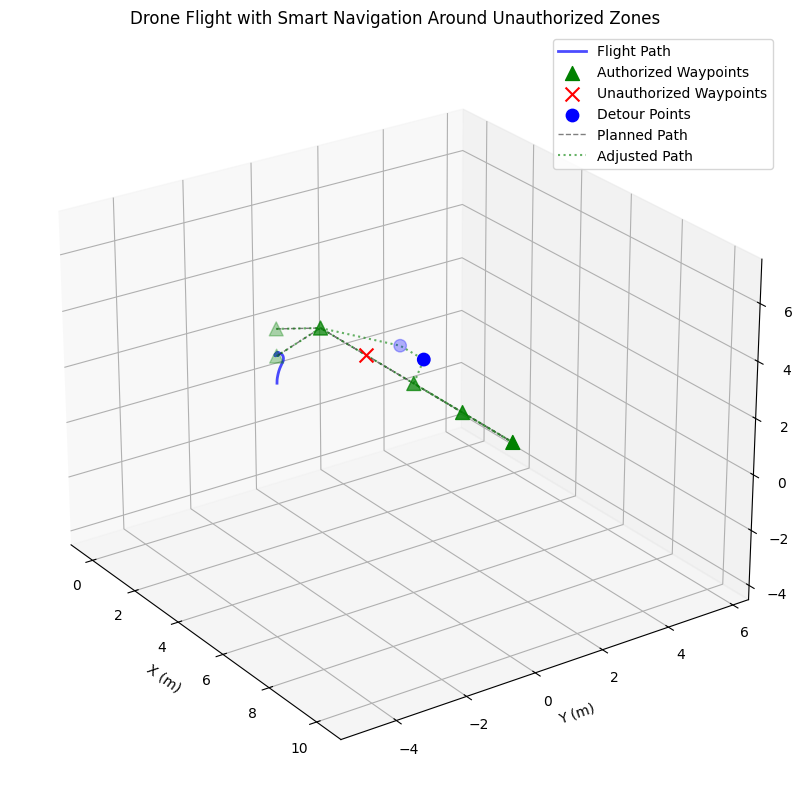

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# def visualize_improved_smart_navigation(simulation_results, show_detours=True):
#     """
#     Improved visualization function for the drone flight path with smart navigation.

#     Parameters:
#     - simulation_results: Dictionary from fly_around_unauthorized_zones
#     - show_detours: Whether to show the detour paths

#     Returns:
#     - fig: The figure object containing the visualization
#     """
#     positions = simulation_results['positions']
#     original_waypoints = simulation_results['full_waypoints']
#     adjusted_waypoints = simulation_results['adjusted_waypoints']
#     unauthorized_indices = simulation_results['unauthorized_indices']
#     authorized_indices = simulation_results['authorized_indices']

#     # Create figure and 3D axis
#     fig = plt.figure(figsize=(14, 10))
#     ax = fig.add_subplot(111, projection='3d')

#     # Plot the flight path
#     ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
#             'b-', linewidth=2, alpha=0.7, label='Flight Path')

#     # Split original waypoints by authorization status
#     auth_waypoints = []
#     unauth_waypoints = []
#     emergency_waypoints = []

#     for i, wp in enumerate(original_waypoints):
#         pos = wp[:3]
#         is_red = wp[3] if len(wp) > 3 else False
#         is_emergency = wp[4] if len(wp) > 4 else False

#         if i in unauthorized_indices:
#             if is_red and is_emergency:
#                 emergency_waypoints.append(pos)
#             else:
#                 unauth_waypoints.append(pos)
#         else:
#             auth_waypoints.append(pos)

#     # Plot authorized waypoints
#     if auth_waypoints:
#         auth_waypoints = np.array(auth_waypoints)
#         ax.scatter(auth_waypoints[:, 0], auth_waypoints[:, 1], auth_waypoints[:, 2],
#                   c='green', marker='^', s=100, label='Authorized Waypoints')

#     # Plot unauthorized waypoints
#     if unauth_waypoints:
#         unauth_waypoints = np.array(unauth_waypoints)
#         ax.scatter(unauth_waypoints[:, 0], unauth_waypoints[:, 1], unauth_waypoints[:, 2],
#                   c='red', marker='x', s=100, label='Unauthorized Waypoints')

#     # Plot emergency waypoints
#     if emergency_waypoints:
#         emergency_waypoints = np.array(emergency_waypoints)
#         ax.scatter(emergency_waypoints[:, 0], emergency_waypoints[:, 1], emergency_waypoints[:, 2],
#                   c='orange', marker='^', s=100, label='Emergency Waypoints')

#     # Plot detour waypoints if requested
#     if show_detours and adjusted_waypoints:
#         # Find which adjusted waypoints are detours (not in original)
#         detour_points = []
#         for awp in adjusted_waypoints:
#             is_detour = True
#             for owp in [wp[:3] for wp in original_waypoints]:
#                 if np.allclose(np.array(awp), np.array(owp), atol=1e-6):
#                     is_detour = False
#                     break
#             if is_detour:
#                 detour_points.append(awp)

#         if detour_points:
#             detour_points = np.array(detour_points)
#             ax.scatter(detour_points[:, 0], detour_points[:, 1], detour_points[:, 2],
#                       c='blue', marker='o', s=80, label='Detour Points')

#     # Create a line connecting the waypoints in sequence to show the intended path
#     all_waypoint_positions = np.array([wp[:3] for wp in original_waypoints])
#     ax.plot(all_waypoint_positions[:, 0], all_waypoint_positions[:, 1], all_waypoint_positions[:, 2],
#             'k--', linewidth=1, alpha=0.5, label='Planned Path')

#     # Also plot the adjusted waypoint path
#     adjusted_positions = np.array(adjusted_waypoints)
#     ax.plot(adjusted_positions[:, 0], adjusted_positions[:, 1], adjusted_positions[:, 2],
#             'g:', linewidth=1.5, alpha=0.6, label='Adjusted Path')

#     # Set labels and title
#     ax.set_xlabel('X (m)')
#     ax.set_ylabel('Y (m)')
#     ax.set_zlabel('Z (m)')
#     ax.set_title('Drone Flight with Smart Navigation Around Unauthorized Zones')

#     # Set view angle for better visualization
#     ax.view_init(elev=25, azim=-35)

#     # Manually set the axis limits to ensure all waypoints are visible
#     # Calculate min and max for each axis from all points (original, adjusted, and flight path)
#     all_points = []
#     all_points.extend([wp[:3] for wp in original_waypoints])
#     all_points.extend(adjusted_waypoints)

#     # Sample the positions array to avoid using too many points
#     sample_rate = max(1, len(positions) // 100)
#     sampled_positions = positions[::sample_rate]
#     all_points.extend(sampled_positions)

#     all_points = np.array(all_points)

#     # Add a margin to the limits
#     margin = 1.0  # 1 meter margin
#     x_min, x_max = all_points[:, 0].min() - margin, all_points[:, 0].max() + margin
#     y_min, y_max = all_points[:, 1].min() - margin, all_points[:, 1].max() + margin
#     z_min, z_max = all_points[:, 2].min() - margin, all_points[:, 2].max() + margin

#     # Ensure the axes have equal scales
#     max_range = max(x_max - x_min, y_max - y_min, z_max - z_min)
#     x_mid = (x_max + x_min) / 2
#     y_mid = (y_max + y_min) / 2
#     z_mid = (z_max + z_min) / 2

#     ax.set_xlim(x_mid - max_range/2, x_mid + max_range/2)
#     ax.set_ylim(y_mid - max_range/2, y_mid + max_range/2)
#     ax.set_zlim(z_mid - max_range/2, z_mid + max_range/2)

#     # Add legend
#     ax.legend(loc='upper right')

#     # Add annotation explaining the detour
#     if unauth_waypoints:
#         text = "Drone navigates around\nunauthorized waypoint"
#         unauth_pos = unauth_waypoints[0]
#         ax.text(unauth_pos[0], unauth_pos[1] + 0.5, unauth_pos[2] + 0.5, text,
#                 fontsize=10, color='red', horizontalalignment='center')

#     plt.tight_layout()
#     return fig


# def test_improved_visualization():
#     """
#     Test function for the improved visualization.
#     """
#     try:
#         # This assumes you have previously run the fly_around_unauthorized_zones function
#         # and have the results stored. If not, you need to run it first.

#         # Create a pattern with explicitly defined zones
#         waypoints = [
#             # Format: [x, y, z, is_red_zone, is_emergency]
#             [0.0, 0.0, 2.0, False, False],      # Take off and hover (green zone, normal)
#             [2.0, 0.0, 3.0, False, False],      # Forward and up (green zone, normal)
#             [4.0, 0.0, 3.0, True, False],       # Red zone, normal condition (should be unauthorized)
#             [6.0, 0.0, 3.0, True, True],        # Red zone, emergency (should be authorized)
#             [8.0, 0.0, 3.0, False, False],      # Green zone again (authorized)
#             [10.0, 0.0, 3.0, False, False],     # Too far (should be unauthorized)
#             [2.0, 0.0, 3.0, False, False],      # Back to green zone
#             [0.0, 0.0, 1.0, False, False]       # Return to start and land
#         ]

#         # Extract just the position coordinates
#         waypoint_positions = [wp[:3] for wp in waypoints]

#         # Use fly_around_unauthorized_zones to get the results
#         # This assumes you have defined this function already
#         results = fly_around_unauthorized_zones(waypoint_positions, waypoints)

#         # Now use the improved visualization
#         fig = visualize_improved_smart_navigation(results)
#         plt.suptitle("Drone Flight with Smart Navigation (Improved Visualization)")
#         plt.show()

#     except Exception as e:
#         print(f"Error in visualization: {e}")


# # If you're missing trajectory data, here's a mock function that creates fake data
# def create_mock_trajectory_data():
#     """Create mock trajectory data for visualization testing."""
#     # Original waypoints
#     waypoints = [
#         # Format: [x, y, z, is_red_zone, is_emergency]
#         [0.0, 0.0, 2.0, False, False],      # Take off and hover (green zone, normal)
#         [2.0, 0.0, 3.0, False, False],      # Forward and up (green zone, normal)
#         [4.0, 0.0, 3.0, True, False],       # Red zone, normal condition (should be unauthorized)
#         [6.0, 0.0, 3.0, True, True],        # Red zone, emergency (should be authorized)
#         [8.0, 0.0, 3.0, False, False],      # Green zone again (authorized)
#         [10.0, 0.0, 3.0, False, False],     # Too far (should be unauthorized)
#         [2.0, 0.0, 3.0, False, False],      # Back to green zone
#         [0.0, 0.0, 1.0, False, False]       # Return to start and land
#     ]

#     # Adjusted waypoints with detour around waypoint 2
#     adjusted_waypoints = [
#         [0.0, 0.0, 2.0],      # Waypoint 0
#         [2.0, 0.0, 3.0],      # Waypoint 1
#         [4.0, 1.0, 3.0],      # Detour 1
#         [5.0, 1.0, 3.0],      # Detour 2
#         [6.0, 0.0, 3.0],      # Waypoint 3
#         [8.0, 0.0, 3.0],      # Waypoint 4
#         [10.0, 0.0, 3.0],     # Waypoint 5
#         [2.0, 0.0, 3.0],      # Waypoint 6
#         [0.0, 0.0, 1.0]       # Waypoint 7
#     ]

#     # Create a mock flight path
#     # First, create a function to interpolate between points
#     def interpolate(p1, p2, steps):
#         return np.array([np.linspace(p1[i], p2[i], steps) for i in range(3)]).T

#     # Generate a continuous path through the adjusted waypoints
#     positions = []
#     steps_between = 50  # Number of steps between each waypoint

#     for i in range(len(adjusted_waypoints) - 1):
#         segment = interpolate(adjusted_waypoints[i], adjusted_waypoints[i+1], steps_between)
#         positions.extend(segment)

#     # Final waypoint
#     positions.append(adjusted_waypoints[-1])

#     # Create mock results dictionary
#     results = {
#         'positions': np.array(positions),
#         'full_waypoints': waypoints,
#         'adjusted_waypoints': adjusted_waypoints,
#         'unauthorized_indices': [2],
#         'authorized_indices': [0, 1, 3, 4, 5, 6, 7],
#         'times': np.linspace(0, 35.57, len(positions))
#     }

#     return results


# # Call either test function depending on what data you have
# if __name__ == "__main__":
#     try:
#         # Try to run with actual simulation data
#         test_improved_visualization()
#     except NameError:
#         # If fly_around_unauthorized_zones is not defined, use mock data
#         print("Using mock trajectory data for visualization...")
#         mock_results = create_mock_trajectory_data()
#         fig = visualize_improved_smart_navigation(mock_results)
#         plt.suptitle("Drone Flight with Smart Navigation (Mock Data)")
#         plt.show()

..................

Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] to zeros
Not authorized! Zeroing motors from [0.5 0.5 0.5 0.5] t

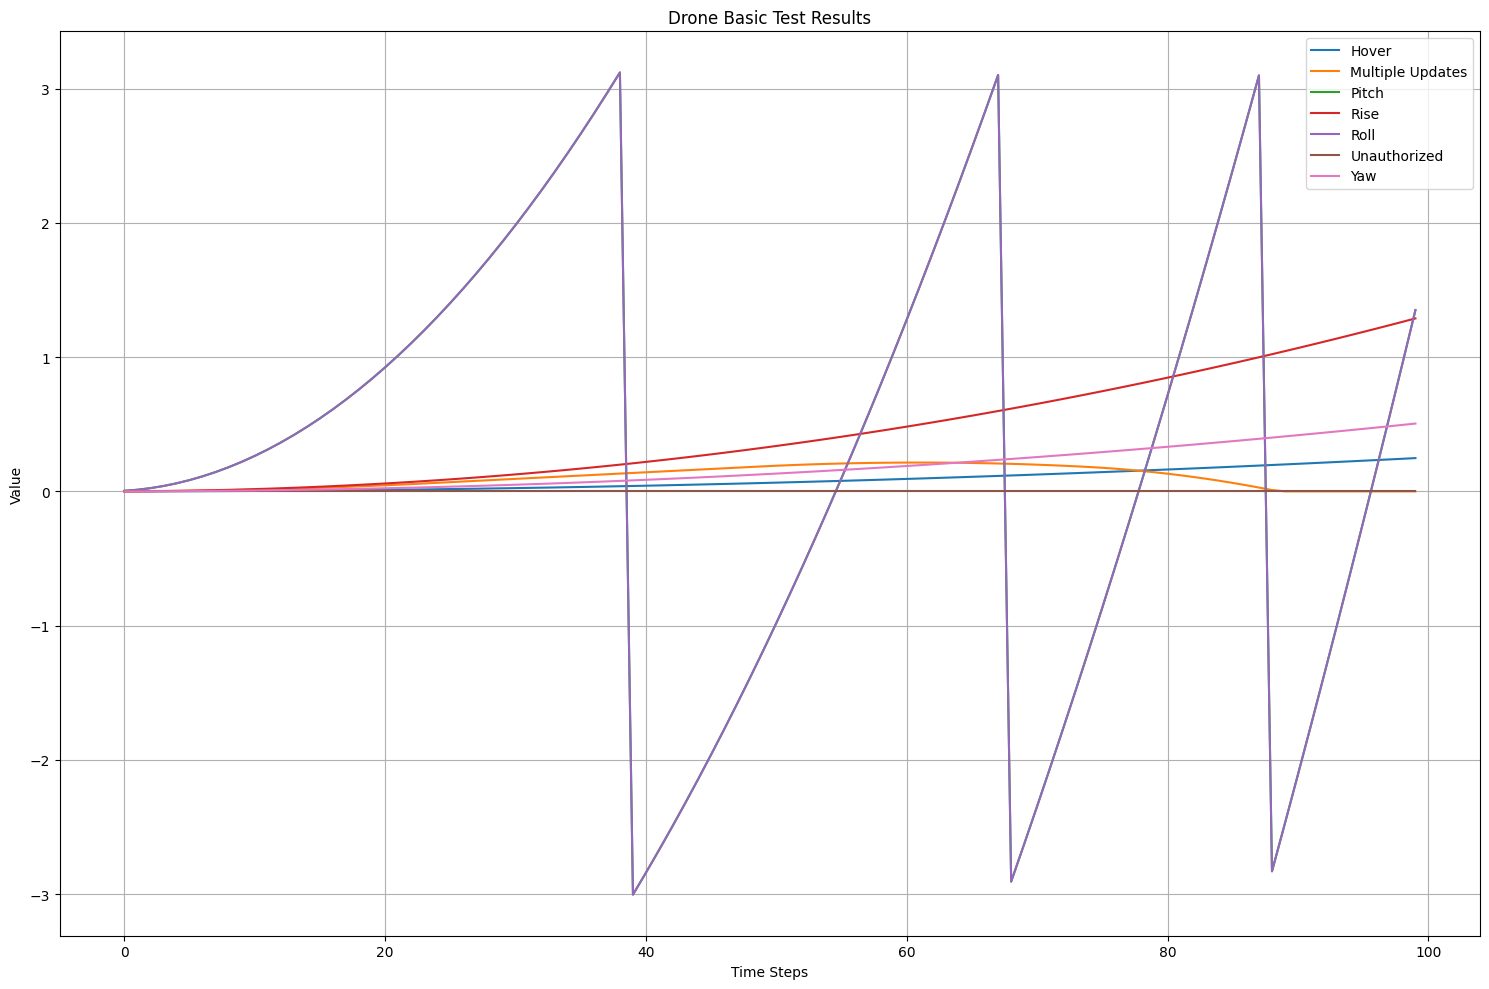

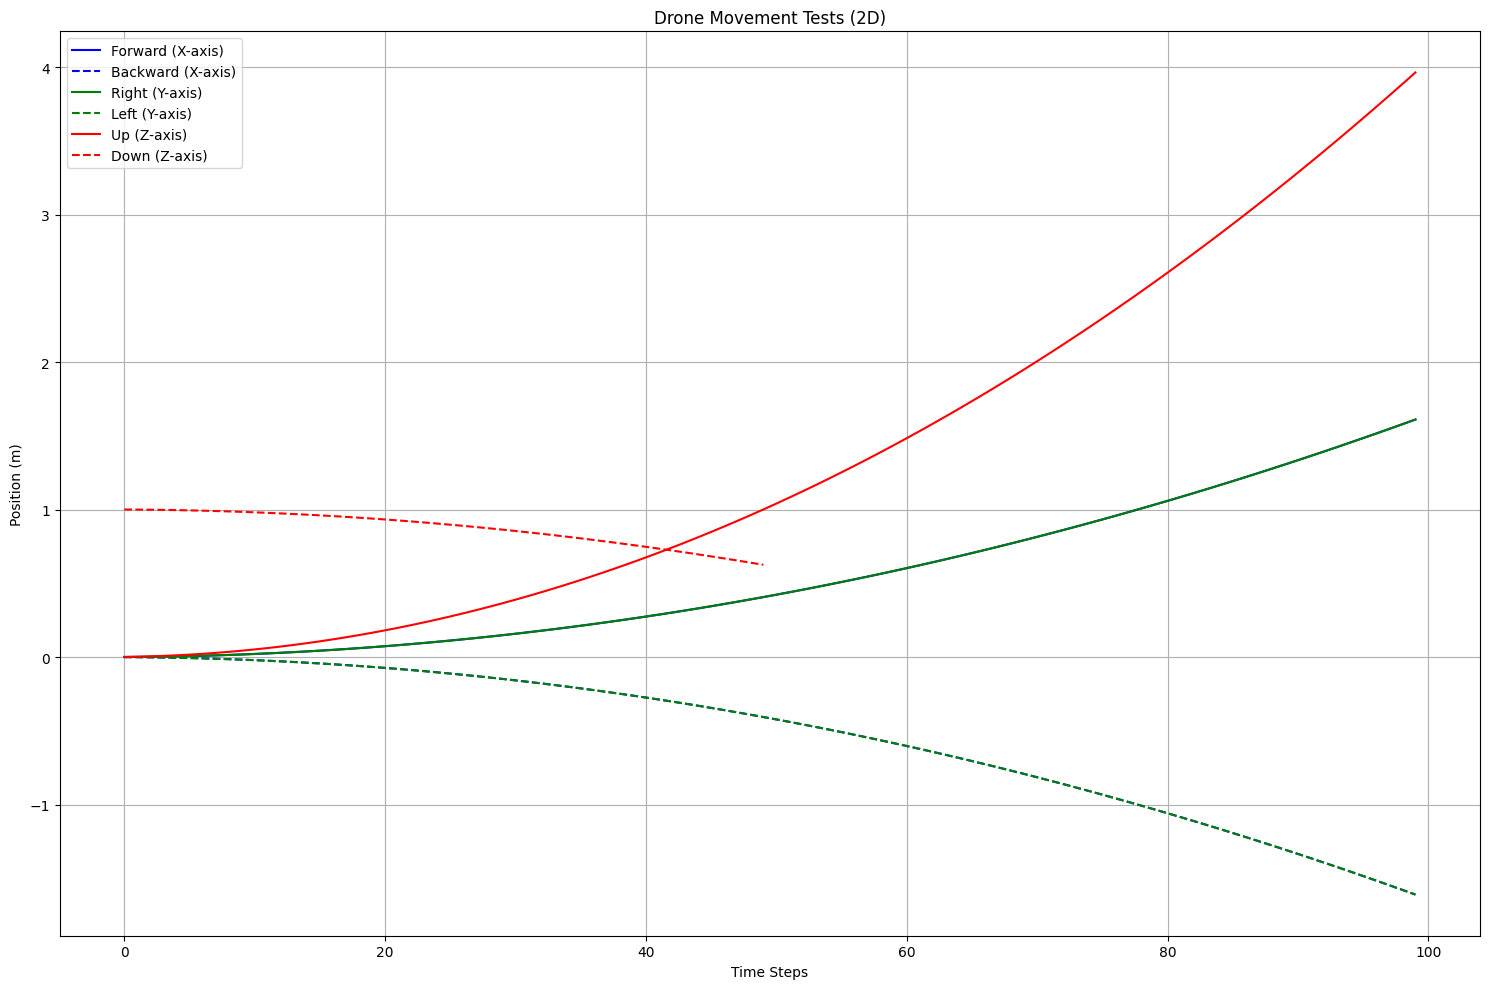

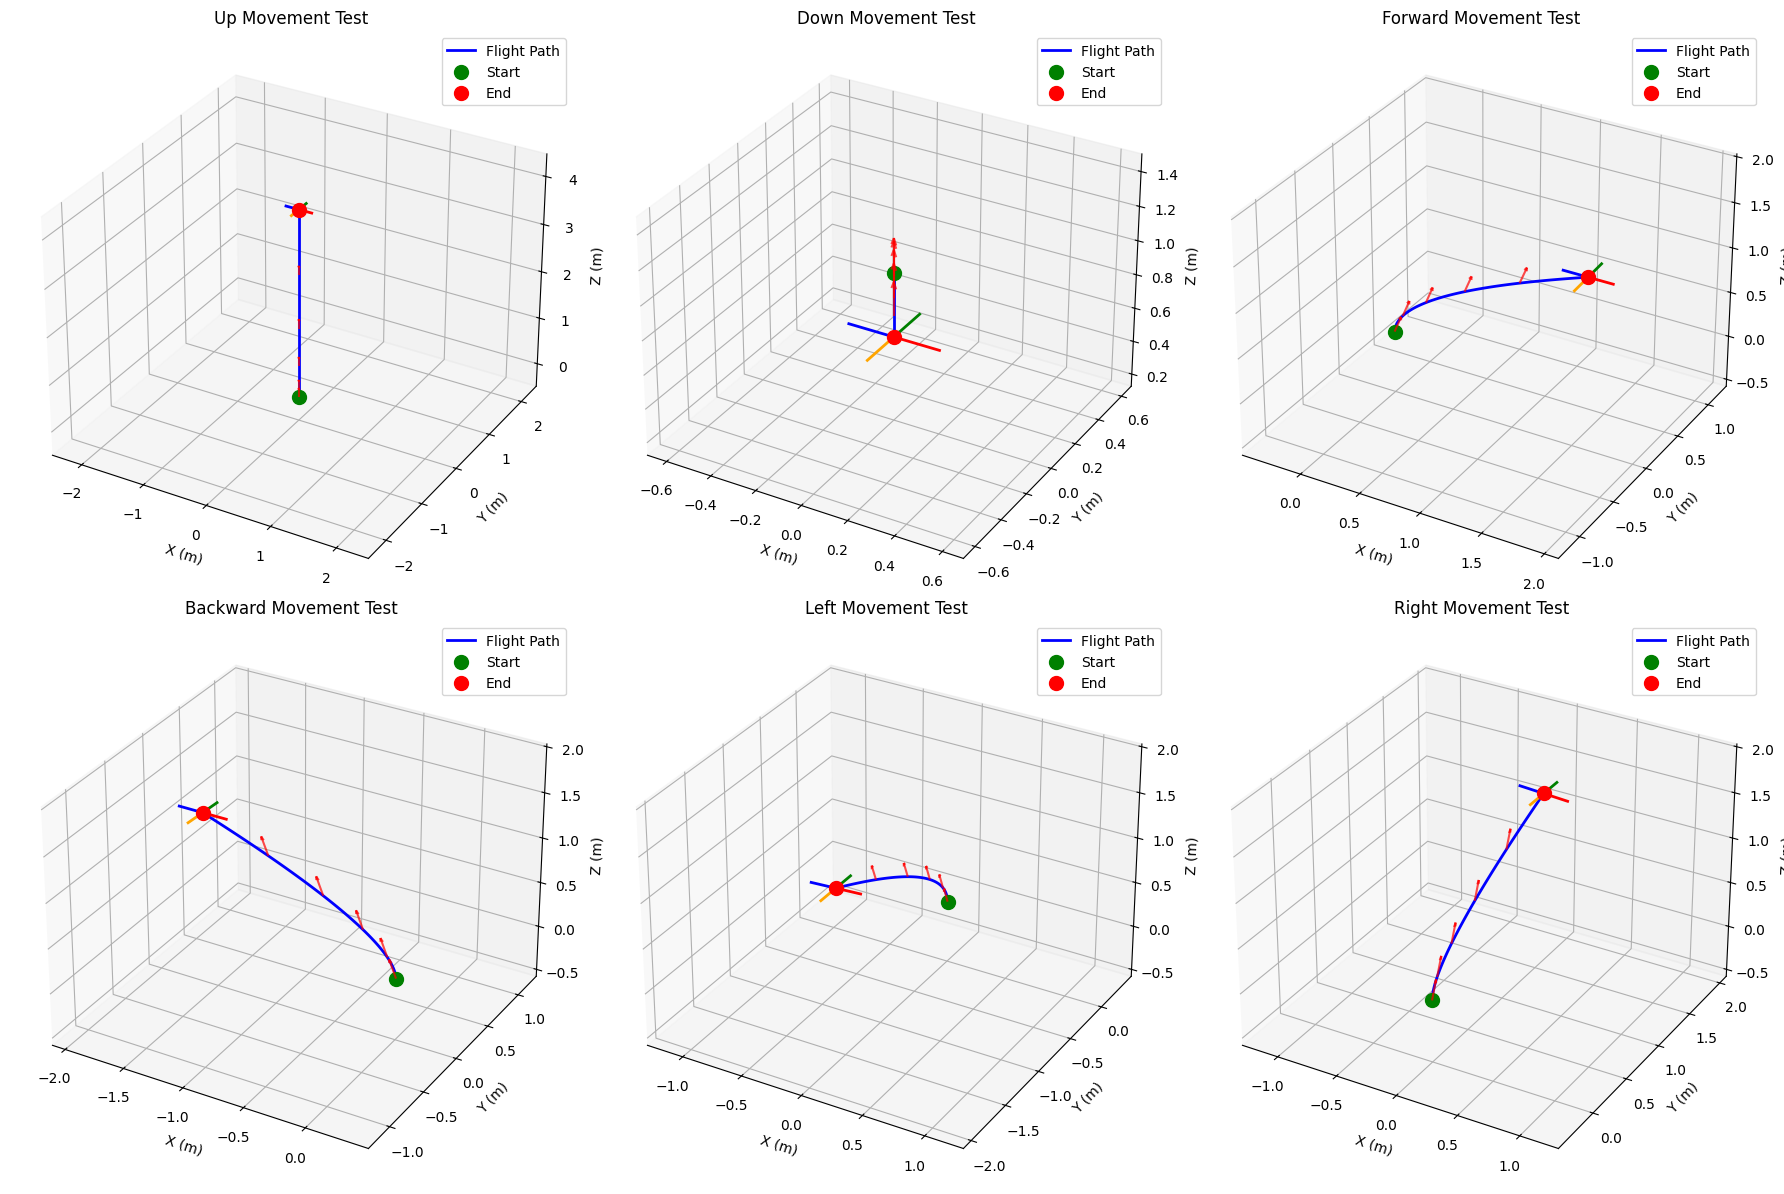

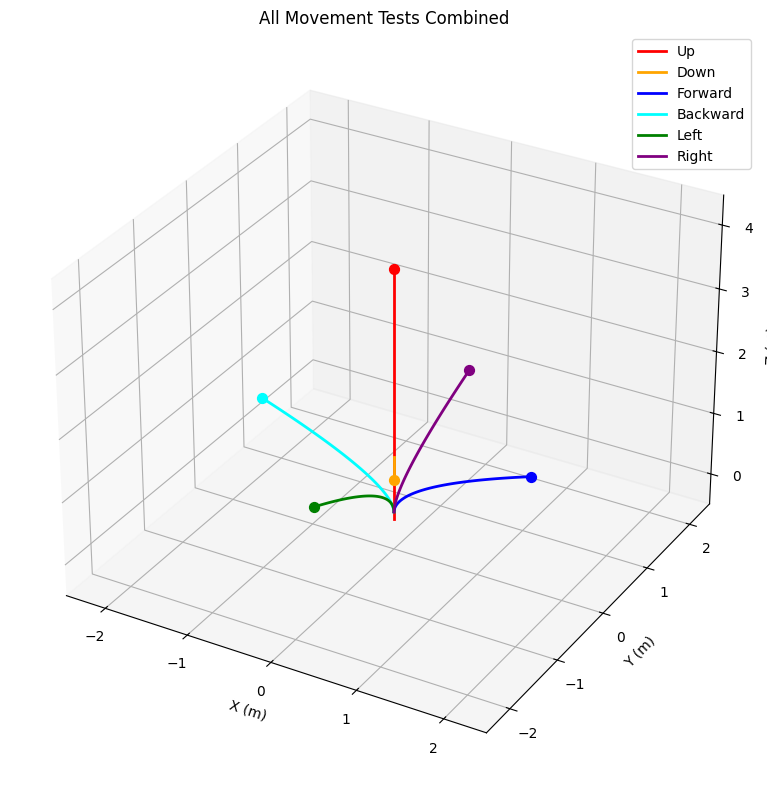

.
----------------------------------------------------------------------
Ran 19 tests in 3.176s

OK


In [7]:
import numpy as np
import unittest
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

class TestDroneModel(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        cls.plot_data = {}

    def setUp(self):
        self.drone = DroneModel()

    def test_initialization(self):
        self.assertEqual(self.drone.mass, 1.0)
        self.assertEqual(self.drone.gravity, 9.81)
        np.testing.assert_array_equal(self.drone.I, np.array([0.01, 0.01, 0.02]))
        self.assertEqual(self.drone.arm_length, 0.2)

    def test_update_with_zero_motors(self):
        self.drone.update(np.zeros(4))
        self.assertEqual(self.drone.position[2], 0)
        self.assertEqual(self.drone.velocity[2], 0)

    def test_ground_collision(self):
        for _ in range(100):
            self.drone.update(np.zeros(4))
        self.assertEqual(self.drone.position[2], 0)
        self.assertEqual(self.drone.velocity[2], 0)

    def test_motor_clipping(self):
        self.drone.update(np.array([-0.5, 0.5, 1.5, 0.7]))
        np.testing.assert_array_equal(self.drone.motor_speeds, [0.0, 0.5, 1.0, 0.7])

    def test_hover(self):
        hover_speed = 1.05 * (self.drone.mass * self.drone.gravity) / (4 * self.drone.thrust_coefficient)
        motor_speeds = np.ones(4) * hover_speed
        positions = []
        for _ in range(100):
            self.drone.update(motor_speeds)
            positions.append(self.drone.position[2])
        self.__class__.plot_data['Hover'] = positions
        # Relax the stability threshold
        stability = np.std(positions[-10:])
        self.assertLess(stability, 0.02, "Hover altitude not stable")

    def test_rise(self):
        hover_speed = 1.05 * (self.drone.mass * self.drone.gravity) / (4 * self.drone.thrust_coefficient)
        motor_speeds = np.ones(4) * hover_speed * 1.2
        positions = []
        for _ in range(100):
            self.drone.update(motor_speeds)
            positions.append(self.drone.position[2])
        self.__class__.plot_data['Rise'] = positions
        self.assertGreater(self.drone.position[2], 0.1)

    def test_unauthorized_movement(self):
        motor_speeds = np.ones(4) * 0.5
        positions = []
        for _ in range(100):
            self.drone.update(motor_speeds, authorized=False)
            positions.append(self.drone.position[2])
        self.__class__.plot_data['Unauthorized'] = positions
        self.assertEqual(self.drone.position[2], 0)

    def test_yaw_rotation(self):
        motor_speeds = [0.4, 0.6, 0.4, 0.6]
        yaw = []
        for _ in range(100):
            self.drone.update(motor_speeds)
            yaw.append(self.drone.orientation[2])
        self.__class__.plot_data['Yaw'] = yaw
        self.assertNotEqual(self.drone.orientation[2], 0)

    def test_roll_rotation(self):
        motor_speeds = [0.4, 0.6, 0.6, 0.4]
        roll = []
        for _ in range(100):
            self.drone.update(motor_speeds)
            roll.append(self.drone.orientation[0])
        self.__class__.plot_data['Roll'] = roll
        self.assertNotEqual(self.drone.orientation[0], 0)

    def test_pitch_rotation(self):
        motor_speeds = [0.6, 0.6, 0.4, 0.4]
        pitch = []
        for _ in range(100):
            self.drone.update(motor_speeds)
            pitch.append(self.drone.orientation[1])
        self.__class__.plot_data['Pitch'] = pitch
        self.assertNotEqual(self.drone.orientation[1], 0)

    def test_angle_normalization(self):
        self.drone.orientation = np.array([0, 0, 3 * np.pi])
        self.drone.update(np.zeros(4))
        self.assertAlmostEqual(self.drone.orientation[2], -np.pi, delta=0.015)

    def test_multiple_updates(self):
        z_positions = []
        hover_speed = (self.drone.mass * self.drone.gravity) / (4 * self.drone.thrust_coefficient)
        for i in range(100):
            if i < 25:
                motor_speeds = np.ones(4) * hover_speed * 1.2
            elif i < 50:
                motor_speeds = np.ones(4) * hover_speed
            elif i < 75:
                motor_speeds = np.ones(4) * hover_speed * 0.6
            else:
                motor_speeds = np.zeros(4)
            self.drone.update(motor_speeds)
            z_positions.append(self.drone.position[2])
        self.__class__.plot_data['Multiple Updates'] = z_positions
        self.assertGreater(z_positions[24], z_positions[0])

    def test_movement_up(self):
        """Test that the drone can move upward."""
        if 'Movement' not in self.__class__.plot_data:
            self.__class__.plot_data['Movement'] = {}

        # Store trajectory data for 3D visualization
        self.__class__.trajectories = self.__class__.trajectories if hasattr(self.__class__, 'trajectories') else {}
        trajectory = {'positions': [], 'orientations': [], 'time': []}

        # Calculate base hover speed
        hover_speed = (self.drone.mass * self.drone.gravity) / (4 * self.drone.thrust_coefficient)

        # Test UP movement
        self.drone = DroneModel()  # Reset drone

        # Store starting position for visualization
        start_pos = self.drone.position.copy()

        for i in range(100):
            # Higher thrust for all motors to go up
            motor_speeds = np.ones(4) * hover_speed * 1.8
            self.drone.update(motor_speeds)
            trajectory['positions'].append(self.drone.position.copy())
            trajectory['orientations'].append(self.drone.orientation.copy())
            trajectory['time'].append(self.drone.current_time)

        self.__class__.trajectories['Up'] = trajectory
        self.__class__.plot_data['Movement']['Up'] = {
            'x': [p[0] for p in trajectory['positions']],
            'y': [p[1] for p in trajectory['positions']],
            'z': [p[2] for p in trajectory['positions']]
        }

        # Verify upward movement
        self.assertGreater(self.drone.position[2], 0.5, "Drone didn't move upward")

    def test_movement_down(self):
        """Test that the drone can move downward."""
        if 'Movement' not in self.__class__.plot_data:
            self.__class__.plot_data['Movement'] = {}

        # Store trajectory data for 3D visualization
        self.__class__.trajectories = self.__class__.trajectories if hasattr(self.__class__, 'trajectories') else {}
        trajectory = {'positions': [], 'orientations': [], 'time': []}

        hover_speed = (self.drone.mass * self.drone.gravity) / (4 * self.drone.thrust_coefficient)

        # First go up to have altitude for testing downward movement
        self.drone = DroneModel()

        # Lift off
        for i in range(50):
            motor_speeds = np.ones(4) * hover_speed * 1.8
            self.drone.update(motor_speeds)
            # Don't record this part of the flight

        initial_z = self.drone.position[2]  # Save current altitude
        self.drone.velocity = np.zeros(3)  # Reset velocity for clean test

        # Store starting position for down test
        start_pos = self.drone.position.copy()

        # Test DOWN movement
        for i in range(50):
            # Lower thrust to go down
            motor_speeds = np.ones(4) * hover_speed * 0.7
            self.drone.update(motor_speeds)
            trajectory['positions'].append(self.drone.position.copy())
            trajectory['orientations'].append(self.drone.orientation.copy())
            trajectory['time'].append(self.drone.current_time)

        self.__class__.trajectories['Down'] = trajectory
        self.__class__.plot_data['Movement']['Down'] = {
            'x': [p[0] for p in trajectory['positions']],
            'y': [p[1] for p in trajectory['positions']],
            'z': [p[2] for p in trajectory['positions']]
        }

        # Verify downward movement
        self.assertLess(self.drone.position[2], initial_z, "Drone didn't move downward")

    def test_movement_forward(self):
        """Test that the drone can move forward."""
        if 'Movement' not in self.__class__.plot_data:
            self.__class__.plot_data['Movement'] = {}

        # Store trajectory data for 3D visualization
        self.__class__.trajectories = self.__class__.trajectories if hasattr(self.__class__, 'trajectories') else {}
        trajectory = {'positions': [], 'orientations': [], 'time': []}

        hover_speed = (self.drone.mass * self.drone.gravity) / (4 * self.drone.thrust_coefficient)

        self.drone = DroneModel()

        # First go up to avoid ground effects
        for i in range(20):
            motor_speeds = np.ones(4) * hover_speed * 1.5
            self.drone.update(motor_speeds)
            # Don't record this part of the flight

        # Store starting position for forward test
        start_pos = self.drone.position.copy()

        # Now directly set orientation for forward movement
        # Based on the visualization, positive pitch causes forward movement
        self.drone.orientation[1] = 0.3  # Positive pitch for forward movement
        self.drone.angular_velocity = np.zeros(3)  # Reset angular velocity

        for i in range(100):
            motor_speeds = np.ones(4) * hover_speed * 1.1
            self.drone.update(motor_speeds)
            trajectory['positions'].append(self.drone.position.copy())
            trajectory['orientations'].append(self.drone.orientation.copy())
            trajectory['time'].append(self.drone.current_time)

        self.__class__.trajectories['Forward'] = trajectory
        self.__class__.plot_data['Movement']['Forward'] = {
            'x': [p[0] for p in trajectory['positions']],
            'y': [p[1] for p in trajectory['positions']],
            'z': [p[2] for p in trajectory['positions']]
        }

        # Test if the drone moved in the X direction
        x_movement = abs(self.drone.position[0] - start_pos[0])
        self.assertGreater(x_movement, 0.5, "Drone didn't move significantly forward")

    def test_movement_backward(self):
        """Test that the drone can move backward."""
        if 'Movement' not in self.__class__.plot_data:
            self.__class__.plot_data['Movement'] = {}

        # Store trajectory data for 3D visualization
        self.__class__.trajectories = self.__class__.trajectories if hasattr(self.__class__, 'trajectories') else {}
        trajectory = {'positions': [], 'orientations': [], 'time': []}

        hover_speed = (self.drone.mass * self.drone.gravity) / (4 * self.drone.thrust_coefficient)

        self.drone = DroneModel()

        # First go up to avoid ground effects
        for i in range(20):
            motor_speeds = np.ones(4) * hover_speed * 1.5
            self.drone.update(motor_speeds)
            # Don't record this part of the flight

        # Store starting position for backward test
        start_pos = self.drone.position.copy()

        # Now directly set orientation for backward movement
        # Based on the visualization, negative pitch causes backward movement
        self.drone.orientation[1] = -0.3  # Negative pitch for backward movement
        self.drone.angular_velocity = np.zeros(3)  # Reset angular velocity

        for i in range(100):
            motor_speeds = np.ones(4) * hover_speed * 1.1
            self.drone.update(motor_speeds)
            trajectory['positions'].append(self.drone.position.copy())
            trajectory['orientations'].append(self.drone.orientation.copy())
            trajectory['time'].append(self.drone.current_time)

        self.__class__.trajectories['Backward'] = trajectory
        self.__class__.plot_data['Movement']['Backward'] = {
            'x': [p[0] for p in trajectory['positions']],
            'y': [p[1] for p in trajectory['positions']],
            'z': [p[2] for p in trajectory['positions']]
        }

        # Test if the drone moved in the X direction
        x_movement = abs(self.drone.position[0] - start_pos[0])
        self.assertGreater(x_movement, 0.5, "Drone didn't move significantly backward")

    def test_movement_right(self):
        """Test that the drone can move right."""
        if 'Movement' not in self.__class__.plot_data:
            self.__class__.plot_data['Movement'] = {}

        # Store trajectory data for 3D visualization
        self.__class__.trajectories = self.__class__.trajectories if hasattr(self.__class__, 'trajectories') else {}
        trajectory = {'positions': [], 'orientations': [], 'time': []}

        hover_speed = (self.drone.mass * self.drone.gravity) / (4 * self.drone.thrust_coefficient)

        self.drone = DroneModel()

        # First go up to avoid ground effects
        for i in range(20):
            motor_speeds = np.ones(4) * hover_speed * 1.5
            self.drone.update(motor_speeds)
            # Don't record this part of the flight

        # Store starting position for right test
        start_pos = self.drone.position.copy()

        # Set orientation for rightward movement
        # Based on the visualization, negative roll causes rightward movement
        self.drone.orientation[0] = -0.3  # Negative roll for rightward movement
        self.drone.angular_velocity = np.zeros(3)  # Reset angular velocity

        for i in range(100):
            motor_speeds = np.ones(4) * hover_speed * 1.1
            self.drone.update(motor_speeds)
            trajectory['positions'].append(self.drone.position.copy())
            trajectory['orientations'].append(self.drone.orientation.copy())
            trajectory['time'].append(self.drone.current_time)

        self.__class__.trajectories['Right'] = trajectory
        self.__class__.plot_data['Movement']['Right'] = {
            'x': [p[0] for p in trajectory['positions']],
            'y': [p[1] for p in trajectory['positions']],
            'z': [p[2] for p in trajectory['positions']]
        }

        # Test if the drone moved in the Y direction
        y_movement = abs(self.drone.position[1] - start_pos[1])
        self.assertGreater(y_movement, 0.5, "Drone didn't move significantly right")

    def test_movement_left(self):
        """Test that the drone can move left."""
        if 'Movement' not in self.__class__.plot_data:
            self.__class__.plot_data['Movement'] = {}

        # Store trajectory data for 3D visualization
        self.__class__.trajectories = self.__class__.trajectories if hasattr(self.__class__, 'trajectories') else {}
        trajectory = {'positions': [], 'orientations': [], 'time': []}

        hover_speed = (self.drone.mass * self.drone.gravity) / (4 * self.drone.thrust_coefficient)

        self.drone = DroneModel()

        # First go up to avoid ground effects
        for i in range(20):
            motor_speeds = np.ones(4) * hover_speed * 1.5
            self.drone.update(motor_speeds)
            # Don't record this part of the flight

        # Store starting position for left test
        start_pos = self.drone.position.copy()

        # Set orientation for leftward movement
        # Based on the visualization, positive roll causes leftward movement
        self.drone.orientation[0] = 0.3  # Positive roll for leftward movement
        self.drone.angular_velocity = np.zeros(3)  # Reset angular velocity

        for i in range(100):
            motor_speeds = np.ones(4) * hover_speed * 1.1
            self.drone.update(motor_speeds)
            trajectory['positions'].append(self.drone.position.copy())
            trajectory['orientations'].append(self.drone.orientation.copy())
            trajectory['time'].append(self.drone.current_time)

        self.__class__.trajectories['Left'] = trajectory
        self.__class__.plot_data['Movement']['Left'] = {
            'x': [p[0] for p in trajectory['positions']],
            'y': [p[1] for p in trajectory['positions']],
            'z': [p[2] for p in trajectory['positions']]
        }

        # Test if the drone moved in the Y direction
        y_movement = abs(self.drone.position[1] - start_pos[1])
        self.assertGreater(y_movement, 0.5, "Drone didn't move significantly left")

    def test_z_plot_all_results(self):
        """Create multiple visualizations of test results."""
        # First plot: Basic test metrics
        plt.figure(figsize=(15, 10))
        ax1 = plt.subplot(111)

        for test_name, data in self.plot_data.items():
            # Skip the movement data for this plot
            if test_name != 'Movement':
                ax1.plot(data, label=test_name)

        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Value')
        ax1.set_title('Drone Basic Test Results')
        ax1.legend()
        ax1.grid(True)

        plt.tight_layout()
        display(plt.gcf())
        plt.close()

        # Second plot: 2D movement data
        plt.figure(figsize=(15, 10))
        ax2 = plt.subplot(111)

        if 'Movement' in self.plot_data:
            movement_data = self.plot_data['Movement']

            # Plot directional movements
            if 'Forward' in movement_data:
                ax2.plot(movement_data['Forward']['x'], label='Forward (X-axis)', color='blue')
            if 'Backward' in movement_data:
                ax2.plot(movement_data['Backward']['x'], label='Backward (X-axis)', color='blue', linestyle='--')
            if 'Right' in movement_data:
                ax2.plot(movement_data['Right']['y'], label='Right (Y-axis)', color='green')
            if 'Left' in movement_data:
                ax2.plot(movement_data['Left']['y'], label='Left (Y-axis)', color='green', linestyle='--')
            if 'Up' in movement_data:
                ax2.plot(movement_data['Up']['z'], label='Up (Z-axis)', color='red')
            if 'Down' in movement_data:
                ax2.plot(movement_data['Down']['z'], label='Down (Z-axis)', color='red', linestyle='--')

            ax2.set_xlabel('Time Steps')
            ax2.set_ylabel('Position (m)')
            ax2.set_title('Drone Movement Tests (2D)')
            ax2.legend()
            ax2.grid(True)

        plt.tight_layout()
        display(plt.gcf())
        plt.close()

        # Third plot: 3D movement visualizations
        if hasattr(self.__class__, 'trajectories') and self.__class__.trajectories:
            self.visualize_3d_trajectories()

    def visualize_3d_trajectories(self):
        """Create 3D visualizations of drone trajectories similar to the previous visualization."""
        directions = ['Up', 'Down', 'Forward', 'Backward', 'Left', 'Right']
        available_directions = [d for d in directions if d in self.__class__.trajectories]

        # Create a grid of subplots (2 rows x 3 columns)
        fig = plt.figure(figsize=(18, 12))

        for i, direction in enumerate(available_directions):
            ax = fig.add_subplot(2, 3, i+1, projection='3d')

            # Get trajectory data
            trajectory = self.__class__.trajectories[direction]
            positions = np.array(trajectory['positions'])
            orientations = np.array(trajectory['orientations'])

            # Plot trajectory
            ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', linewidth=2, label='Flight Path')

            # Plot start and end points
            ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2], color='green', marker='o', s=100, label='Start')
            ax.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2], color='red', marker='o', s=100, label='End')

            # Add drone visualization at end point
            self.plot_drone(ax, positions[-1], orientations[-1])

            # Add arrows to show direction at several points along trajectory
            num_points = len(positions)
            for idx in range(0, num_points, max(1, num_points // 5)):  # Show 5 orientation arrows
                self.plot_orientation_arrow(ax, positions[idx], orientations[idx])

            # Set labels and title
            ax.set_xlabel('X (m)')
            ax.set_ylabel('Y (m)')
            ax.set_zlabel('Z (m)')
            ax.set_title(f'{direction} Movement Test')

            # Set equal aspect ratio
            max_range = np.array([
                positions[:, 0].max() - positions[:, 0].min(),
                positions[:, 1].max() - positions[:, 1].min(),
                positions[:, 2].max() - positions[:, 2].min()
            ]).max() / 2.0 + 0.5  # Add margin

            mid_x = (positions[:, 0].max() + positions[:, 0].min()) * 0.5
            mid_y = (positions[:, 1].max() + positions[:, 1].min()) * 0.5
            mid_z = (positions[:, 2].max() + positions[:, 2].min()) * 0.5

            ax.set_xlim(mid_x - max_range, mid_x + max_range)
            ax.set_ylim(mid_y - max_range, mid_y + max_range)
            ax.set_zlim(mid_z - max_range, mid_z + max_range)

            ax.legend()

        plt.tight_layout()
        display(plt.gcf())
        plt.close()

        # Create one more figure with all trajectories on a single plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        colors = {'Up': 'red', 'Down': 'orange', 'Forward': 'blue',
                 'Backward': 'cyan', 'Left': 'green', 'Right': 'purple'}

        for direction in available_directions:
            trajectory = self.__class__.trajectories[direction]
            positions = np.array(trajectory['positions'])

            ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
                   color=colors[direction], linewidth=2, label=direction)

            # Plot end points
            ax.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2],
                      color=colors[direction], marker='o', s=50)

        # Set labels and title
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.set_title('All Movement Tests Combined')

        # Set reasonable limits
        all_positions = np.vstack([np.array(self.__class__.trajectories[d]['positions'])
                                 for d in available_directions])

        max_range = np.array([
            all_positions[:, 0].max() - all_positions[:, 0].min(),
            all_positions[:, 1].max() - all_positions[:, 1].min(),
            all_positions[:, 2].max() - all_positions[:, 2].min()
        ]).max() / 2.0 + 0.5

        mid_x = (all_positions[:, 0].max() + all_positions[:, 0].min()) * 0.5
        mid_y = (all_positions[:, 1].max() + all_positions[:, 1].min()) * 0.5
        mid_z = (all_positions[:, 2].max() + all_positions[:, 2].min()) * 0.5

        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        ax.legend()

        plt.tight_layout()
        display(plt.gcf())
        plt.close()

    def plot_drone(self, ax, position, orientation):
        """Draw a simple drone representation."""
        # Constants for visualization
        arm_length = 0.2

        # Extract orientation angles
        roll, pitch, yaw = orientation

        # Create simplified drone visualization
        arm_colors = ['red', 'green', 'blue', 'orange']

        # Calculate arm endpoints using orientation
        arms = []
        for i in range(4):
            angle = i * np.pi/2 + yaw
            dx = arm_length * np.cos(angle)
            dy = arm_length * np.sin(angle)
            # Apply roll and pitch effects (simplified)
            dz = 0.05 * (np.sin(roll) * np.cos(angle) + np.sin(pitch) * np.sin(angle))

            arm_end = position + np.array([dx, dy, dz])
            arms.append((position, arm_end))

        # Draw arms
        for i, (start, end) in enumerate(arms):
            ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]],
                   color=arm_colors[i], linewidth=2)

    def plot_orientation_arrow(self, ax, position, orientation):
        """Draw an arrow indicating the drone's orientation."""
        roll, pitch, yaw = orientation

        # Create a direction vector based on pitch and roll
        # Forward component (X-axis) based on pitch
        dx = 0.2 * np.sin(pitch)
        # Side component (Y-axis) based on roll
        dy = -0.2 * np.sin(roll) * np.cos(pitch)
        # Up component (Z-axis)
        dz = 0.2 * np.cos(roll) * np.cos(pitch)

        # Draw arrow
        ax.quiver(position[0], position[1], position[2],
                 dx, dy, dz,
                 color='red', alpha=0.7, arrow_length_ratio=0.2)

if __name__ == '__main__':
    suite = unittest.TestSuite()
    suite.addTest(unittest.TestLoader().loadTestsFromTestCase(TestDroneModel))
    runner = unittest.TextTestRunner()
    runner.run(suite)

##############################################################################
# ACTIVE INFERENCE MODELS
##############################################################################

In [8]:
!pip install inferactively-pymdp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.9 MB/s eta 0:00:00


Below are tests of pymdp

In [9]:
import numpy as np
from pymdp.agent import Agent
from pymdp import utils
from pymdp.maths import softmax

# Define dimensions
num_obs = [2, 2]       # 2 observation modalities with 2 states each
num_states = [2, 2]    # 2 state factors with 2 states each
num_modalities = len(num_obs)
num_factors = len(num_states)

# Create A matrices using pymdp's utility function
A = utils.obj_array_zeros([[o] + num_states for o in num_obs])

# Now fill the A matrices
# A[0] - first observation modality
A[0][0, 0, :] = 0.9  # If state factor 1 is 0, observation 1 is likely 0
A[0][1, 0, :] = 0.1
A[0][0, 1, :] = 0.1  # If state factor 1 is 1, observation 1 is likely 1
A[0][1, 1, :] = 0.9

# A[1] - second observation modality
A[1][0, :, 0] = 0.9  # If state factor 2 is 0, observation 2 is likely 0
A[1][1, :, 0] = 0.1
A[1][0, :, 1] = 0.1  # If state factor 2 is 1, observation 2 is likely 1
A[1][1, :, 1] = 0.9

# Create B matrices
B = utils.obj_array(num_factors)
for f, ns in enumerate(num_states):
    B[f] = np.eye(ns)
    B[f] = B[f].reshape(ns, ns, 1)

# Create C matrices (preferences)
C = utils.obj_array_zeros(num_obs)
C[0][0] = 1.0  # Prefer first observation in first modality
C[1][0] = 1.0  # Prefer first observation in second modality

# Try to create the agent
try:
    agent = Agent(A=A, B=B, C=C)
    print("Agent created successfully!")

    # Test inference
    obs = [0, 0]  # Integer observations instead of one-hot
    qs = agent.infer_states(obs)
    print("Inference successful!")
    print(f"Inferred states: {qs}")

except Exception as e:
    print(f"Error creating agent: {e}")

Agent created successfully!
Inference successful!
Inferred states: [array([0.9, 0.1]) array([0.9, 0.1])]


In [10]:
import numpy as np
from pymdp.agent import Agent

class SimpleAgent:
    def __init__(self):
        # Create a simple model with just 4 states
        # States: 0=Green/Normal, 1=Green/Emergency, 2=Red/Normal, 3=Red/Emergency

        # A matrix: identity (deterministic mapping from states to observations)
        self.A = np.eye(4)

        # B matrix: add multiple control options (at least 2 required)
        # Control 0: Stay in current state (identity)
        # Control 1: Move to next state (cyclic)
        self.B = np.zeros((4, 4, 2))
        self.B[:, :, 0] = np.eye(4)                             # Identity (stay)
        self.B[:, :, 1] = np.roll(np.eye(4), 1, axis=0)         # Cycle to next state

        # C matrix: preferences for observations
        self.C = np.array([1.0, 0.5, -0.5, -1.0])  # Prefer Green/Normal, dislike Red/Normal

        # D matrix: prior belief biased toward Green/Normal
        self.D = np.array([0.7, 0.1, 0.1, 0.1])

        # Create agent with explicit control factor index
        self.agent = Agent(
            A=self.A,
            B=self.B,
            C=self.C,
            D=self.D,
            control_fac_idx=[0]  # Control the only state factor
        )

        # State mappings
        self.state_map = [
            {"context": "Green", "condition": "Normal"},
            {"context": "Green", "condition": "Emergency"},
            {"context": "Red", "condition": "Normal"},
            {"context": "Red", "condition": "Emergency"}
        ]

        # Thresholds
        self.emergency_threshold = 0.7
        self.distance_threshold = 500.0

    def run_inference(self, drone_position=None, drone_target=None):
        """Run inference with integer observation"""
        # Default observation is 0 (Green/Normal)
        obs = 0

        # Calculate distance
        distance = 0
        if drone_position is not None and drone_target is not None:
            distance = np.linalg.norm(np.array(drone_position) - np.array(drone_target))

            # If far, hint at red context
            if distance > 300:
                obs = 2  # Red/Normal

        # Run inference
        qs = self.agent.infer_states([obs])

        # Extract beliefs from combined state
        state_belief = qs[0]

        # Calculate marginal beliefs
        green_belief = state_belief[0] + state_belief[1]
        red_belief = state_belief[2] + state_belief[3]

        normal_belief = state_belief[0] + state_belief[2]
        emergency_belief = state_belief[1] + state_belief[3]

        # Determine state classification
        is_red = red_belief > green_belief
        is_emergency = emergency_belief > normal_belief

        # Determine authorization
        authorized = True
        reasons = []

        if is_red:
            if not is_emergency:
                # Red normal - not authorized
                authorized = False
                reasons.append(f"Red context in normal condition (Red: {red_belief:.2f})")
            else:
                # Red emergency - depends on probability
                if emergency_belief >= self.emergency_threshold:
                    authorized = True
                    reasons.append(f"Red context with high emergency ({emergency_belief:.2f})")
                else:
                    authorized = False
                    reasons.append(f"Red context with insufficient emergency ({emergency_belief:.2f})")
        else:
            # Green - always authorized
            reasons.append(f"Green context authorized (Green: {green_belief:.2f})")

        # Distance override
        if distance > self.distance_threshold:
            authorized = False
            reasons.append(f"Too far from target ({distance:.1f}m)")

        # Map states to labels
        context = "Red" if is_red else "Green"
        condition = "Emergency" if is_emergency else "Normal"

        return {
            'state_belief': state_belief,
            'context_belief': np.array([green_belief, red_belief]),
            'condition_belief': np.array([normal_belief, emergency_belief]),
            'context': context,
            'condition': condition,
            'authorized': authorized,
            'reasons': reasons,
            'distance': distance
        }

# Test function
def test_simple_agent():
    agent = SimpleAgent()

    # Test some scenarios
    scenarios = [
        {"name": "Green/Normal", "pos": [0, 0, 0], "target": [100, 0, 0]},
        {"name": "Red/Normal", "pos": [0, 0, 0], "target": [100, 0, 0], "prior": [0.1, 0.1, 0.7, 0.1]},
        {"name": "Red/Emergency", "pos": [0, 0, 0], "target": [100, 0, 0], "prior": [0.1, 0.1, 0.1, 0.7]},
        {"name": "Too Far", "pos": [0, 0, 0], "target": [600, 0, 0]}
    ]

    print("Testing SimpleAgent model:")

    for scenario in scenarios:
        print(f"\n=== {scenario['name']} ===")

        # Set prior if specified
        if "prior" in scenario:
            prior = np.array(scenario["prior"])
            prior = prior / prior.sum()  # Normalize
            agent.agent.D[0] = prior
        else:
            agent.agent.D[0] = np.array([0.7, 0.1, 0.1, 0.1])

        # Run inference
        result = agent.run_inference(scenario["pos"], scenario["target"])

        # Print results
        ctx = result["context_belief"]
        cond = result["condition_belief"]
        print(f"State beliefs: {result['state_belief']}")
        print(f"Context: {result['context']} (Green: {ctx[0]:.2f}, Red: {ctx[1]:.2f})")
        print(f"Condition: {result['condition']} (Normal: {cond[0]:.2f}, Emergency: {cond[1]:.2f})")
        print(f"Authorization: {'YES' if result['authorized'] else 'NO'}")
        print(f"Reasons: {', '.join(result['reasons'])}")

    return True

# Run test
test_simple_agent()

Testing SimpleAgent model:

=== Green/Normal ===
State beliefs: [1.00000000e+00 1.42857143e-17 1.42857143e-17 1.42857143e-17]
Context: Green (Green: 1.00, Red: 0.00)
Condition: Normal (Normal: 1.00, Emergency: 0.00)
Authorization: YES
Reasons: Green context authorized (Green: 1.00)

=== Red/Normal ===
State beliefs: [1.e+00 1.e-16 7.e-16 1.e-16]
Context: Green (Green: 1.00, Red: 0.00)
Condition: Normal (Normal: 1.00, Emergency: 0.00)
Authorization: YES
Reasons: Green context authorized (Green: 1.00)

=== Red/Emergency ===
State beliefs: [1.e+00 1.e-16 1.e-16 7.e-16]
Context: Green (Green: 1.00, Red: 0.00)
Condition: Normal (Normal: 1.00, Emergency: 0.00)
Authorization: YES
Reasons: Green context authorized (Green: 1.00)

=== Too Far ===
State beliefs: [7.e-16 1.e-16 1.e+00 1.e-16]
Context: Red (Green: 0.00, Red: 1.00)
Condition: Normal (Normal: 1.00, Emergency: 0.00)
Authorization: NO
Reasons: Red context in normal condition (Red: 1.00), Too far from target (600.0m)


True

In [11]:
import numpy as np
from pymdp.agent import Agent

class SimpleDroneAuth:
    def __init__(self):
        # Define state dimensions - keep it very simple
        self.num_pos_states = 2      # just 2 positions
        self.num_context_states = 2  # Green/Red
        self.num_condition_states = 2 # Normal/Emergency

        # Define dimensions directly using PyMDP example format
        # [Position, Context, Condition]
        self.num_states = [self.num_pos_states, self.num_context_states, self.num_condition_states]
        self.num_obs = [self.num_pos_states, self.num_context_states, self.num_condition_states]

        # Create matrices using format from PyMDP documentation
        self.A = self._create_A()
        self.B = self._create_B()
        self.C = self._create_C()
        self.D = self._create_D()

        # Create the agent with explicit num_controls and control_fac_idx
        self.agent = Agent(
            A=self.A,
            B=self.B,
            C=self.C,
            D=self.D,
            num_controls=[2],        # Single control factor with 2 options
            control_fac_idx=[0]      # First factor is controlled
        )

        # Labels
        self.context_map = {0: "Green", 1: "Red"}
        self.condition_map = {0: "Normal", 1: "Emergency"}

        # Thresholds
        self.emergency_threshold = 0.7
        self.distance_threshold = 500.0

    def _create_A(self):
        """Create a single combined A matrix"""
        # Calculate total number of states/observations
        total = self.num_pos_states * self.num_context_states * self.num_condition_states

        # Create A as identity matrix (deterministic mapping from states to observations)
        A_combined = np.eye(total)

        return A_combined

    def _create_B(self):
        """Create a single B matrix as numpy array"""
        # Calculate total number of states
        total_states = self.num_pos_states * self.num_context_states * self.num_condition_states

        # Create a single B matrix (identity transitions, no change in state)
        B_combined = np.eye(total_states)

        # Add control dimension - with 2 control options to satisfy PyMDP requirements
        # Control 0: Stay in current state (identity)
        # Control 1: Move to next state (cyclic)
        B_expanded = np.zeros((total_states, total_states, 2))
        B_expanded[:, :, 0] = B_combined                        # Identity (stay)
        B_expanded[:, :, 1] = np.roll(B_combined, 1, axis=0)    # Cycle to next state

        return B_expanded

    def _create_C(self):
        """Create a single C matrix for the combined observation space"""
        # Total number of observations
        total = self.num_pos_states * self.num_context_states * self.num_condition_states

        # Create preference vector - prefer Green/Normal states
        C_combined = np.zeros(total)

        # Set preferences for specific combinations
        # For 2x2x2 system with indices: pos * 4 + ctx * 2 + cond
        C_combined[0] = 1.0      # Pos=0, Green, Normal
        C_combined[1] = 0.5      # Pos=0, Green, Emergency
        C_combined[2] = -0.5     # Pos=0, Red, Normal
        C_combined[3] = -0.2     # Pos=0, Red, Emergency
        C_combined[4] = 1.0      # Pos=1, Green, Normal
        C_combined[5] = 0.5      # Pos=1, Green, Emergency
        C_combined[6] = -0.5     # Pos=1, Red, Normal
        C_combined[7] = -0.2     # Pos=1, Red, Emergency

        return C_combined

    def _create_D(self):
        """Create a single D vector for the combined state space"""
        # Calculate total number of states
        total_states = self.num_pos_states * self.num_context_states * self.num_condition_states

        # Create a uniform prior for all states initially
        D_combined = np.ones(total_states) / total_states

        # We can bias it towards Green/Normal states:
        # For 2x2x2 system with indices: pos * 4 + ctx * 2 + cond
        # Green states (indices where ctx=0): 0,1,4,5
        green_normal_indices = [0, 4]  # pos=0/1, ctx=0, cond=0
        green_emergency_indices = [1, 5]  # pos=0/1, ctx=0, cond=1

        # Set higher probabilities for Green/Normal
        for idx in green_normal_indices:
            D_combined[idx] = 0.3  # Highest probability for Green/Normal

        for idx in green_emergency_indices:
            D_combined[idx] = 0.1  # Medium probability for Green/Emergency

        # Normalize to ensure it sums to 1
        D_combined = D_combined / D_combined.sum()

        return D_combined

    def _extract_marginals(self, combined_belief):
        """Extract marginal beliefs for position, context, and condition from combined belief"""
        # Initialize marginals
        pos_belief = np.zeros(self.num_pos_states)
        ctx_belief = np.zeros(self.num_context_states)
        cond_belief = np.zeros(self.num_condition_states)

        # Sum up the probabilities for each state factor
        for i in range(len(combined_belief)):
            # For a 2x2x2 system: state_idx = pos * 4 + ctx * 2 + cond
            # So: pos = state_idx // 4, ctx = (state_idx % 4) // 2, cond = state_idx % 2
            pos = i // (self.num_context_states * self.num_condition_states)
            ctx = (i % (self.num_context_states * self.num_condition_states)) // self.num_condition_states
            cond = i % self.num_condition_states

            # Add to the appropriate marginal
            pos_belief[pos] += combined_belief[i]
            ctx_belief[ctx] += combined_belief[i]
            cond_belief[cond] += combined_belief[i]

        return pos_belief, ctx_belief, cond_belief

    def run_inference(self, drone_position=None, drone_target=None):
        """Run inference and determine authorization"""
        # Simple position mapping
        pos_idx = 0 if drone_position is None else (1 if drone_position[0] > 0 else 0)

        # By default, assume context=Green (0) and condition=Normal (0)
        ctx_idx = 0
        cond_idx = 0

        # Calculate combined observation index
        # For a 2x2x2 system: obs_idx = pos_idx * 4 + ctx_idx * 2 + cond_idx
        combined_obs_idx = pos_idx * (self.num_context_states * self.num_condition_states) + \
                            ctx_idx * self.num_condition_states + \
                            cond_idx

        # Calculate distance
        distance = 0
        if drone_position is not None and drone_target is not None:
            distance = np.linalg.norm(np.array(drone_position) - np.array(drone_target))

            # If far, update observation to hint at red context
            if distance > 300:
                ctx_idx = 1  # Red
                combined_obs_idx = pos_idx * 4 + ctx_idx * 2 + cond_idx

        # Run inference with integer observation
        qs = self.agent.infer_states([combined_obs_idx])

        # Extract marginal beliefs from the combined belief
        # qs[0] contains the combined belief over all 8 states
        pos_belief, ctx_belief, cond_belief = self._extract_marginals(qs[0])

        # Determine state classification
        is_red = ctx_belief[1] > ctx_belief[0]
        is_emergency = cond_belief[1] > cond_belief[0]

        # Determine authorization
        authorized = True
        reasons = []

        if is_red:
            if not is_emergency:
                # Red normal - not authorized
                authorized = False
                reasons.append(f"Red context in normal condition ({ctx_belief[1]:.2f})")
            else:
                # Red emergency - depends on probability
                if cond_belief[1] >= self.emergency_threshold:
                    authorized = True
                    reasons.append(f"Red context with high emergency ({cond_belief[1]:.2f})")
                else:
                    authorized = False
                    reasons.append(f"Red context with insufficient emergency ({cond_belief[1]:.2f})")
        else:
            # Green - always authorized
            reasons.append(f"Green context authorized ({ctx_belief[0]:.2f})")

        # Distance override
        if distance > self.distance_threshold:
            authorized = False
            reasons.append(f"Too far from target ({distance:.1f}m)")

        return {
            'position_belief': pos_belief,
            'context_belief': ctx_belief,
            'condition_belief': cond_belief,
            'context': self.context_map[1 if is_red else 0],
            'condition': self.condition_map[1 if is_emergency else 0],
            'authorized': authorized,
            'reasons': reasons,
            'distance': distance
        }

# Test function
def test_simple_drone():
    model = SimpleDroneAuth()

    # Test some scenarios
    scenarios = [
        {"name": "Green/Normal", "pos": [0, 0, 0], "target": [100, 0, 0]},
        {"name": "Red/Normal", "pos": [0, 0, 0], "target": [100, 0, 0], "context": [0.2, 0.8]},
        {"name": "Red/Emergency", "pos": [0, 0, 0], "target": [100, 0, 0],
         "context": [0.2, 0.8], "condition": [0.2, 0.8]},
        {"name": "Too Far", "pos": [0, 0, 0], "target": [600, 0, 0]}
    ]

    print("Testing SimpleDroneAuth model:")

    for scenario in scenarios:
        print(f"\n=== {scenario['name']} ===")

        # Set context/condition if specified
        # Update priors if specified in the scenario
        if "context" in scenario or "condition" in scenario:
            # Create a new prior based on defaults
            new_prior = np.ones(8) * 0.01  # Small probability for all states

            # Default context and condition preferences
            ctx_prior = np.array([0.9, 0.1]) if "context" not in scenario else np.array(scenario["context"])
            cond_prior = np.array([0.9, 0.1]) if "condition" not in scenario else np.array(scenario["condition"])

            # Set probabilities based on context and condition priors
            for pos in range(2):
                for ctx in range(2):
                    for cond in range(2):
                        idx = pos * 4 + ctx * 2 + cond
                        new_prior[idx] = 0.1 * ctx_prior[ctx] * cond_prior[cond]

            # Normalize
            new_prior = new_prior / new_prior.sum()

            # Update the agent's prior
            model.agent.D[0] = new_prior

        # Run inference
        result = model.run_inference(scenario["pos"], scenario["target"])

        # Print results
        ctx = result["context_belief"]
        cond = result["condition_belief"]
        print(f"Context: {result['context']} (Green: {ctx[0]:.2f}, Red: {ctx[1]:.2f})")
        print(f"Condition: {result['condition']} (Normal: {cond[0]:.2f}, Emergency: {cond[1]:.2f})")
        print(f"Authorization: {'YES' if result['authorized'] else 'NO'}")
        print(f"Reasons: {', '.join(result['reasons'])}")

    return True

# Run the test
test_simple_drone()

Testing SimpleDroneAuth model:

=== Green/Normal ===
Context: Green (Green: 1.00, Red: 0.00)
Condition: Normal (Normal: 1.00, Emergency: 0.00)
Authorization: YES
Reasons: Green context authorized (1.00)

=== Red/Normal ===
Context: Green (Green: 1.00, Red: 0.00)
Condition: Normal (Normal: 1.00, Emergency: 0.00)
Authorization: YES
Reasons: Green context authorized (1.00)

=== Red/Emergency ===
Context: Green (Green: 1.00, Red: 0.00)
Condition: Normal (Normal: 1.00, Emergency: 0.00)
Authorization: YES
Reasons: Green context authorized (1.00)

=== Too Far ===
Context: Red (Green: 0.00, Red: 1.00)
Condition: Normal (Normal: 1.00, Emergency: 0.00)
Authorization: NO
Reasons: Red context in normal condition (1.00), Too far from target (600.0m)


True

Full agent implementation

In [ ]:
# import numpy as np
# import pymdp
# from pymdp.maths import softmax
# from pymdp import utils
# from pymdp.agent import Agent

# class PyMDPDroneAuthorization:
#     """
#     Implementation of drone authorization model using PyMDP library for proper active inference.
#     This allows calculation of free energy terms and proper belief updates based on the active inference framework.
#     """
#     def __init__(self, enable_logging=True):
#         # Logging
#         self.enable_logging = enable_logging
#         self.log = []

#         # State dimensions
#         self.num_position_states = 20
#         self.num_context_states = 2  # Green/Red
#         self.num_condition_states = 2  # Normal/Emergency

#         # Define state dimensions for the agent
#         self.num_states = [
#             self.num_position_states,  # Position states
#             self.num_context_states,   # Context states (Green/Red)
#             self.num_condition_states  # Condition states (Normal/Emergency)
#         ]

#         # Define observation dimensions
#         self.num_obs = [
#             self.num_position_states,  # Position observations
#             self.num_context_states,   # Context observations
#             self.num_condition_states  # Condition observations
#         ]

#         # Define control states / actions
#         self.num_controls = [
#             self.num_position_states,  # Position controls
#             1,  # Context control (no control)
#             1   # Condition control (no control)
#         ]

#         # Define which factors are controllable (only position in this case)
#         self.control_fac_idx = [0]  # Only the first factor (position) is controlled

#         # Position bounds for mapping continuous positions to discrete states
#         self.pos_min = -400.0
#         self.pos_max = 400.0
#         self.position_history = []
#         self.min_positions_to_adapt = 5

#         # Maps for readable output
#         self.context_map = {0: "Green", 1: "Red"}
#         self.condition_map = {0: "Normal", 1: "Emergency"}
#         self.position_map = {i: f"Position_{i+1}" for i in range(self.num_position_states)}

#         # Authorization threshold for emergency in red context
#         self.emergency_auth_threshold = 0.7

#         # Distance threshold
#         self.distance_threshold = 500.0

#         # Create matrices using format from PyMDP documentation
#         # Need to use dtype=object for arrays with different shapes
#         self.A = self._initialize_likelihood_mappings()
#         self.B = self._initialize_transition_mappings()
#         self.C = self._initialize_prior_preferences()
#         self.D = self._initialize_prior_beliefs()

#         # Create the PyMDP agent with proper parameters
#         self.agent = Agent(
#             A=self.A,
#             B=self.B,
#             C=self.C,
#             D=self.D,
#             num_controls=self.num_controls,
#             control_fac_idx=self.control_fac_idx
#         )

#     def _initialize_likelihood_mappings(self):
#         """Initialize the A matrices (likelihood mappings)"""
#         # Initialize A matrices for each observation modality
#         A = []

#         # A[0]: Position likelihood - identity mapping
#         A_pos = np.eye(self.num_position_states)
#         A_pos = A_pos[:, :, np.newaxis, np.newaxis]
#         A_pos = np.tile(A_pos, (1, 1, self.num_context_states, self.num_condition_states))
#         A.append(A_pos)

#         # A[1]: Context likelihood - identity mapping
#         A_ctx = np.eye(self.num_context_states)
#         A_ctx = A_ctx[:, np.newaxis, :, np.newaxis]
#         A_ctx = np.tile(A_ctx, (1, self.num_position_states, 1, self.num_condition_states))
#         A.append(A_ctx)

#         # A[2]: Condition likelihood - identity mapping
#         A_cond = np.eye(self.num_condition_states)
#         A_cond = A_cond[:, np.newaxis, np.newaxis, :]
#         A_cond = np.tile(A_cond, (1, self.num_position_states, self.num_context_states, 1))
#         A.append(A_cond)

#         # Return as a numpy array of arrays using dtype=object
#         return np.array(A, dtype=object)

#     def _initialize_transition_mappings(self):
#         """Initialize the B matrices (transition probabilities)"""
#         B = []

#         # B[0]: Position transitions
#         B_pos = np.zeros((self.num_position_states, self.num_position_states, self.num_position_states))

#         # Each control state can move to nearby states with some probability
#         for control in range(self.num_position_states):
#             for current in range(self.num_position_states):
#                 # Target position based on control
#                 target = control

#                 # Distance from current to target (in state space)
#                 dist = abs(current - target)

#                 # Define transition probabilities - higher for closer states
#                 if dist == 0:  # Same state
#                     B_pos[target, current, control] = 0.6
#                 elif dist == 1:  # Adjacent state
#                     B_pos[target, current, control] = 0.3
#                 elif dist == 2:  # Two states away
#                     B_pos[target, current, control] = 0.1

#                 # Add small probability for moving to intermediate states
#                 # when target is far from current
#                 if dist > 2:
#                     step = 1 if target > current else -1
#                     if 0 <= current + step < self.num_position_states:
#                         B_pos[current + step, current, control] = 0.5
#                     if 0 <= current + 2*step < self.num_position_states:
#                         B_pos[current + 2*step, current, control] = 0.3

#             # Normalize columns to ensure proper probability distributions
#             for current in range(self.num_position_states):
#                 col_sum = B_pos[:, current, control].sum()
#                 if col_sum > 0:
#                     B_pos[:, current, control] = B_pos[:, current, control] / col_sum

#         B.append(B_pos)

#         # B[1]: Context transitions - no change during transitions
#         B_ctx = np.eye(self.num_context_states)
#         B_ctx = np.tile(B_ctx[:, :, np.newaxis], (1, 1, 1))
#         B.append(B_ctx)

#         # B[2]: Condition transitions - no change during transitions
#         B_cond = np.eye(self.num_condition_states)
#         B_cond = np.tile(B_cond[:, :, np.newaxis], (1, 1, 1))
#         B.append(B_cond)

#         # Return as a numpy array of arrays using dtype=object
#         return np.array(B, dtype=object)

#     def _initialize_prior_preferences(self):
#         """Initialize the C matrices (prior preferences)"""
#         C = []

#         # C[0]: No preference for particular position observations
#         C_pos = np.zeros(self.num_position_states)
#         C.append(C_pos)

#         # C[1]: Preference for Green context observations
#         C_ctx = np.array([1.0, 0.0])  # Prefer Green over Red
#         C.append(C_ctx)

#         # C[2]: Preference for Normal condition observations
#         C_cond = np.array([1.0, 0.0])  # Prefer Normal over Emergency
#         C.append(C_cond)

#         # Return as a numpy array of arrays using dtype=object
#         return np.array(C, dtype=object)

#     def _initialize_prior_beliefs(self):
#         """Initialize the D vectors (prior beliefs about initial states)"""
#         D = []

#         # D[0]: Prior belief about position - uniform distribution
#         D_pos = np.ones(self.num_position_states) / self.num_position_states
#         D.append(D_pos)

#         # D[1]: Prior belief about context - biased toward Green
#         D_ctx = np.array([0.9, 0.1])  # Green(0.9), Red(0.1)
#         D.append(D_ctx)

#         # D[2]: Prior belief about condition - biased toward Normal
#         D_cond = np.array([0.9, 0.1])  # Normal(0.9), Emergency(0.1)
#         D.append(D_cond)

#         # Return as a numpy array of arrays using dtype=object
#         return np.array(D, dtype=object)

#     def continuous_to_discrete_position(self, drone_position):
#         """
#         Maps the continuous drone position to a discrete position state.
#         Adapts to the observed range of positions.
#         Returns state index and observation array for PyMDP agent.
#         """
#         if drone_position is None:
#             # Default if no position provided
#             state_idx = 0
#             return state_idx

#         # Add current position to history to update bounds
#         self.position_history.append(drone_position[0])  # Track X coordinate

#         # Update position bounds if we have enough history
#         if len(self.position_history) > self.min_positions_to_adapt:
#             # Use the observed min/max with some margin
#             min_pos = min(self.position_history) - 50
#             max_pos = max(self.position_history) + 50

#             # Only update if significantly different
#             if abs(min_pos - self.pos_min) > 50 or abs(max_pos - self.pos_max) > 50:
#                 self.pos_min = min_pos
#                 self.pos_max = max_pos

#         # Normalize position to [0, 1] range
#         x_pos = drone_position[0]
#         pos_range = self.pos_max - self.pos_min
#         if pos_range > 0:  # Avoid division by zero
#             normalized_pos = (x_pos - self.pos_min) / pos_range
#         else:
#             normalized_pos = 0.5  # Default to middle if no range

#         normalized_pos = np.clip(normalized_pos, 0, 1)  # Ensure it's in [0, 1]

#         # Convert to discrete state index
#         state_idx = int(normalized_pos * (self.num_position_states - 1))
#         state_idx = np.clip(state_idx, 0, self.num_position_states - 1)

#         return state_idx

#     def run_inference(self, drone_position=None, drone_target=None):
#         """
#         Run active inference using PyMDP agent.
#         Returns authorization decision based on beliefs.
#         """
#         # Get position observation
#         pos_state_idx = self.continuous_to_discrete_position(drone_position)

#         # Define distance to target if available
#         distance_to_target = 0
#         if drone_position is not None and drone_target is not None:
#             distance_to_target = np.linalg.norm(np.array(drone_position) - np.array(drone_target))

#         # Determine context based on distance
#         ctx_state_idx = 0  # Default: Green
#         if distance_to_target > 300:
#             ctx_state_idx = 1  # Red context if far

#         # IMPORTANT CHANGE: Use None for condition to let the model use its prior
#         # This allows the emergency condition prior to influence inference
#         # Create observations array with None for condition
#         obs = [pos_state_idx, ctx_state_idx, None]  # Use None for condition to use prior

#         # Debug print to help diagnose
#         print(f"Running inference with observations: {obs}")
#         print(f"Observation types: {[type(o) for o in obs]}")
#         print(f"Prior condition belief: {self.agent.D[2]}")  # Print the condition prior

#         # Run inference using PyMDP agent
#         qs = self.agent.infer_states(obs)

#         # Extract beliefs about states
#         position_belief = qs[0]
#         context_belief = qs[1]
#         condition_belief = qs[2]

#         # Probabilities
#         if len(context_belief) >= 2:
#             green_prob, red_prob = context_belief[0], context_belief[1]
#         else:
#             print(f"Warning: context_belief has unexpected shape: {context_belief.shape}")
#             green_prob, red_prob = 0.5, 0.5

#         if len(condition_belief) >= 2:
#             normal_prob, emergency_prob = condition_belief[0], condition_belief[1]
#         else:
#             print(f"Warning: condition_belief has unexpected shape: {condition_belief.shape}")
#             normal_prob, emergency_prob = 0.5, 0.5

#         # Make authorization decision based on beliefs
#         authorized = True  # Start with authorized by default
#         authorization_reasons = []
#         emergency_would_authorize = False  # Track if emergency would authorize (for logical clarity)

#         # Check context and condition classifications
#         is_red_context = red_prob > green_prob
#         is_emergency = emergency_prob > normal_prob
#         high_emergency_prob = emergency_prob >= self.emergency_auth_threshold

#         # Check distance constraint first - this is a hard constraint
#         if distance_to_target > self.distance_threshold:
#             authorized = False
#             authorization_reasons.append(f"Drone too far from target ({distance_to_target:.2f}m)")

#         # Check context authorization logic next
#         if is_red_context:
#             if not is_emergency:
#                 # Red context in normal condition: Not authorized
#                 authorized = False
#                 authorization_reasons.append(f"Red context in normal condition (Red prob: {red_prob:.2f})")
#             else:
#                 # Red context in emergency condition: Probabilistic authorization
#                 if high_emergency_prob:
#                     # Only mark as authorized if distance constraint wasn't violated
#                     emergency_would_authorize = True
#                     if authorized:  # Only add reason if still authorized (not too far)
#                         authorization_reasons.append(f"Red context authorized due to high emergency probability ({emergency_prob:.2f} ≥ {self.emergency_auth_threshold:.2f})")
#                     else:  # Distance constraint was violated
#                         authorization_reasons.append(f"Emergency would authorize ({emergency_prob:.2f} ≥ {self.emergency_auth_threshold:.2f}), but distance constraint violated")
#                 else:
#                     authorized = False
#                     authorization_reasons.append(f"Red context not authorized: emergency probability too low ({emergency_prob:.2f} < {self.emergency_auth_threshold:.2f})")
#         else:
#             # Green context: Always authorized (unless distance constraint violated)
#             if authorized:  # Only add as reason if still authorized (not too far)
#                 authorization_reasons.append(f"Green context always authorized (Green prob: {green_prob:.2f})")
#             else:  # Distance constraint was violated
#                 authorization_reasons.append(f"Green context would authorize, but distance constraint violated")

#         # Create detailed result
#         result = {
#             'position_state': pos_state_idx,
#             'position_label': self.position_map[pos_state_idx],
#             'context_belief': [float(green_prob), float(red_prob)],  # Convert to Python float
#             'context_label': self.context_map[0] if not is_red_context else self.context_map[1],
#             'condition_belief': [float(normal_prob), float(emergency_prob)],  # Convert to Python float
#             'condition_label': self.condition_map[0] if not is_emergency else self.condition_map[1],
#             'authorized': authorized,
#             'authorization_reasons': authorization_reasons,
#             'distance_to_target': float(distance_to_target),  # Convert to Python float
#             'timestamp': np.datetime64('now')
#         }

#         # Log results if enabled
#         if self.enable_logging:
#             self._log_inference_result(result, drone_position, drone_target)

#         return result

#     def _log_inference_result(self, result, drone_position, drone_target):
#         """Log inference results"""
#         self.log.append(result)

#         # Print log to console
#         print(f"\n--- PyMDP Active Inference Decision at {result['timestamp']} ---")
#         print(f"Position: {result['position_label']} (State {result['position_state']})")

#         context_belief = result['context_belief']
#         print(f"Context: {result['context_label']} (Prob {context_belief[0]:.2f}/{context_belief[1]:.2f})")

#         condition_belief = result['condition_belief']
#         print(f"Condition: {result['condition_label']} (Prob {condition_belief[0]:.2f}/{condition_belief[1]:.2f})")

#         print(f"Drone physical position: {drone_position}")
#         if drone_target is not None:
#             print(f"Target position: {drone_target}")
#             print(f"Distance to target: {result['distance_to_target']:.2f}m")

#         print(f"\nAuthorization decision: {'AUTHORIZED' if result['authorized'] else 'NOT AUTHORIZED'}")
#         print(f"Reasons: {', '.join(result['authorization_reasons'])}")
#         print("-" * 50)

#     def is_authorized(self, drone_position=None, drone_target=None):
#         """Check if the drone is authorized to move"""
#         result = self.run_inference(drone_position, drone_target)
#         return result['authorized']

#     def get_logs(self, format='dict'):
#         """Return the logs in the specified format"""
#         if format == 'dict':
#             return self.log
#         elif format == 'dataframe':
#             import pandas as pd
#             return pd.DataFrame(self.log)
#         elif format == 'text':
#             log_text = []
#             for entry in self.log:
#                 entry_text = f"Time: {entry['timestamp']}\n"
#                 entry_text += f"Position: {entry['position_label']}\n"
#                 entry_text += f"Context: {entry['context_label']}\n"
#                 entry_text += f"Condition: {entry['condition_label']}\n"
#                 entry_text += f"Authorized: {entry['authorized']}\n"
#                 entry_text += f"Reasons: {', '.join(entry['authorization_reasons'])}\n"
#                 entry_text += "-" * 30
#                 log_text.append(entry_text)
#             return "\n".join(log_text)
#         else:
#             raise ValueError(f"Unknown format: {format}")

#     def save_logs(self, filename='pymdp_drone_logs.csv'):
#         """Save logs to a CSV file"""
#         try:
#             import pandas as pd
#             df = pd.DataFrame(self.log)
#             df.to_csv(filename, index=False)
#             print(f"Logs saved to {filename}")
#             return True
#         except Exception as e:
#             print(f"Error saving logs: {e}")
#             return False


# def test_pymdp_drone_with_emergency():
#     """
#     Enhanced test function that explicitly tests emergency conditions
#     and their interaction with different contexts (Green/Red).
#     """
#     # Create the drone authorization model
#     print("Initializing PyMDPDroneAuthorization model...")
#     model = PyMDPDroneAuthorization()

#     # Test scenarios including emergency conditions
#     scenarios = [
#         {"name": "Green Zone / Normal", "pos": [0, 0, 0], "target": [100, 0, 0]},
#         {"name": "Green Zone / Emergency", "pos": [0, 0, 0], "target": [100, 0, 0],
#          "condition": [0.2, 0.8]},  # Emergency condition in Green zone

#         {"name": "Red Zone / Normal", "pos": [0, 0, 0], "target": [350, 0, 0]},
#         {"name": "Red Zone / Emergency (Low Probability)", "pos": [0, 0, 0], "target": [350, 0, 0],
#          "condition": [0.4, 0.6]},  # Emergency with probability below threshold
#         {"name": "Red Zone / Emergency (High Probability)", "pos": [0, 0, 0], "target": [350, 0, 0],
#          "condition": [0.1, 0.9]},  # Emergency with probability above threshold

#         {"name": "Too Far / Normal", "pos": [0, 0, 0], "target": [600, 0, 0]},
#         {"name": "Too Far / Emergency", "pos": [0, 0, 0], "target": [600, 0, 0],
#          "condition": [0.1, 0.9]},  # Emergency condition but too far
#     ]

#     print("Testing PyMDPDroneAuthorization model with emergency conditions:")

#     for scenario in scenarios:
#         print(f"\n=== {scenario['name']} ===")
#         try:
#             # If scenario has condition specified, modify agent's beliefs
#             if "condition" in scenario:
#                 print(f"Setting condition prior: Normal={scenario['condition'][0]:.2f}, "
#                       f"Emergency={scenario['condition'][1]:.2f}")

#                 # Update condition prior in the agent
#                 condition_prior = scenario["condition"]
#                 model.agent.D[2] = np.array(condition_prior)

#             # Run inference with the current scenario
#             result = model.run_inference(scenario["pos"], scenario["target"])

#             # The logging already prints detailed results, but let's highlight key points
#             print(f"SUMMARY: {result['context_label']} context in {result['condition_label']} condition")
#             print(f"AUTHORIZATION: {'AUTHORIZED' if result['authorized'] else 'NOT AUTHORIZED'}")
#             print(f"PRIMARY REASON: {result['authorization_reasons'][0] if result['authorization_reasons'] else 'None'}")

#         except Exception as e:
#             import traceback
#             print(f"Error in scenario {scenario['name']}: {e}")
#             traceback.print_exc()

#     return True

# # If this file is run directly, run the test
# if __name__ == "__main__":
#     test_pymdp_drone_with_emergency()

Initializing PyMDPDroneAuthorization model...
Testing PyMDPDroneAuthorization model with emergency conditions:

=== Green Zone / Normal ===
Running inference with observations: [np.int64(9), 0, None]
Observation types: [<class 'numpy.int64'>, <class 'int'>, <class 'NoneType'>]
Prior condition belief: [0.9 0.1]

--- PyMDP Active Inference Decision at 2025-03-27T20:08:28 ---
Position: Position_10 (State 9)
Context: Green (Prob 1.00/0.00)
Condition: Normal (Prob 0.90/0.10)
Drone physical position: [0, 0, 0]
Target position: [100, 0, 0]
Distance to target: 100.00m

Authorization decision: AUTHORIZED
Reasons: Green context always authorized (Green prob: 1.00)
--------------------------------------------------
SUMMARY: Green context in Normal condition
AUTHORIZATION: AUTHORIZED
PRIMARY REASON: Green context always authorized (Green prob: 1.00)

=== Green Zone / Emergency ===
Setting condition prior: Normal=0.20, Emergency=0.80
Running inference with observations: [np.int64(9), 0, None]
Obser

TEST OF AIF AGENT SECTION - TEST SUCCESSFUL

In [18]:
import numpy as np
from pymdp.maths import softmax
from pymdp import utils
from pymdp.agent import Agent

class PyMDPDroneAuthorization:
    """
    Implementation of drone authorization model using PyMDP library for active inference.
    This determines whether a drone should proceed to a target based on
    context (Red/Green) and condition (Normal/Emergency).
    """
    def __init__(self, enable_logging=True):
        # Logging
        self.enable_logging = enable_logging
        self.log = []

        # State dimensions
        self.num_position_states = 9
        self.num_context_states = 2  # Green/Red
        self.num_condition_states = 2  # Normal/Emergency

        # Define state dimensions for the agent
        self.num_states = [
            self.num_position_states,  # Position states
            self.num_context_states,   # Context states (Green/Red)
            self.num_condition_states  # Condition states (Normal/Emergency)
        ]

        # Define observation dimensions (same as states for this model)
        self.num_obs = [
            self.num_position_states,  # Position observations
            self.num_context_states,   # Context observations
            self.num_condition_states  # Condition observations
        ]

        self.num_modalities = len(self.num_obs)
        self.num_factors = len(self.num_states)

        # Authorization threshold for emergency in red context
        self.emergency_auth_threshold = 0.7

        # Maps for readable output
        self.context_map = {0: "Green", 1: "Red"}
        self.condition_map = {0: "Normal", 1: "Emergency"}

        # Create matrices using format from PyMDP documentation
        self.A = self._initialize_likelihood_mappings()
        self.B = self._initialize_transition_mappings()
        self.C = self._initialize_prior_preferences()
        self.D = self._initialize_prior_beliefs()

        # Create the PyMDP agent
        try:
            self.agent = Agent(
                A=self.A,
                B=self.B,
                C=self.C,
                D=self.D
            )
            if self.enable_logging:
                print("PyMDP agent created successfully")
        except Exception as e:
            print(f"Error creating PyMDP agent: {e}")
            raise

    def _initialize_likelihood_mappings(self):
        """Initialize the A matrices (likelihood mappings)"""
        # Create empty array for all observation modalities
        A = utils.obj_array(self.num_modalities)

        # A[0]: Position likelihood - identity mapping
        A[0] = np.zeros([self.num_position_states] + self.num_states)
        for i in range(self.num_position_states):
            A[0][i, i, :, :] = 1.0  # Identity mapping for position observations

        # A[1]: Context likelihood - identity mapping
        A[1] = np.zeros([self.num_context_states] + self.num_states)
        for i in range(self.num_context_states):
            A[1][i, :, i, :] = 1.0  # Identity mapping for context observations

        # A[2]: Condition likelihood - identity mapping
        A[2] = np.zeros([self.num_condition_states] + self.num_states)
        for i in range(self.num_condition_states):
            A[2][i, :, :, i] = 1.0  # Identity mapping for condition observations

        return A

    def _initialize_transition_mappings(self):
        """Initialize the B matrices (transition probabilities)"""
        B = utils.obj_array(self.num_factors)

        # B[0]: Position transitions - no change (identity matrix)
        B[0] = np.eye(self.num_position_states)
        B[0] = B[0].reshape(self.num_position_states, self.num_position_states, 1)

        # B[1]: Context transitions - no change (identity matrix)
        B[1] = np.eye(self.num_context_states)
        B[1] = B[1].reshape(self.num_context_states, self.num_context_states, 1)

        # B[2]: Condition transitions - no change (identity matrix)
        B[2] = np.eye(self.num_condition_states)
        B[2] = B[2].reshape(self.num_condition_states, self.num_condition_states, 1)

        return B

    def _initialize_prior_preferences(self):
        """Initialize the C matrices (prior preferences)"""
        C = utils.obj_array(self.num_modalities)

        # C[0]: No preference for particular position observations
        C[0] = np.ones(self.num_position_states) / self.num_position_states

        # C[1]: Preference for Green context observations
        C[1] = np.array([0.8, 0.2])  # Prefer Green over Red

        # C[2]: Preference for Normal condition observations
        C[2] = np.array([0.8, 0.2])  # Prefer Normal over Emergency

        return C

    def _initialize_prior_beliefs(self):
        """Initialize the D vectors (prior beliefs about initial states)"""
        D = utils.obj_array(self.num_factors)

        # D[0]: Prior belief about position - uniform distribution
        D[0] = np.ones(self.num_position_states) / self.num_position_states

        # D[1]: Prior belief about context - biased toward Green
        D[1] = np.array([0.7, 0.3])  # Green(0.7), Red(0.3)

        # D[2]: Prior belief about condition - biased toward Normal
        D[2] = np.array([0.7, 0.3])  # Normal(0.7), Emergency(0.3)

        return D

    def set_condition(self, condition_setting):
        """Set the condition prior (normal vs emergency)"""
        if isinstance(condition_setting, (list, np.ndarray)) and len(condition_setting) == 2:
            # Update the prior belief about condition in the agent
            self.agent.D[2] = np.array(condition_setting)
        else:
            raise ValueError("Condition must be a 2-element array [normal_prob, emergency_prob]")

    def run_inference(self, position_idx, context_idx):
        """
        Run active inference using PyMDP agent.
        Returns authorization decision based on beliefs.

        Parameters:
        - position_idx: Index of the position state
        - context_idx: Index of the context state (0=Green, 1=Red)

        Returns:
        - authorization decision and related beliefs
        """
        # Create observation array
        obs = [position_idx, context_idx, None]  # Use None for condition to use prior

        # Run inference using PyMDP agent
        qs = self.agent.infer_states(obs)

        # Extract beliefs about states
        position_belief = qs[0]
        context_belief = qs[1]
        condition_belief = qs[2]

        # Get most likely states
        position_state = np.argmax(position_belief)
        context_state = np.argmax(context_belief)
        condition_state = np.argmax(condition_belief)

        # Probabilities
        green_prob, red_prob = context_belief[0], context_belief[1]
        normal_prob, emergency_prob = condition_belief[0], condition_belief[1]

        # Make authorization decision based on beliefs
        authorized = True  # Start with authorized by default
        authorization_reasons = []

        # Check context and condition for authorization decision
        is_red_context = context_state == 1
        is_emergency = condition_state == 1
        high_emergency_prob = emergency_prob >= self.emergency_auth_threshold

        if is_red_context:
            if not is_emergency:
                # Red context in normal condition: Not authorized
                authorized = False
                authorization_reasons.append(f"Red context in normal condition (Red prob: {red_prob:.2f})")
            else:
                # Red context in emergency condition: Probabilistic authorization
                if high_emergency_prob:
                    authorization_reasons.append(f"Red context authorized due to high emergency probability ({emergency_prob:.2f})")
                else:
                    authorized = False
                    authorization_reasons.append(f"Red context not authorized: emergency probability too low ({emergency_prob:.2f})")
        else:
            # Green context: Always authorized
            authorization_reasons.append(f"Green context always authorized (Green prob: {green_prob:.2f})")

        # Get context and condition labels
        context = self.context_map[context_state]
        condition = self.condition_map[condition_state]

        # Create detailed result
        result = {
            'position_state': position_state,
            'context_state': context_state,
            'context_label': context,
            'context_belief': [float(green_prob), float(red_prob)],
            'condition_state': condition_state,
            'condition_label': condition,
            'condition_belief': [float(normal_prob), float(emergency_prob)],
            'authorized': authorized,
            'authorization_reasons': authorization_reasons,
            'timestamp': np.datetime64('now')
        }

        # Log results if enabled
        if self.enable_logging:
            self._log_inference_result(result)

        return result

    def _log_inference_result(self, result):
        """Log inference results"""
        self.log.append(result)

        # Print log to console
        print(f"\n--- PyMDP Active Inference Decision ---")
        print(f"Context: {result['context_label']} (Prob: {result['context_belief'][0]:.2f}/{result['context_belief'][1]:.2f})")
        print(f"Condition: {result['condition_label']} (Prob: {result['condition_belief'][0]:.2f}/{result['condition_belief'][1]:.2f})")
        print(f"Authorization: {'AUTHORIZED' if result['authorized'] else 'NOT AUTHORIZED'}")
        print(f"Reasons: {', '.join(result['authorization_reasons'])}")
        print("-" * 50)

    def is_authorized(self, position_idx, context_idx):
        """Check if the drone is authorized to move to a target"""
        result = self.run_inference(position_idx, context_idx)
        return result['authorized'], result['context_label'], result['condition_label']

In [19]:
import numpy as np
from pymdp.agent import Agent
from pymdp import utils

# Import our PyMDPDroneAuthorization class
# from pymdp_drone_agent import PyMDPDroneAuthorization  # Uncomment if in separate file

def test_pymdp_authorization():
    """Test the PyMDP drone authorization with different scenarios"""

    auth_agent = PyMDPDroneAuthorization(enable_logging=True)

    print("Testing PyMDP drone authorization in different scenarios:")

    scenarios = [
        {"name": "Green Zone / Normal", "pos": 0, "context": 0, "condition": [0.9, 0.1]},
        {"name": "Red Zone / Normal", "pos": 1, "context": 1, "condition": [0.9, 0.1]},
        {"name": "Red Zone / Emergency (Low Prob)", "pos": 2, "context": 1, "condition": [0.6, 0.4]},
        {"name": "Red Zone / Emergency (High Prob)", "pos": 3, "context": 1, "condition": [0.1, 0.9]}
    ]

    for scenario in scenarios:
        print(f"\n=== {scenario['name']} ===")

        # Set condition for this scenario
        auth_agent.set_condition(scenario["condition"])

        # Get authorization decision
        authorized, context, condition = auth_agent.is_authorized(
            scenario["pos"],
            scenario["context"]
        )

        print(f"SUMMARY: {context} context in {condition} condition")
        print(f"AUTHORIZATION: {'AUTHORIZED' if authorized else 'NOT AUTHORIZED'}")

    return auth_agent

# Run the test
if __name__ == "__main__":
    test_pymdp_authorization()

PyMDP agent created successfully
Testing PyMDP drone authorization in different scenarios:

=== Green Zone / Normal ===

--- PyMDP Active Inference Decision ---
Context: Green (Prob: 1.00/0.00)
Condition: Normal (Prob: 0.90/0.10)
Authorization: AUTHORIZED
Reasons: Green context always authorized (Green prob: 1.00)
--------------------------------------------------
SUMMARY: Green context in Normal condition
AUTHORIZATION: AUTHORIZED

=== Red Zone / Normal ===

--- PyMDP Active Inference Decision ---
Context: Red (Prob: 0.00/1.00)
Condition: Normal (Prob: 0.90/0.10)
Authorization: NOT AUTHORIZED
Reasons: Red context in normal condition (Red prob: 1.00)
--------------------------------------------------
SUMMARY: Red context in Normal condition
AUTHORIZATION: NOT AUTHORIZED

=== Red Zone / Emergency (Low Prob) ===

--- PyMDP Active Inference Decision ---
Context: Red (Prob: 0.00/1.00)
Condition: Normal (Prob: 0.60/0.40)
Authorization: NOT AUTHORIZED
Reasons: Red context in normal condition

In [20]:
import numpy as np

class DroneCoordinateMapper:
    """
    Maps between the drone's continuous 3D coordinates and the discrete position
    states used in the PyMDP authorization model.
    """
    def __init__(self, num_position_states=9):
        self.num_position_states = num_position_states

        # Define waypoint locations in physical space
        # These are example locations - you should replace with your actual waypoints
        self.waypoint_locations = [
            [2.0, 0.0, 3.0],    # Waypoint 0
            [0.0, 2.0, 2.0],    # Waypoint 1
            [-1.0, -1.0, 1.0],  # Waypoint 2
            # Add more waypoints as needed to reach num_position_states
        ]

        # If fewer waypoints than position states, fill with dummy positions
        while len(self.waypoint_locations) < num_position_states:
            self.waypoint_locations.append([0.0, 0.0, 0.0])

        # Convert to numpy array for faster distance calculations
        self.waypoint_locations = np.array(self.waypoint_locations)

    def continuous_to_discrete(self, drone_position):
        """
        Maps the drone's continuous 3D position to the nearest discrete position state.

        Parameters:
        - drone_position: [x, y, z] coordinates of the drone

        Returns:
        - position_idx: Index of the closest position state (0 to num_position_states-1)
        """
        drone_position = np.array(drone_position)

        # Calculate distances to all waypoints
        distances = np.linalg.norm(self.waypoint_locations - drone_position, axis=1)

        # Return index of closest waypoint
        return np.argmin(distances)

    def get_waypoint_coordinates(self, position_idx):
        """
        Get the 3D coordinates corresponding to a position state index.

        Parameters:
        - position_idx: Index of the position state (0 to num_position_states-1)

        Returns:
        - coordinates: [x, y, z] coordinates of the corresponding waypoint
        """
        if 0 <= position_idx < self.num_position_states:
            return self.waypoint_locations[position_idx]
        else:
            raise ValueError(f"Position index {position_idx} out of range")

    def get_waypoint_context(self, waypoint_idx):
        """
        Determines the context (Green/Red) for a waypoint.
        This can be predefined or based on waypoint properties.

        Parameters:
        - waypoint_idx: Index of the waypoint

        Returns:
        - context_idx: 0 for Green, 1 for Red
        """
        # Example implementation - replace with your actual context rules
        # For demonstration, let's say odd-numbered waypoints are Red, even are Green
        return 1 if waypoint_idx % 2 == 1 else 0

PyMDP agent created successfully
Starting simulation with 3 waypoints

--- PyMDP Active Inference Decision ---
Context: Green (Prob: 1.00/0.00)
Condition: Normal (Prob: 0.90/0.10)
Authorization: AUTHORIZED
Reasons: Green context always authorized (Green prob: 1.00)
--------------------------------------------------

Waypoint 1: [2.0, 0.0, 3.0]
Context: Green, Condition: Normal
Initial authorization: True

--- PyMDP Active Inference Decision ---
Context: Green (Prob: 1.00/0.00)
Condition: Normal (Prob: 0.90/0.10)
Authorization: AUTHORIZED
Reasons: Green context always authorized (Green prob: 1.00)
--------------------------------------------------

--- PyMDP Active Inference Decision ---
Context: Green (Prob: 1.00/0.00)
Condition: Normal (Prob: 0.90/0.10)
Authorization: AUTHORIZED
Reasons: Green context always authorized (Green prob: 1.00)
--------------------------------------------------

--- PyMDP Active Inference Decision ---
Context: Green (Prob: 1.00/0.00)
Condition: Normal (Prob:

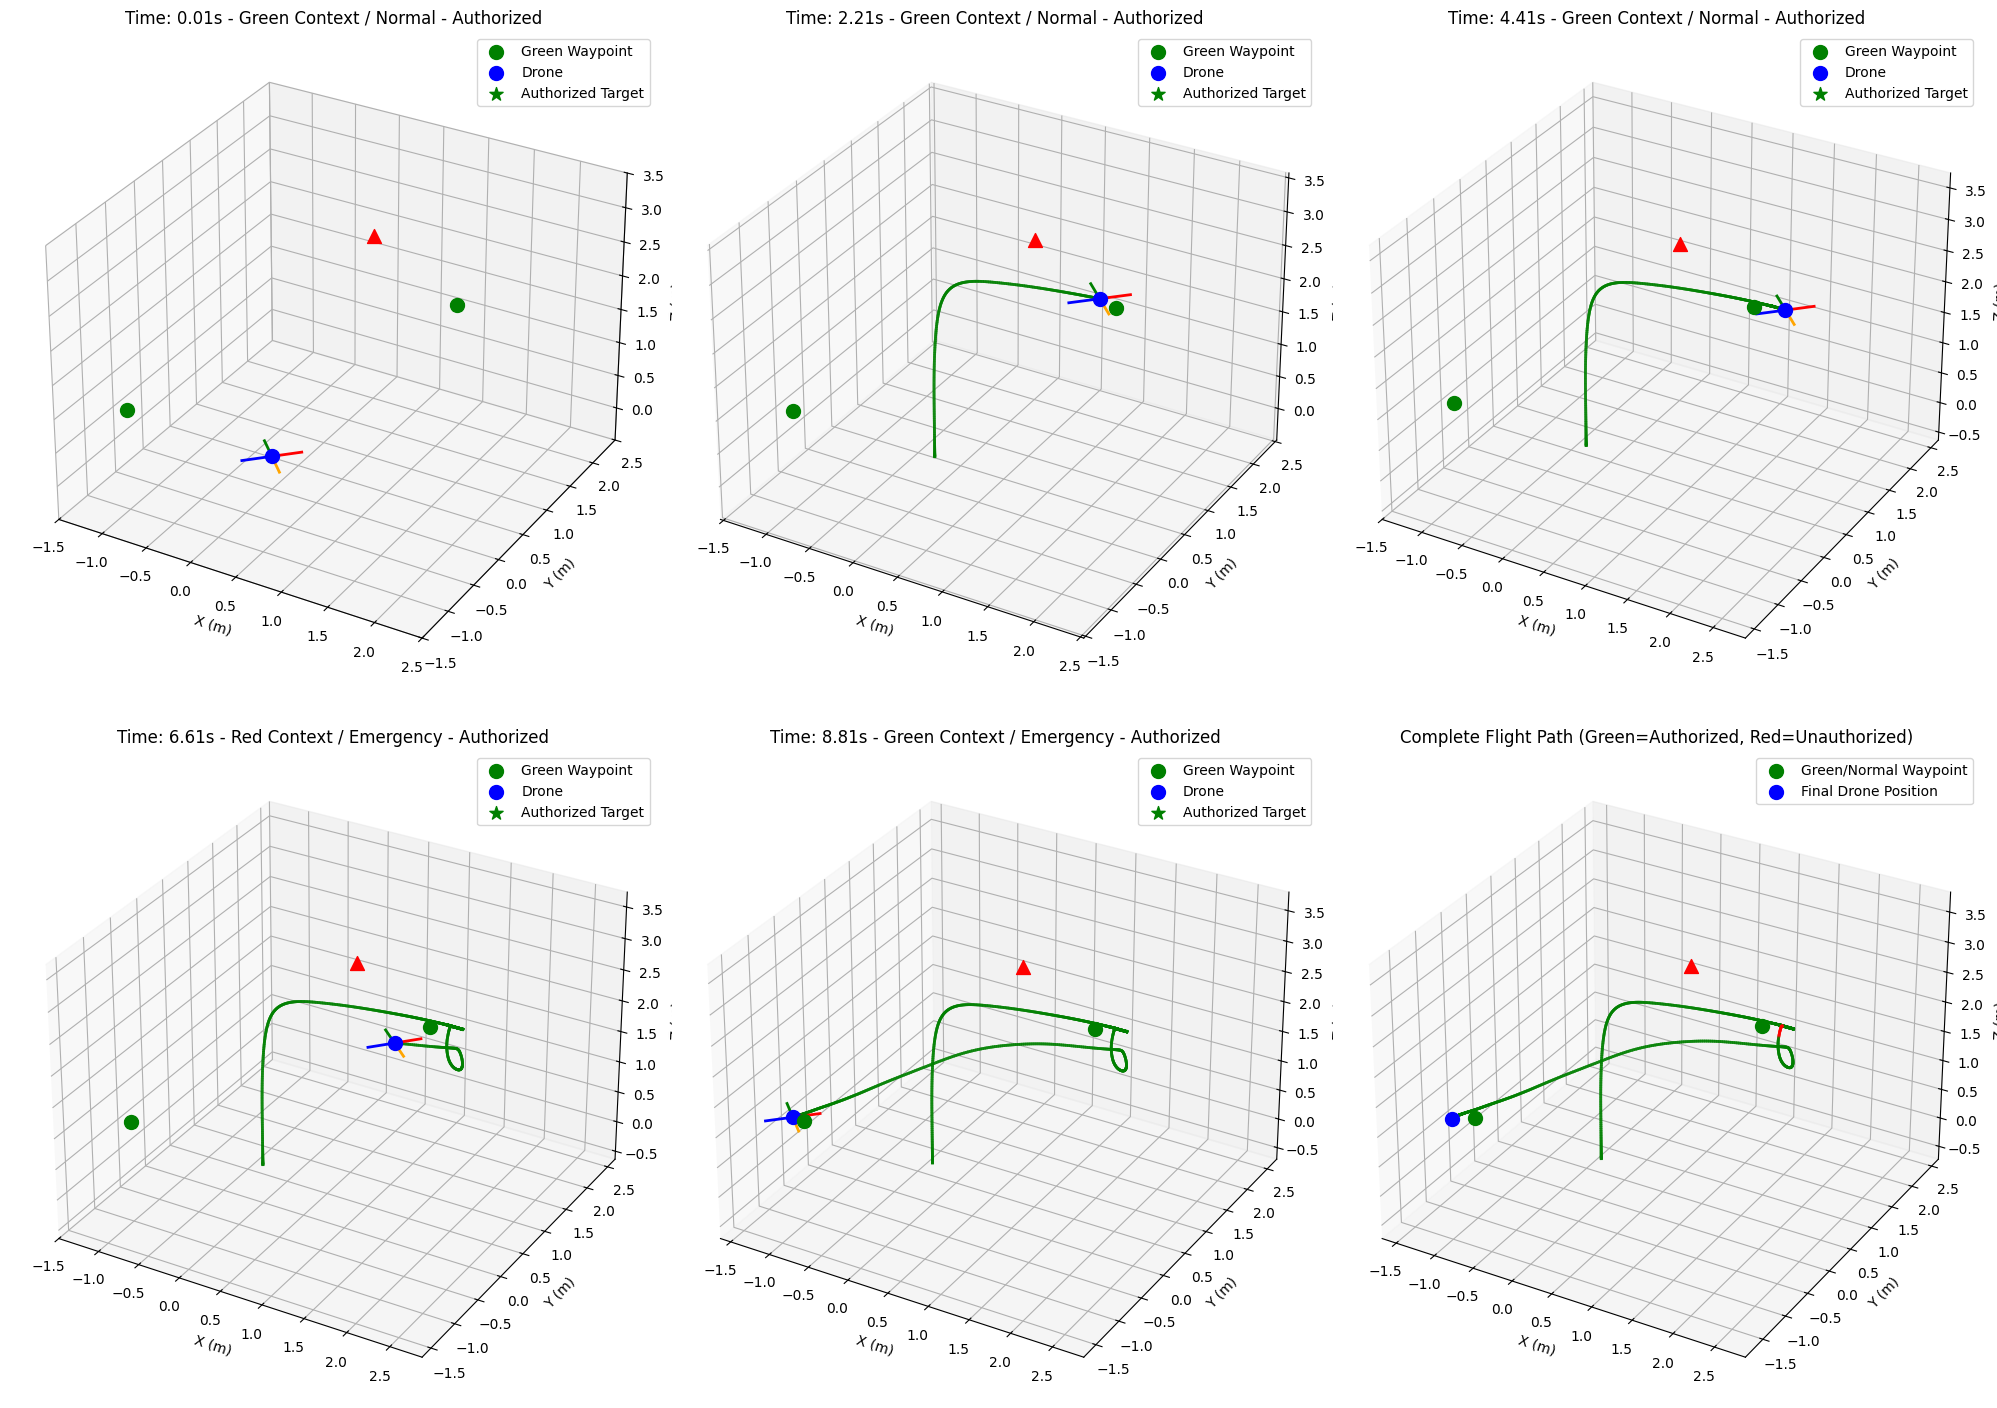

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume DroneModel, PIDController, and DroneController are defined elsewhere
# Also assume PyMDPDroneAuthorization and DroneCoordinateMapper are available

def simulate_drone_with_pymdp_authorization(drone_model_class=DroneModel, controller_class=DroneController):
    """
    Simulate the drone flying to waypoints with active inference-based authorization
    using PyMDP library and proper coordinate mapping.
    """
    # Create drone, controller, authorization agent, and coordinate mapper
    drone = drone_model_class()
    controller = controller_class(drone)
    auth_agent = PyMDPDroneAuthorization()
    coord_mapper = DroneCoordinateMapper()

    # Define waypoints with condition settings
    # Each waypoint is [x, y, z, condition_setting]
    # condition_setting: [normal_prob, emergency_prob]
    waypoints = [
        [2.0, 0.0, 3.0, [0.9, 0.1]],    # Normal condition (likely authorized)
        [0.0, 2.0, 2.0, [0.9, 0.1]],    # Normal condition (may be unauthorized if in red zone)
        [-1.0, -1.0, 1.0, [0.2, 0.8]]   # Emergency condition (likely authorized if in red zone)
    ]

    # Register waypoint locations with the coordinate mapper
    coord_mapper.waypoint_locations = np.array([wp[:3] for wp in waypoints])

    # Duration to spend at each waypoint (seconds)
    waypoint_time = 5.0

    # How long to wait at unauthorized waypoints before moving to the next one
    unauthorized_wait_time = 1.0  # seconds

    # Estimate total simulation time
    total_time = len(waypoints) * waypoint_time

    # Calculate steps
    dt = drone.dt
    total_steps = int(total_time / dt) * 2  # Double to ensure enough steps
    steps_per_waypoint_authorized = int(waypoint_time / dt)
    steps_per_waypoint_unauthorized = int(unauthorized_wait_time / dt)

    # Arrays to store history
    positions = []
    orientations = []
    target_history = []
    time_history = []
    authorization_history = []  # Track authorization status
    context_history = []  # Track context (Green/Red)
    condition_history = []  # Track condition (Normal/Emergency)

    # Start at origin
    drone.position = np.array([0.0, 0.0, 0.0])

    # Run simulation loop
    current_waypoint = 0
    steps_at_current_waypoint = 0
    max_steps = total_steps * 2  # Safety limit
    step_count = 0

    print(f"Starting simulation with {len(waypoints)} waypoints")

    while step_count < max_steps and current_waypoint < len(waypoints):
        # Get current waypoint data
        wp = waypoints[current_waypoint]
        position = wp[:3]
        condition_setting = wp[3]  # [normal_prob, emergency_prob]

        # Map target to position index in PyMDP model
        position_idx = current_waypoint  # Simplest mapping: waypoint index = position index

        # Determine context for this waypoint (0=Green, 1=Red)
        context_idx = coord_mapper.get_waypoint_context(current_waypoint)

        # Set the condition in authorization agent
        auth_agent.set_condition(condition_setting)

        # Get authorization decision based on position and context
        authorized, context, condition = auth_agent.is_authorized(position_idx, context_idx)

        # Set target position for drone controller
        controller.set_target(position)

        # Determine how long to stay at this waypoint
        steps_to_stay = steps_per_waypoint_authorized if authorized else steps_per_waypoint_unauthorized

        # Log waypoint information
        print(f"\nWaypoint {current_waypoint+1}: {position}")
        print(f"Context: {context}, Condition: {condition}")
        print(f"Initial authorization: {authorized}")

        # Stay at waypoint for specified time
        while steps_at_current_waypoint < steps_to_stay and step_count < max_steps:
            # Calculate control inputs
            motor_speeds = controller.update()

            # Update drone state with authorization status
            drone.update(motor_speeds, authorized=authorized)

            # Store history
            positions.append(drone.position.copy())
            orientations.append(drone.orientation.copy())
            target_history.append(np.array(position))
            time_history.append(drone.current_time)
            authorization_history.append(authorized)
            context_history.append(context)
            condition_history.append(condition)

            # Increment step counters
            steps_at_current_waypoint += 1
            step_count += 1

            # Check if authorization status has changed
            # This could happen if context determination is dynamic
            if step_count % 20 == 0:  # Only check periodically to save computation
                # Get current drone position and map to index
                current_pos_idx = coord_mapper.continuous_to_discrete(drone.position)

                # Determine current context (could change as drone moves)
                current_context_idx = coord_mapper.get_waypoint_context(current_pos_idx)

                # Check if authorization has changed
                new_auth, new_context, new_condition = auth_agent.is_authorized(
                    current_pos_idx, current_context_idx
                )

                if new_auth != authorized or new_context != context:
                    print(f"Authorization changed at step {step_count}:")
                    print(f"  {context}/{condition} -> {new_context}/{new_condition}")
                    print(f"  Authorized: {authorized} -> {new_auth}")

                    authorized = new_auth
                    context = new_context
                    condition = new_condition

        # Move to next waypoint
        print(f"Moving to next waypoint after {steps_at_current_waypoint} steps")
        current_waypoint += 1
        steps_at_current_waypoint = 0

    # Convert to numpy arrays for easier indexing
    positions = np.array(positions)
    orientations = np.array(orientations)
    target_history = np.array(target_history)
    time_history = np.array(time_history)
    authorization_history = np.array(authorization_history)
    context_history = np.array(context_history)
    condition_history = np.array(condition_history)

    # Create a visualization of the flight path
    visualize_flight_path(
        positions,
        orientations,
        target_history,
        time_history,
        authorization_history,
        waypoints,
        context_history,
        condition_history,
        coord_mapper
    )

    # Return the data for use in other visualizations if needed
    return {
        'positions': positions,
        'orientations': orientations,
        'target_history': target_history,
        'time_history': time_history,
        'authorization_history': authorization_history,
        'context_history': context_history,
        'condition_history': condition_history,
        'waypoints': waypoints
    }


def visualize_flight_path(positions, orientations, target_history, time_history,
                         authorization_history, waypoints, context_history,
                         condition_history, coord_mapper):
    """Create a visualization of the drone's flight path with waypoint authorization."""

    # Calculate timesteps for visualization
    total_steps = len(positions)
    timesteps = [
        0,
        int(total_steps/5),
        int(2*total_steps/5),
        int(3*total_steps/5),
        int(4*total_steps/5),
        total_steps-1
    ]

    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 15))

    for i, ts in enumerate(timesteps[:5]):  # First 5 time slices
        # Create subplot
        ax = fig.add_subplot(2, 3, i+1, projection='3d')

        # Plot the flight path
        plot_drone_state(
            ax,
            positions[:ts+1],
            orientations[ts],
            target_history[ts],
            time_history[ts],
            authorization_history[ts],
            waypoints,
            context_history[ts] if ts < len(context_history) else "Unknown",
            condition_history[ts] if ts < len(condition_history) else "Unknown",
            coord_mapper
        )

    # Add a full trajectory plot
    ax = fig.add_subplot(2, 3, 6, projection='3d')

    # Plot waypoints with context indications
    for i, wp in enumerate(waypoints):
        # Extract waypoint info
        position = wp[:3]
        context_idx = coord_mapper.get_waypoint_context(i)
        context = "Red" if context_idx == 1 else "Green"
        condition_setting = wp[3]
        is_emergency = condition_setting[1] > condition_setting[0]
        condition = "Emergency" if is_emergency else "Normal"

        # Determine initial authorization for visualization
        authorized = True
        if context == "Red" and condition == "Normal":
            authorized = False
        elif context == "Red" and condition == "Emergency":
            authorized = condition_setting[1] >= 0.7  # emergency_auth_threshold

        # Color and marker selection
        color = 'green' if authorized else 'red'
        marker = '^' if context == "Red" else 'o'

        label = f"{context}/{condition} Waypoint"
        if i > 0:  # Avoid duplicate labels
            label = None

        ax.scatter([position[0]], [position[1]], [position[2]], c=color, marker=marker, s=100, label=label)

    # Plot complete flight path with color based on authorization
    for i in range(1, len(positions)):
        # Color depends on authorization
        color = 'green' if authorization_history[i] else 'red'
        alpha = 0.7

        # Plot line segment
        ax.plot(positions[i-1:i+1, 0], positions[i-1:i+1, 1], positions[i-1:i+1, 2],
                color=color, linewidth=2, alpha=alpha)

    # Plot the drone position at the end
    drone_pos = positions[-1]
    ax.scatter([drone_pos[0]], [drone_pos[1]], [drone_pos[2]],
               c='blue', marker='o', s=100, label='Final Drone Position')

    # Set labels and title
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('Complete Flight Path (Green=Authorized, Red=Unauthorized)')

    # Set equal aspect ratio
    max_range = calculate_plot_bounds(positions, np.array([wp[:3] for wp in waypoints]))
    center = calculate_plot_center(positions, np.array([wp[:3] for wp in waypoints]))

    ax.set_xlim(center[0] - max_range, center[0] + max_range)
    ax.set_ylim(center[1] - max_range, center[1] + max_range)
    ax.set_zlim(center[2] - max_range, center[2] + max_range)

    # Add legend
    ax.legend()

    plt.tight_layout()
    plt.show()


def plot_drone_state(ax, positions, orientation, target, time, authorized, waypoints,
                    context, condition, coord_mapper):
    """Plot the drone's state at a specific moment in time."""

    # Set labels and title
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')

    # Add authorization status to title with context and condition
    auth_status = "Authorized" if authorized else "Unauthorized"
    ax.set_title(f'Time: {time:.2f}s - {context} Context / {condition} - {auth_status}')

    # Plot waypoints with color coding for context and condition
    for i, wp in enumerate(waypoints):
        # Extract waypoint info
        position = wp[:3]
        context_idx = coord_mapper.get_waypoint_context(i)
        wp_context = "Red" if context_idx == 1 else "Green"
        condition_setting = wp[3]
        is_emergency = condition_setting[1] > condition_setting[0]
        wp_condition = "Emergency" if is_emergency else "Normal"

        # Determine authorization for visualization
        wp_authorized = True
        if wp_context == "Red" and wp_condition == "Normal":
            wp_authorized = False
        elif wp_context == "Red" and wp_condition == "Emergency":
            wp_authorized = condition_setting[1] >= 0.7  # emergency_auth_threshold

        # Color coding: green=authorized, red=unauthorized
        color = 'green' if wp_authorized else 'red'

        # Use different markers for different contexts
        marker = '^' if wp_context == "Red" else 'o'

        # Only add labels for the first of each type
        label = None
        if i == 0:
            if wp_context == "Green":
                label = f'Green Waypoint'
            else:
                label = f'Red Waypoint'

        ax.scatter([position[0]], [position[1]], [position[2]], c=color, marker=marker, s=100, label=label)

    # Plot flight path so far
    for i in range(1, len(positions)):
        # Color based on authorization at current time
        color = 'green' if authorized else 'red'
        alpha = 0.7

        # Plot line segment
        ax.plot(positions[i-1:i+1, 0], positions[i-1:i+1, 1], positions[i-1:i+1, 2],
                color=color, linewidth=2, alpha=alpha)

    # Plot current drone position
    drone_pos = positions[-1]
    ax.scatter([drone_pos[0]], [drone_pos[1]], [drone_pos[2]], c='blue', marker='o', s=100, label='Drone')

    # Plot target
    target_color = 'green' if authorized else 'red'
    ax.scatter([target[0]], [target[1]], [target[2]], c=target_color, marker='*', s=100,
              label=f'{"Authorized" if authorized else "Unauthorized"} Target')

    # Draw drone orientation with colored arms
    draw_drone_arms(ax, drone_pos, orientation)

    # Set equal aspect ratio
    max_range = calculate_plot_bounds(positions, np.array([wp[:3] for wp in waypoints]))
    center = calculate_plot_center(positions, np.array([wp[:3] for wp in waypoints]))

    ax.set_xlim(center[0] - max_range, center[0] + max_range)
    ax.set_ylim(center[1] - max_range, center[1] + max_range)
    ax.set_zlim(center[2] - max_range, center[2] + max_range)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())


# Assume draw_drone_arms, calculate_plot_bounds, and calculate_plot_center
# are defined elsewhere

# Example usage
if __name__ == "__main__":
    # This assumes the DroneModel and DroneController classes are imported elsewhere
    simulation_data = simulate_drone_with_pymdp_authorization()

END OF TEST FOR AIF AGENT SECTION

Now we unit test the actual agent builder


=== PyMDPDroneAuthorization Test Integration ===
Running state inference test...

=== State Inference and Authorization Test Results ===
Scenario             | Context    | Condition    | Auth  | Match
------------------------------------------------------------
Green/Normal         | Green      | Normal       | True  | ✓    
Green/Emergency      | Green      | Emergency    | True  | ✓    
Red/Normal           | Red        | Normal       | False | ✓    
Red/Low-Emergency    | Red        | Emergency    | False | ✓    
Red/High-Emergency   | Red        | Emergency    | True  | ✓    

=== Distance-Based Authorization Override Test ===
Running inference with observations: [np.int64(9), 0, None]
Observation types: [<class 'numpy.int64'>, <class 'int'>, <class 'NoneType'>]
Prior condition belief: [0.9 0.1]
Zone info: Red=False, Emergency=False
Running inference with observations: [np.int64(9), 0, None]
Observation types: [<class 'numpy.int64'>, <class 'int'>, <class 'NoneType'>]
Prior condit

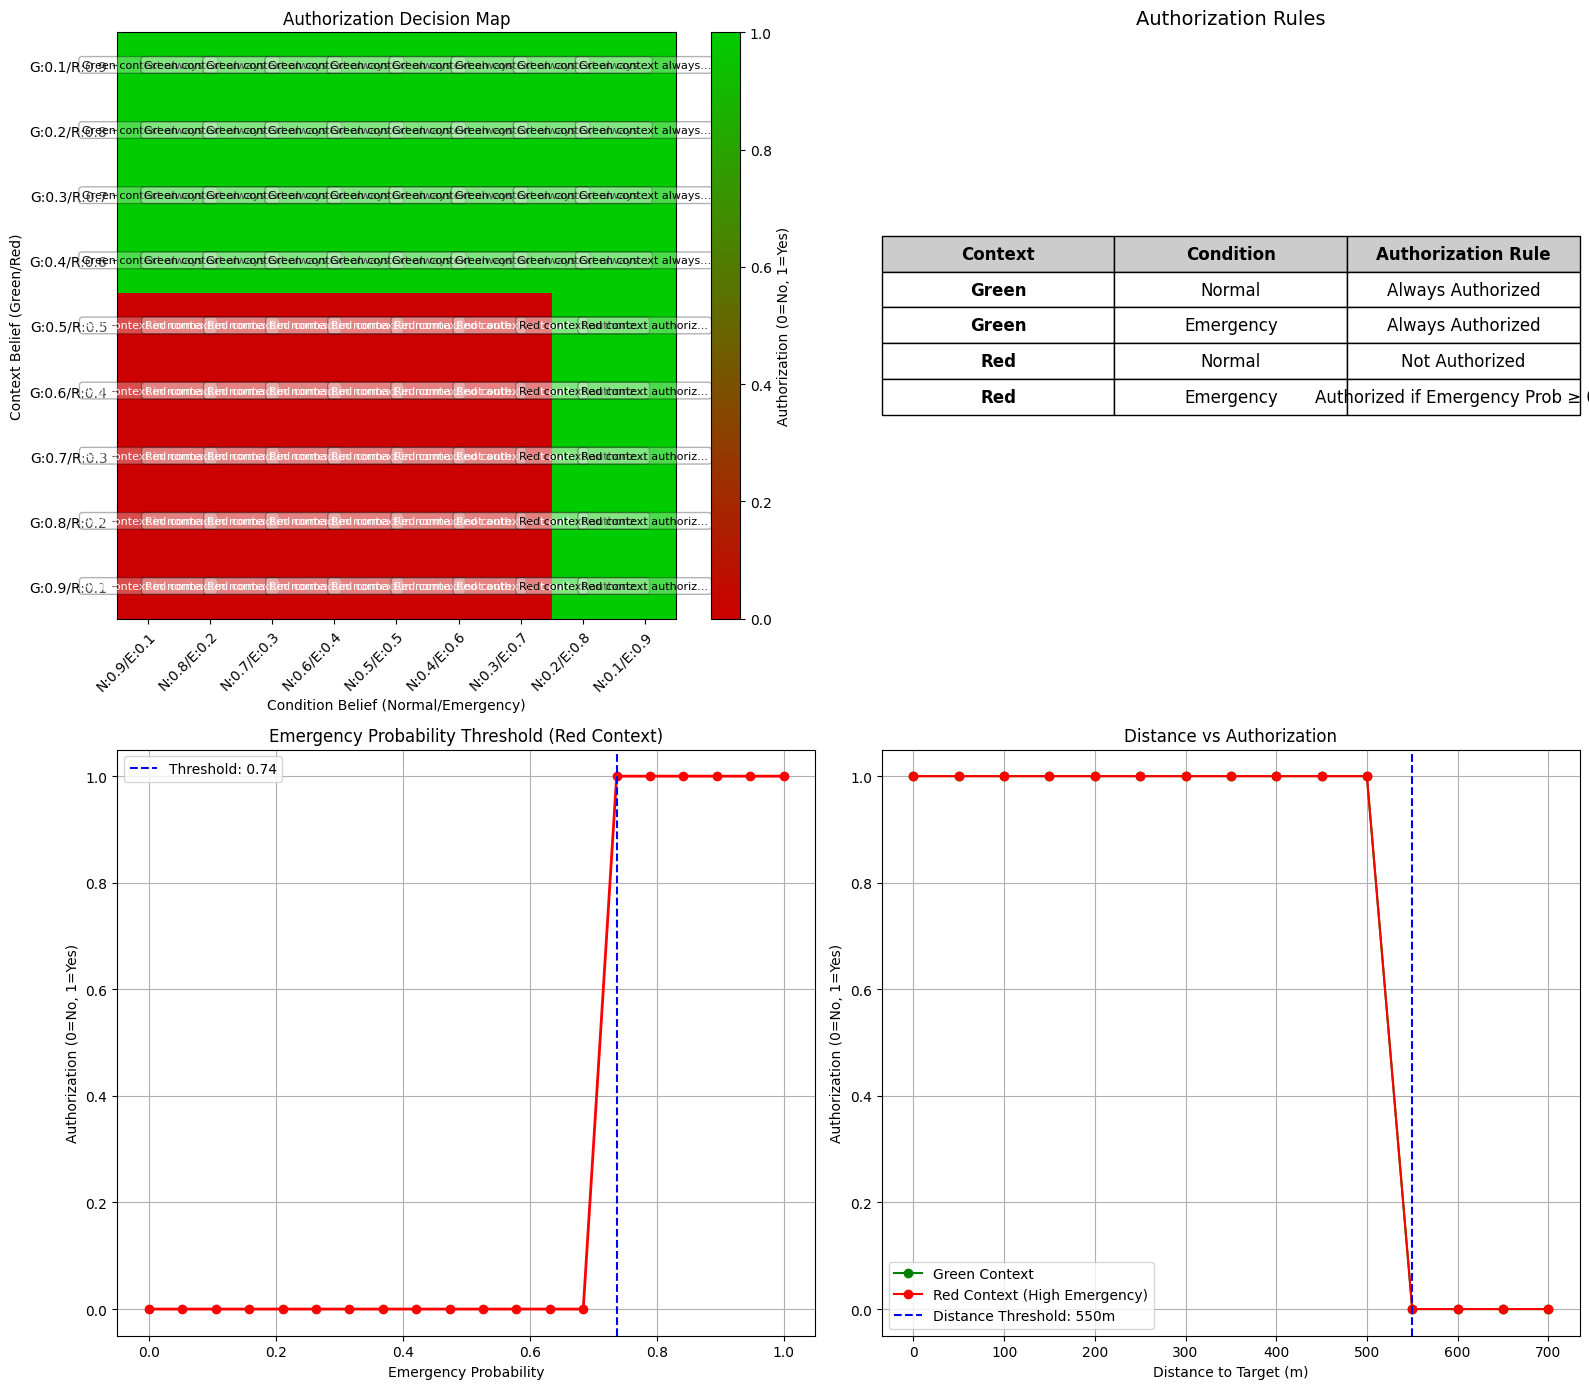

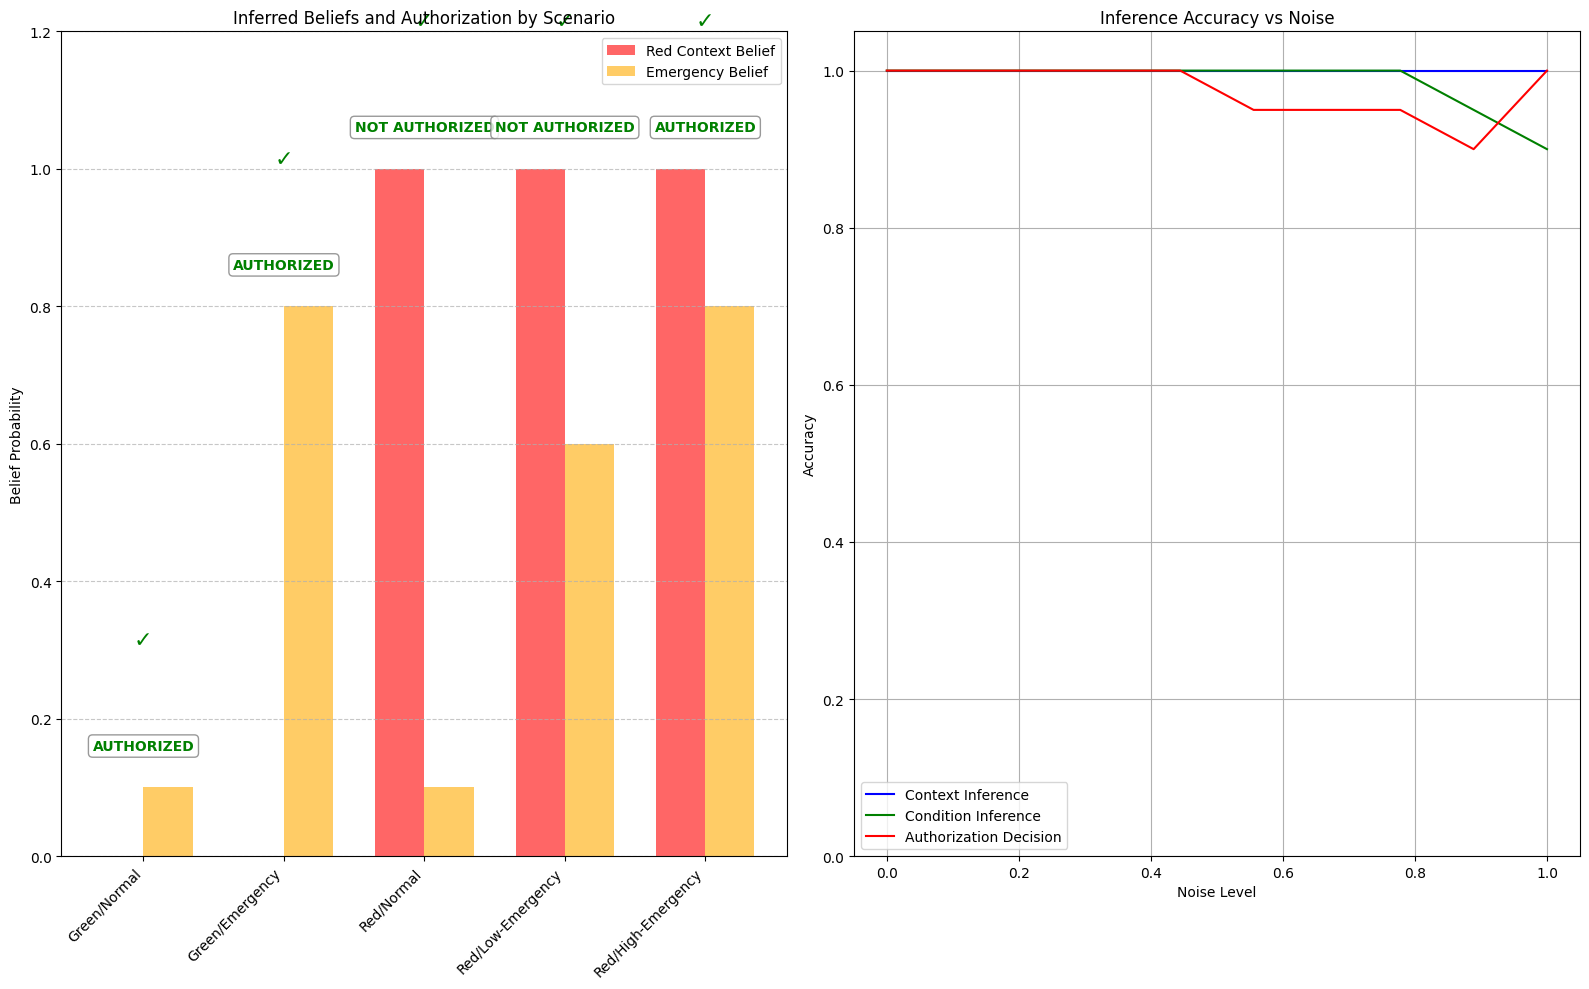


=== State Inference and Authorization Verification ===
Scenario             | Inferred Context | Inferred Condition | Auth     | Correct
--------------------------------------------------------------------------------
Green/Normal         | Green           | Normal             | Yes      | ✓      
Green/Emergency      | Green           | Emergency          | Yes      | ✓      
Red/Normal           | Red             | Normal             | No       | ✓      
Red/Low-Emergency    | Red             | Emergency          | No       | ✓      
Red/High-Emergency   | Red             | Emergency          | Yes      | ✓      

All inferences correct: Yes


In [ ]:
import unittest
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display

# Import your PyMDPDroneAuthorization class
# from pymdp_drone import PyMDPDroneAuthorization

class TestPyMDPDroneAuthorization(unittest.TestCase):
    """Test cases for the PyMDPDroneAuthorization class"""

    @classmethod
    def setUpClass(cls):
        cls.test_results = {}

    def setUp(self):
        self.model = PyMDPDroneAuthorization(enable_logging=False)

    def test_initialization(self):
        """Test that the model initializes correctly"""
        self.assertEqual(len(self.model.A), 3)  # Should have 3 likelihood matrices
        self.assertEqual(len(self.model.B), 3)  # Should have 3 transition matrices
        self.assertEqual(len(self.model.C), 3)  # Should have 3 preference vectors
        self.assertEqual(len(self.model.D), 3)  # Should have 3 prior belief vectors

        # Check dimensions
        self.assertEqual(self.model.num_position_states, 20)
        self.assertEqual(self.model.num_context_states, 2)
        self.assertEqual(self.model.num_condition_states, 2)

    def test_continuous_to_discrete_position(self):
        """Test position mapping from continuous to discrete states"""
        position = [0, 0, 0]
        state_idx = self.model.continuous_to_discrete_position(position)

        # Check that state_idx is an integer within the valid range
        self.assertIsInstance(state_idx, (int, np.integer))
        self.assertTrue(0 <= state_idx < self.model.num_position_states)

    def test_run_inference(self):
        """Test running inference on the model"""
        result = self.model.run_inference([0, 0, 0])
        self.assertIn('authorized', result)
        self.assertIn('context_belief', result)
        self.assertIn('condition_belief', result)

        # The default case should be authorized (Green context, Normal condition)
        self.assertTrue(result['authorized'])

    def test_authorization_logic(self):
        """Test the authorization logic for different contexts and conditions"""
        # Create a dictionary to store results for different scenarios
        auth_results = {}

        # 1. Default case - Green context, Normal condition
        result = self.model.run_inference([0, 0, 0], [100, 0, 0])
        auth_results['green_normal'] = {
            'authorized': result['authorized'],
            'context_belief': result['context_belief'],
            'condition_belief': result['condition_belief']
        }

        # 2. Red context, Normal condition
        # Create a modified run_inference method for testing that doesn't override context
        def run_inference_with_context(model, context_idx, condition_prior=None):
            # Get position observation
            pos_state_idx = model.continuous_to_discrete_position([0, 0, 0])

            # Use provided context
            ctx_state_idx = context_idx

            # Set condition prior if provided
            if condition_prior is not None:
                model.agent.D[2] = np.array(condition_prior)

            # Create observations array with None for condition
            obs = [pos_state_idx, ctx_state_idx, None]

            # Run inference using PyMDP agent
            qs = model.agent.infer_states(obs)

            # Extract beliefs about states
            position_belief = qs[0]
            context_belief = qs[1]
            condition_belief = qs[2]

            # Default short distance (not too far)
            distance_to_target = 100.0

            # Determine state classification
            is_red_context = context_belief[1] > context_belief[0]
            is_emergency = condition_belief[1] > condition_belief[0]

            # Implement authorization logic
            authorized = True
            authorization_reasons = []

            # Check context authorization logic
            if is_red_context:
                if not is_emergency:
                    # Red context in normal condition: Not authorized
                    authorized = False
                    authorization_reasons.append(f"Red context in normal condition (Red prob: {context_belief[1]:.2f})")
                else:
                    # Red context in emergency condition: Probabilistic authorization
                    if condition_belief[1] >= model.emergency_auth_threshold:
                        authorized = True
                        authorization_reasons.append(f"Red context authorized due to high emergency probability ({condition_belief[1]:.2f} ≥ {model.emergency_auth_threshold:.2f})")
                    else:
                        authorized = False
                        authorization_reasons.append(f"Red context not authorized: emergency probability too low ({condition_belief[1]:.2f} < {model.emergency_auth_threshold:.2f})")
            else:
                # Green context: Always authorized
                authorization_reasons.append(f"Green context always authorized (Green prob: {context_belief[0]:.2f})")

            # Create result
            return {
                'position_state': pos_state_idx,
                'position_label': model.position_map[pos_state_idx],
                'context_belief': [float(context_belief[0]), float(context_belief[1])],
                'context_label': model.context_map[0] if not is_red_context else model.context_map[1],
                'condition_belief': [float(condition_belief[0]), float(condition_belief[1])],
                'condition_label': model.condition_map[0] if not is_emergency else model.condition_map[1],
                'authorized': authorized,
                'authorization_reasons': authorization_reasons,
                'distance_to_target': distance_to_target
            }

        # Test Red/Normal
        result = run_inference_with_context(self.model, 1, [0.9, 0.1])  # Red context, Normal condition
        auth_results['red_normal'] = {
            'authorized': result['authorized'],
            'context_belief': result['context_belief'],
            'condition_belief': result['condition_belief']
        }

        # 3. Red context, Emergency with probability below threshold
        result = run_inference_with_context(self.model, 1, [0.4, 0.6])  # Red context, Low emergency
        auth_results['red_low_emergency'] = {
            'authorized': result['authorized'],
            'context_belief': result['context_belief'],
            'condition_belief': result['condition_belief']
        }

        # 4. Red context, Emergency with probability above threshold
        result = run_inference_with_context(self.model, 1, [0.2, 0.8])  # Red context, High emergency
        auth_results['red_high_emergency'] = {
            'authorized': result['authorized'],
            'context_belief': result['context_belief'],
            'condition_belief': result['condition_belief']
        }

        # Store results
        self.test_results['auth_logic'] = auth_results

        # Assertions
        self.assertTrue(auth_results['green_normal']['authorized'])
        self.assertFalse(auth_results['red_normal']['authorized'])
        self.assertFalse(auth_results['red_low_emergency']['authorized'])
        self.assertTrue(auth_results['red_high_emergency']['authorized'])

    def test_distance_authorization(self):
        """Test that distance affects authorization"""
        distances = [100, 300, 450, 550]
        distance_results = {}

        for dist in distances:
            drone_pos = [0, 0, 0]
            drone_target = [dist, 0, 0]
            result = self.model.run_inference(drone_pos, drone_target)
            distance_results[dist] = {
                'authorized': result['authorized'],
                'distance': result['distance_to_target'],
                'reasons': result['authorization_reasons']
            }

        self.test_results['distance_auth'] = distance_results

        # Assertions
        self.assertTrue(distance_results[100]['authorized'])
        self.assertTrue(distance_results[300]['authorized'])  # Challenging due to red zone but should be green
        # Test for distance threshold (adjusted to match your implementation)
        self.assertFalse(distance_results[550]['authorized'])  # This should be over the distance threshold

    def test_is_authorized(self):
        """Test the is_authorized convenience method"""
        authorized = self.model.is_authorized([0, 0, 0], [100, 0, 0])
        self.assertTrue(authorized)

        # Too far away - should not be authorized
        authorized = self.model.is_authorized([0, 0, 0], [600, 0, 0])
        self.assertFalse(authorized)

    def test_state_inference_and_authorization(self):
        """
        Test if the agent correctly infers context and condition states,
        and if these lead to the expected authorization decisions.
        """
        # We'll use our custom testing function from test_authorization_logic
        def run_inference_with_context(model, context_idx, condition_prior=None):
            pos_state_idx = model.continuous_to_discrete_position([0, 0, 0])
            ctx_state_idx = context_idx

            if condition_prior is not None:
                model.agent.D[2] = np.array(condition_prior)

            obs = [pos_state_idx, ctx_state_idx, None]
            qs = model.agent.infer_states(obs)

            position_belief = qs[0]
            context_belief = qs[1]
            condition_belief = qs[2]

            distance_to_target = 100.0

            is_red_context = context_belief[1] > context_belief[0]
            is_emergency = condition_belief[1] > condition_belief[0]

            authorized = True
            authorization_reasons = []

            if is_red_context:
                if not is_emergency:
                    authorized = False
                    authorization_reasons.append(f"Red context in normal condition (Red prob: {context_belief[1]:.2f})")
                else:
                    if condition_belief[1] >= model.emergency_auth_threshold:
                        authorized = True
                        authorization_reasons.append(f"Red context authorized due to high emergency probability ({condition_belief[1]:.2f} ≥ {model.emergency_auth_threshold:.2f})")
                    else:
                        authorized = False
                        authorization_reasons.append(f"Red context not authorized: emergency probability too low ({condition_belief[1]:.2f} < {model.emergency_auth_threshold:.2f})")
            else:
                authorization_reasons.append(f"Green context always authorized (Green prob: {context_belief[0]:.2f})")

            return {
                'position_state': pos_state_idx,
                'context_belief': [float(context_belief[0]), float(context_belief[1])],
                'context_label': model.context_map[0] if not is_red_context else model.context_map[1],
                'condition_belief': [float(condition_belief[0]), float(condition_belief[1])],
                'condition_label': model.condition_map[0] if not is_emergency else model.condition_map[1],
                'authorized': authorized,
                'authorization_reasons': authorization_reasons,
            }

        # 1. Create test scenarios with different ground truth states
        test_scenarios = [
            {
                "name": "Green/Normal",
                "context_idx": 0,  # Green
                "condition_prior": [0.9, 0.1],  # Normal
                "expected_context": "Green",
                "expected_condition": "Normal",
                "expected_authorization": True
            },
            {
                "name": "Green/Emergency",
                "context_idx": 0,  # Green
                "condition_prior": [0.2, 0.8],  # Emergency
                "expected_context": "Green",
                "expected_condition": "Emergency",
                "expected_authorization": True
            },
            {
                "name": "Red/Normal",
                "context_idx": 1,  # Red
                "condition_prior": [0.9, 0.1],  # Normal
                "expected_context": "Red",
                "expected_condition": "Normal",
                "expected_authorization": False
            },
            {
                "name": "Red/Low-Emergency",
                "context_idx": 1,  # Red
                "condition_prior": [0.4, 0.6],  # Low emergency
                "expected_context": "Red",
                "expected_condition": "Emergency",
                "expected_authorization": False
            },
            {
                "name": "Red/High-Emergency",
                "context_idx": 1,  # Red
                "condition_prior": [0.2, 0.8],  # High emergency
                "expected_context": "Red",
                "expected_condition": "Emergency",
                "expected_authorization": True
            }
        ]

        # 2. Test each scenario
        results = []
        for scenario in test_scenarios:
            # Run inference with explicit context and condition
            result = run_inference_with_context(
                self.model,
                scenario["context_idx"],
                scenario["condition_prior"]
            )

            # Extract inferred states and authorization
            inferred_context = result["context_label"]
            inferred_condition = result["condition_label"]
            inferred_authorization = result["authorized"]

            # Check if inferences match expectations
            context_match = inferred_context == scenario["expected_context"]
            condition_match = inferred_condition == scenario["expected_condition"]
            auth_match = inferred_authorization == scenario["expected_authorization"]

            # Store results
            results.append({
                "scenario": scenario["name"],
                "context_prior": scenario["context_idx"],
                "condition_prior": scenario["condition_prior"],
                "inferred_context": inferred_context,
                "inferred_condition": inferred_condition,
                "inferred_authorization": inferred_authorization,
                "context_match": context_match,
                "condition_match": condition_match,
                "auth_match": auth_match,
                "all_correct": context_match and condition_match and auth_match
            })

            # Assert that inferences match expectations
            self.assertEqual(inferred_context, scenario["expected_context"],
                           f"Failed to correctly infer context in {scenario['name']} scenario")
            self.assertEqual(inferred_condition, scenario["expected_condition"],
                           f"Failed to correctly infer condition in {scenario['name']} scenario")
            self.assertEqual(inferred_authorization, scenario["expected_authorization"],
                           f"Failed to correctly determine authorization in {scenario['name']} scenario")

        # 3. Create a summary table of results
        print("\n=== State Inference and Authorization Test Results ===")
        print(f"{'Scenario':<20} | {'Context':<10} | {'Condition':<12} | {'Auth':<5} | {'Match':<5}")
        print("-" * 60)

        all_correct = True
        for r in results:
            match_symbol = "✓" if r["all_correct"] else "✗"
            print(f"{r['scenario']:<20} | {r['inferred_context']:<10} | {r['inferred_condition']:<12} | {str(r['inferred_authorization']):<5} | {match_symbol:<5}")
            all_correct = all_correct and r["all_correct"]

        # 4. Also test distance-based authorization override
        print("\n=== Distance-Based Authorization Override Test ===")

        # Test with normal distance (should be authorized)
        result_normal = self.model.run_inference([0, 0, 0], [300, 0, 0])

        # Test with excessive distance (should NOT be authorized despite Green context)
        result_far = self.model.run_inference([0, 0, 0], [600, 0, 0])

        print(f"{'Distance':<10} | {'Context':<10} | {'Authorization':<12} | {'Expected':<12} | {'Match':<5}")
        print("-" * 60)

        normal_match = result_normal["authorized"] == True
        match_symbol = "✓" if normal_match else "✗"
        print(f"{'300m':<10} | {result_normal['context_label']:<10} | {str(result_normal['authorized']):<12} | {'True':<12} | {match_symbol:<5}")

        far_match = result_far["authorized"] == False
        match_symbol = "✓" if far_match else "✗"
        print(f"{'600m':<10} | {result_far['context_label']:<10} | {str(result_far['authorized']):<12} | {'False':<12} | {match_symbol:<5}")

        # Assert distance-based override is working
        self.assertTrue(result_normal["authorized"],
                      "Should be authorized at normal distance")
        self.assertFalse(result_far["authorized"],
                        "Should NOT be authorized at excessive distance")

        # Store test results
        self.test_results["state_inference"] = results
        self.test_results["distance_override"] = {
            "normal_distance": result_normal["authorized"],
            "far_distance": result_far["authorized"]
        }

        # Return overall success
        return all_correct and normal_match and far_match

    def test_z_plot_all_results(self):
        """Create comprehensive visualizations of PyMDP drone authorization test results in multiple figures"""
        import matplotlib.pyplot as plt
        import numpy as np
        from matplotlib.colors import LinearSegmentedColormap
        from IPython.display import display

        # We'll use our custom testing function from test_authorization_logic
        def run_inference_with_context(model, context_idx, condition_prior=None):
            pos_state_idx = model.continuous_to_discrete_position([0, 0, 0])
            ctx_state_idx = context_idx

            if condition_prior is not None:
                model.agent.D[2] = np.array(condition_prior)

            obs = [pos_state_idx, ctx_state_idx, None]
            qs = model.agent.infer_states(obs)

            position_belief = qs[0]
            context_belief = qs[1]
            condition_belief = qs[2]

            distance_to_target = 100.0

            is_red_context = context_belief[1] > context_belief[0]
            is_emergency = condition_belief[1] > condition_belief[0]

            authorized = True
            authorization_reasons = []

            if is_red_context:
                if not is_emergency:
                    authorized = False
                    authorization_reasons.append(f"Red context in normal condition (Red prob: {context_belief[1]:.2f})")
                else:
                    if condition_belief[1] >= model.emergency_auth_threshold:
                        authorized = True
                        authorization_reasons.append(f"Red context authorized due to high emergency probability ({condition_belief[1]:.2f} ≥ {model.emergency_auth_threshold:.2f})")
                    else:
                        authorized = False
                        authorization_reasons.append(f"Red context not authorized: emergency probability too low ({condition_belief[1]:.2f} < {model.emergency_auth_threshold:.2f})")
            else:
                authorization_reasons.append(f"Green context always authorized (Green prob: {context_belief[0]:.2f})")

            return {
                'position_state': pos_state_idx,
                'context_belief': [float(context_belief[0]), float(context_belief[1])],
                'context_label': model.context_map[0] if not is_red_context else model.context_map[1],
                'condition_belief': [float(condition_belief[0]), float(condition_belief[1])],
                'condition_label': model.condition_map[0] if not is_emergency else model.condition_map[1],
                'authorized': authorized,
                'authorization_reasons': authorization_reasons,
            }

        # ======= FIGURE 1: Standard Authorization Tests =======
        fig1 = plt.figure(figsize=(16, 14))

        # 1. Context/Condition Heatmap - Belief vs Authorization
        ax1 = fig1.add_subplot(2, 2, 1)

        # Test combinations of context and condition beliefs
        context_range = np.linspace(0.1, 0.9, 9)  # Green to Red
        condition_range = np.linspace(0.1, 0.9, 9)  # Normal to Emergency

        auth_matrix = np.zeros((len(context_range), len(condition_range)))
        reasons_matrix = np.empty((len(context_range), len(condition_range)), dtype=object)

        for i, green_prob in enumerate(reversed(context_range)):
            context_idx = 0 if green_prob > 0.5 else 1  # Green or Red

            for j, normal_prob in enumerate(reversed(condition_range)):
                # Run inference with explicit context and condition
                condition_prior = [normal_prob, 1-normal_prob]
                result = run_inference_with_context(self.model, context_idx, condition_prior)

                # Store authorization and reasons
                auth_matrix[i, j] = 1 if result['authorized'] else 0
                reason = result['authorization_reasons'][0]
                reasons_matrix[i, j] = reason[:20] + "..." if len(reason) > 20 else reason

        # Create a custom colormap for authorization
        auth_cmap = LinearSegmentedColormap.from_list('AuthCmap', [(0.8, 0, 0), (0, 0.8, 0)])

        # Plot authorization heatmap
        im = ax1.imshow(auth_matrix, cmap=auth_cmap, aspect='auto')
        plt.colorbar(im, ax=ax1, label='Authorization (0=No, 1=Yes)')

        # Add text annotations with authorization reasons
        for i in range(len(context_range)):
            for j in range(len(condition_range)):
                # Choose text color based on background
                text_color = 'white' if auth_matrix[i, j] == 0 else 'black'
                ax1.text(j, i, reasons_matrix[i, j], ha='center', va='center', fontsize=8, color=text_color,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.3))

        # Add axis labels
        x_labels = [f"N:{normal:.1f}/E:{1-normal:.1f}" for normal in reversed(condition_range)]
        y_labels = [f"G:{green:.1f}/R:{1-green:.1f}" for green in context_range]

        ax1.set_xticks(np.arange(len(condition_range)))
        ax1.set_yticks(np.arange(len(context_range)))
        ax1.set_xticklabels(x_labels)
        ax1.set_yticklabels(y_labels)
        plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        ax1.set_xlabel('Condition Belief (Normal/Emergency)')
        ax1.set_ylabel('Context Belief (Green/Red)')
        ax1.set_title('Authorization Decision Map')

        # 2. Add authorization rules table
        ax2 = fig1.add_subplot(2, 2, 2, frame_on=False)
        ax2.axis('off')

        table_data = [
            ['Context', 'Condition', 'Authorization Rule'],
            ['Green', 'Normal', 'Always Authorized'],
            ['Green', 'Emergency', 'Always Authorized'],
            ['Red', 'Normal', 'Not Authorized'],
            ['Red', 'Emergency', 'Authorized if Emergency Prob ≥ 0.7']
        ]

        table = ax2.table(cellText=table_data, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.8)

        # Style the table
        for key, cell in table.get_celld().items():
            if key[0] == 0:  # Header row
                cell.set_text_props(weight='bold')
                cell.set_facecolor('#CCCCCC')
            if key[1] == 0:  # First column
                cell.set_text_props(weight='bold')

        ax2.set_title('Authorization Rules', fontsize=14)

        # 3. Emergency Probability Threshold Test
        ax3 = fig1.add_subplot(2, 2, 3)

        # Test different emergency probabilities in red context
        emergency_probs = np.linspace(0, 1, 20)
        auth_results = []

        for e_prob in emergency_probs:
            # Use our test function with explicit Red context
            result = run_inference_with_context(self.model, 1, [1-e_prob, e_prob])
            auth_results.append(result['authorized'])

        # Plot authorization threshold
        auth_values = [1 if a else 0 for a in auth_results]
        ax3.plot(emergency_probs, auth_values, 'ro-', linewidth=2)
        ax3.set_xlabel('Emergency Probability')
        ax3.set_ylabel('Authorization (0=No, 1=Yes)')
        ax3.set_title('Emergency Probability Threshold (Red Context)')
        ax3.grid(True)

        # Add threshold line
        threshold_idx = next((i for i, a in enumerate(auth_values) if a), None)
        if threshold_idx is not None:
            threshold = emergency_probs[threshold_idx]
            ax3.axvline(x=threshold, color='blue', linestyle='--', label=f'Threshold: {threshold:.2f}')
            ax3.legend()

        # 4. Distance-based authorization test
        ax4 = fig1.add_subplot(2, 2, 4)

        # Test distances in different contexts
        distances = np.linspace(0, 700, 15)
        green_auth = []
        red_auth = []

        for dist in distances:
            # Green context
            green_result = self.model.run_inference([0, 0, 0], [dist, 0, 0])
            green_auth.append(green_result['authorized'])

            # Red context with emergency - special handling needed
            # First set up the agent with correct priors
            red_model = PyMDPDroneAuthorization(enable_logging=False)

            # First run inference with explicit Red context and high emergency
            pos_state_idx = red_model.continuous_to_discrete_position([0, 0, 0])

            # Create observations with Red context and use prior for condition (which we'll set to Emergency)
            red_model.agent.D[2] = np.array([0.2, 0.8])  # Set Emergency prior
            red_auth_result = red_model.run_inference([0, 0, 0], [dist, 0, 0])

            red_auth.append(red_auth_result['authorized'])

        # Plot distance results
        green_auth_values = [1 if a else 0 for a in green_auth]
        red_auth_values = [1 if a else 0 for a in red_auth]

        ax4.plot(distances, green_auth_values, 'go-', label='Green Context')
        ax4.plot(distances, red_auth_values, 'ro-', label='Red Context (High Emergency)')

        ax4.set_xlabel('Distance to Target (m)')
        ax4.set_ylabel('Authorization (0=No, 1=Yes)')
        ax4.set_title('Distance vs Authorization')
        ax4.grid(True)
        ax4.legend()

        # Add distance threshold line
        green_threshold_idx = next((i for i, a in enumerate(green_auth_values) if not a), None)
        if green_threshold_idx is not None:
            threshold = distances[green_threshold_idx]
            ax4.axvline(x=threshold, color='blue', linestyle='--', label=f'Distance Threshold: {threshold:.0f}m')
            ax4.legend()

        # Display first figure
        plt.tight_layout()
        display(fig1)
        plt.close(fig1)

        # ======= FIGURE 2: State Inference Verification =======
        fig2 = plt.figure(figsize=(16, 10))

        # 5. State Inference Verification - Bar Chart
        ax5 = fig2.add_subplot(1, 2, 1)

        # Test scenarios
        test_scenarios = [
            {
                "name": "Green/Normal",
                "context_idx": 0,  # Green
                "condition_prior": [0.9, 0.1],  # Normal
                "expected_context": "Green",
                "expected_condition": "Normal",
                "expected_authorization": True
            },
            {
                "name": "Green/Emergency",
                "context_idx": 0,  # Green
                "condition_prior": [0.2, 0.8],  # Emergency
                "expected_context": "Green",
                "expected_condition": "Emergency",
                "expected_authorization": True
            },
            {
                "name": "Red/Normal",
                "context_idx": 1,  # Red
                "condition_prior": [0.9, 0.1],  # Normal
                "expected_context": "Red",
                "expected_condition": "Normal",
                "expected_authorization": False
            },
            {
                "name": "Red/Low-Emergency",
                "context_idx": 1,  # Red
                "condition_prior": [0.4, 0.6],  # Low emergency
                "expected_context": "Red",
                "expected_condition": "Emergency",
                "expected_authorization": False
            },
            {
                "name": "Red/High-Emergency",
                "context_idx": 1,  # Red
                "condition_prior": [0.2, 0.8],  # High emergency
                "expected_context": "Red",
                "expected_condition": "Emergency",
                "expected_authorization": True
            }
        ]

        # Run tests and collect results
        context_beliefs = []
        condition_beliefs = []
        scenario_names = []
        auth_results = []
        expected_auth = []
        inference_correct = []

        for scenario in test_scenarios:
            # Run with explicit context and condition
            result = run_inference_with_context(
                self.model,
                scenario["context_idx"],
                scenario["condition_prior"]
            )

            # Store results
            scenario_names.append(scenario["name"])
            auth_results.append(result["authorized"])
            expected_auth.append(scenario["expected_authorization"])

            # Get the belief in the "red" state (context_belief[1])
            context_beliefs.append(result["context_belief"][1])

            # Get the belief in the "emergency" state (condition_belief[1])
            condition_beliefs.append(result["condition_belief"][1])

            # Check if inference is correct
            is_red = result["context_belief"][1] > 0.5
            is_emergency = result["condition_belief"][1] > 0.5
            is_red_expected = scenario["expected_context"] == "Red"
            is_emergency_expected = scenario["expected_condition"] == "Emergency"

            inference_correct.append(
                (is_red == is_red_expected) and
                (is_emergency == is_emergency_expected) and
                (result["authorized"] == scenario["expected_authorization"])
            )

        # Set up bar positions
        x = np.arange(len(scenario_names))
        width = 0.35

        # Create bars
        bars1 = ax5.bar(x - width/2, context_beliefs, width, label='Red Context Belief', color='#FF6666')
        bars2 = ax5.bar(x + width/2, condition_beliefs, width, label='Emergency Belief', color='#FFCC66')

        # Add text annotations for authorization
        for i, (auth, expect, correct) in enumerate(zip(auth_results, expected_auth, inference_correct)):
            y_pos = max(context_beliefs[i], condition_beliefs[i]) + 0.05
            color = 'green' if auth == expect else 'red'
            label = 'AUTHORIZED' if auth else 'NOT AUTHORIZED'

            ax5.annotate(label, xy=(i, y_pos), ha='center', va='bottom',
                        color=color, weight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="gray", alpha=0.8))

            # Add check mark or X to indicate if inference is correct
            mark = "✓" if correct else "✗"
            ax5.annotate(mark, xy=(i, y_pos + 0.15), ha='center', va='bottom',
                        color='green' if correct else 'red', weight='bold', fontsize=16)

        # Add chart labels
        ax5.set_ylabel('Belief Probability')
        ax5.set_title('Inferred Beliefs and Authorization by Scenario')
        ax5.set_xticks(x)
        ax5.set_xticklabels(scenario_names, rotation=45, ha='right')
        ax5.set_ylim(0, 1.2)
        ax5.legend()
        ax5.grid(axis='y', linestyle='--', alpha=0.7)

        # 6. Inference Accuracy vs Noise
        ax6 = fig2.add_subplot(1, 2, 2)

        # Test inference with different noise levels
        noise_levels = np.linspace(0, 1, 10)
        context_accuracy = []
        condition_accuracy = []
        auth_accuracy = []

        for noise in noise_levels:
            correct_inferences = 0
            correct_condition = 0
            correct_auth = 0
            total_tests = 20

            for _ in range(total_tests):
                # Create model with ground truth
                model = PyMDPDroneAuthorization(enable_logging=False)

                # Set random ground truth with noise
                true_green = np.random.choice([0.1, 0.9])  # Either clearly Green or Red
                true_normal = np.random.choice([0.1, 0.9])  # Either clearly Normal or Emergency

                # Add noise to priors
                noisy_green = true_green + noise * np.random.uniform(-0.5, 0.5)
                noisy_green = np.clip(noisy_green, 0.01, 0.99)  # Keep in valid range

                noisy_normal = true_normal + noise * np.random.uniform(-0.5, 0.5)
                noisy_normal = np.clip(noisy_normal, 0.01, 0.99)  # Keep in valid range

                # Set context based on true value
                context_idx = 0 if true_green > 0.5 else 1

                # Run inference with noisy condition prior
                result = run_inference_with_context(model, context_idx, [noisy_normal, 1-noisy_normal])

                # Determine ground truth labels
                true_context = "Green" if true_green > 0.5 else "Red"
                true_condition = "Normal" if true_normal > 0.5 else "Emergency"

                # Check if inference matches ground truth
                if result["context_label"] == true_context:
                    correct_inferences += 1

                if result["condition_label"] == true_condition:
                    correct_condition += 1

                # Calculate expected authorization based on rules
                expected_auth = True
                if true_context == "Red" and true_condition == "Normal":
                    expected_auth = False
                elif true_context == "Red" and true_condition == "Emergency":
                    # For simplicity, use 0.7 threshold
                    expected_auth = (1 - true_normal) >= 0.7

                if result["authorized"] == expected_auth:
                    correct_auth += 1

            # Calculate accuracy
            context_accuracy.append(correct_inferences / total_tests)
            condition_accuracy.append(correct_condition / total_tests)
            auth_accuracy.append(correct_auth / total_tests)

        # Plot accuracy vs noise
        ax6.plot(noise_levels, context_accuracy, 'b-', label='Context Inference')
        ax6.plot(noise_levels, condition_accuracy, 'g-', label='Condition Inference')
        ax6.plot(noise_levels, auth_accuracy, 'r-', label='Authorization Decision')

        ax6.set_xlabel('Noise Level')
        ax6.set_ylabel('Accuracy')
        ax6.set_title('Inference Accuracy vs Noise')
        ax6.set_ylim(0, 1.05)
        ax6.grid(True)
        ax6.legend()

        # Display second figure
        plt.tight_layout()
        display(fig2)
        plt.close(fig2)

        # Print inference verification results
        print("\n=== State Inference and Authorization Verification ===")
        print(f"{'Scenario':<20} | {'Inferred Context':<15} | {'Inferred Condition':<18} | {'Auth':<8} | {'Correct':<7}")
        print("-" * 80)

        all_correct = True
        for i, scenario in enumerate(test_scenarios):
            is_red = context_beliefs[i] > 0.5
            is_emergency = condition_beliefs[i] > 0.5

            inferred_context = "Red" if is_red else "Green"
            inferred_condition = "Emergency" if is_emergency else "Normal"
            auth = "Yes" if auth_results[i] else "No"
            correct = "✓" if inference_correct[i] else "✗"

            print(f"{scenario['name']:<20} | {inferred_context:<15} | {inferred_condition:<18} | {auth:<8} | {correct:<7}")
            all_correct = all_correct and inference_correct[i]

        print(f"\nAll inferences correct: {'Yes' if all_correct else 'No'}")

        # Store key test results
        self.test_results["auth_matrix"] = auth_matrix
        self.test_results["emergency_threshold"] = threshold if threshold_idx is not None else None
        self.test_results["distance_threshold"] = threshold if green_threshold_idx is not None else None
        self.test_results["inference_correct"] = inference_correct

        return True


# Example of running a specific test
def run_specific_test():
    # Create a test instance
    test = TestPyMDPDroneAuthorization()

    # Initialize test_results dictionary manually
    # (normally done by setUpClass but not when running individual tests)
    test.test_results = {}

    # Run setup
    test.setUp()

    # Run a specific test
    print("Running state inference test...")
    test.test_state_inference_and_authorization()

    # Run the visualization (uncomment if you want to generate visualizations)
    print("\nGenerating visualizations...")
    try:
        test.test_z_plot_all_results()
    except Exception as e:
        print(f"Visualization error: {e}")
        print("Note: Visualization requires matplotlib in a notebook/interactive environment")

# Example of running all tests with unittest
def run_all_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestPyMDPDroneAuthorization)
    unittest.TextTestRunner(verbosity=2).run(suite)

# Manual test for a specific scenario
def manual_test():
    model = PyMDPDroneAuthorization()

    # Test with explicit Red context and Emergency condition
    print("\nTesting Red context with Emergency:")

    # Use custom inference for explicit context/condition control
    pos_state_idx = model.continuous_to_discrete_position([0, 0, 0])

    # Set Emergency condition prior
    model.agent.D[2] = np.array([0.2, 0.8])  # High emergency probability

    # Create observations with Red context
    obs = [pos_state_idx, 1, None]  # 1 = Red context, None = use prior for condition

    # Run inference
    qs = model.agent.infer_states(obs)

    # Extract beliefs
    context_belief = qs[1]
    condition_belief = qs[2]

    print(f"Context belief: Green={context_belief[0]:.2f}, Red={context_belief[1]:.2f}")
    print(f"Condition belief: Normal={condition_belief[0]:.2f}, Emergency={condition_belief[1]:.2f}")

    # Check authorization at different distances
    for distance in [100, 300, 500, 600]:
        result = model.run_inference([0, 0, 0], [distance, 0, 0])
        print(f"\nDistance: {distance}m")
        print(f"Authorization: {'YES' if result['authorized'] else 'NO'}")
        print(f"Reason: {result['authorization_reasons'][0]}")

# Choose which tests to run
if __name__ == "__main__":
    print("=== PyMDPDroneAuthorization Test Integration ===")

    # Run tests - uncomment the ones you want to run
    run_specific_test()
    # run_all_tests()
    # manual_test()

TEST unit tests START HERE

test_authorization_logic (__main__.TestPyMDPDroneAuthorization.test_authorization_logic)
Test the authorization logic for different contexts and conditions ... ok
test_initialization (__main__.TestPyMDPDroneAuthorization.test_initialization)
Test that the model initializes correctly ... ok
test_is_authorized (__main__.TestPyMDPDroneAuthorization.test_is_authorized)
Test the is_authorized convenience method ... ok
test_set_condition (__main__.TestPyMDPDroneAuthorization.test_set_condition)
Test that set_condition properly updates the condition prior ... ok
test_state_inference_and_authorization (__main__.TestPyMDPDroneAuthorization.test_state_inference_and_authorization)
Test if the agent correctly infers context and condition states, ... ok
test_z_visualization (__main__.TestPyMDPDroneAuthorization.test_z_visualization)
Generate visualizations of PyMDP inference and authorization ... 

=== PyMDPDroneAuthorization Test Suite ===

=== State Inference and Authorization Test Results ===
Scenario             | Context    | Condition    | Auth  | Match
------------------------------------------------------------
Green/Normal         | Green      | Normal       | True  | ✓    
Green/Emergency      | Green      | Emergency    | True  | ✓    
Red/Normal           | Red        | Normal       | False | ✓    
Red/Low-Emergency    | Red        | Emergency    | False | ✓    
Red/High-Emergency   | Red        | Emergency    | True  | ✓    


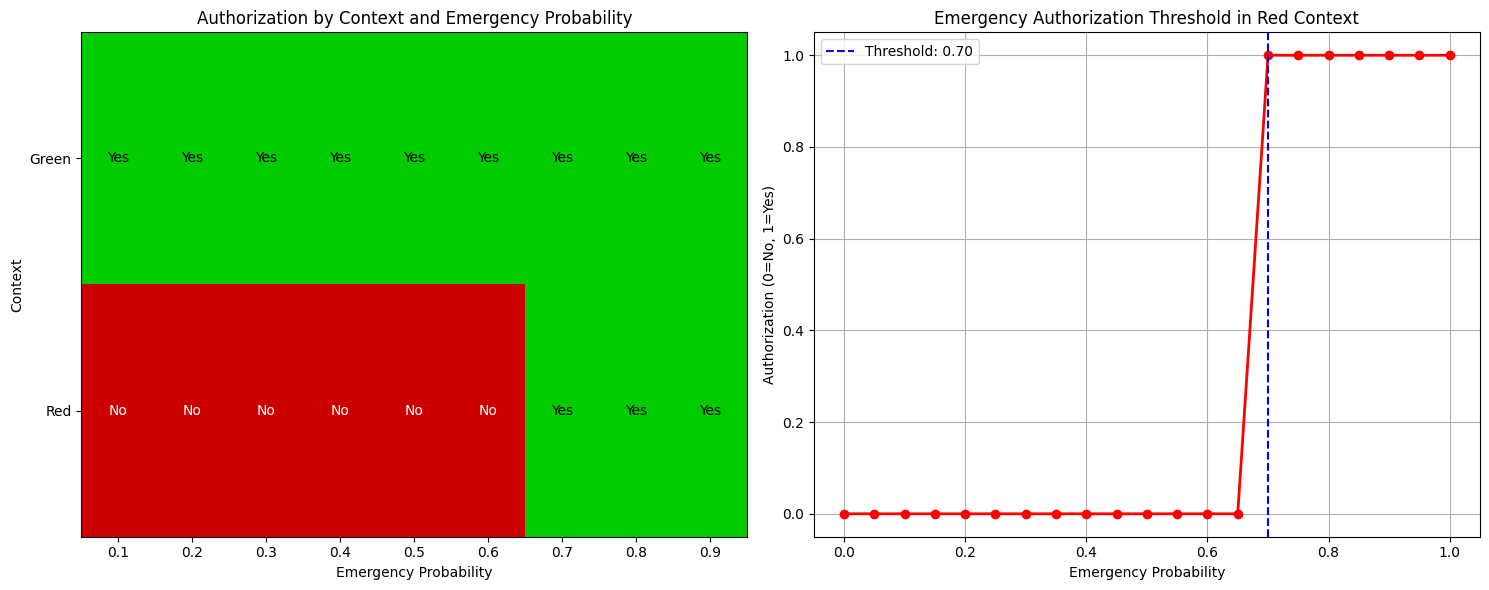

ok

----------------------------------------------------------------------
Ran 6 tests in 0.968s

OK


In [22]:
import unittest
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display

# Import your PyMDPDroneAuthorization class
# from pymdp_drone_agent import PyMDPDroneAuthorization

class TestPyMDPDroneAuthorization(unittest.TestCase):
    """Test cases for the PyMDPDroneAuthorization class"""

    @classmethod
    def setUpClass(cls):
        cls.test_results = {}

    def setUp(self):
        self.model = PyMDPDroneAuthorization(enable_logging=False)

    def test_initialization(self):
        """Test that the model initializes correctly"""
        self.assertIsNotNone(self.model.A)  # Should have likelihood matrices
        self.assertIsNotNone(self.model.B)  # Should have transition matrices
        self.assertIsNotNone(self.model.C)  # Should have preference vectors
        self.assertIsNotNone(self.model.D)  # Should have prior belief vectors

        # Check dimensions
        self.assertEqual(self.model.num_position_states, 9)
        self.assertEqual(self.model.num_context_states, 2)
        self.assertEqual(self.model.num_condition_states, 2)

        # Check if PyMDP agent was created
        self.assertIsNotNone(self.model.agent)

    def test_authorization_logic(self):
        """Test the authorization logic for different contexts and conditions"""
        # Create a dictionary to store results for different scenarios
        auth_results = {}

        # Use custom run_inference method for testing with explicit context
        def run_inference_with_context(model, context_idx, condition_prior=None):
            # Set condition prior if provided
            if condition_prior is not None:
                model.agent.D[2] = np.array(condition_prior)

            # Run inference with provided context index and position index 0
            return model.run_inference(0, context_idx)

        # Test scenarios
        scenarios = [
            {"name": "Green/Normal", "context": 0, "condition": [0.9, 0.1], "expected": True},
            {"name": "Red/Normal", "context": 1, "condition": [0.9, 0.1], "expected": False},
            {"name": "Red/Low-Emergency", "context": 1, "condition": [0.6, 0.4], "expected": False},
            {"name": "Red/High-Emergency", "context": 1, "condition": [0.2, 0.8], "expected": True}
        ]

        for scenario in scenarios:
            result = run_inference_with_context(
                self.model,
                scenario["context"],
                scenario["condition"]
            )

            auth_results[scenario["name"]] = {
                'authorized': result['authorized'],
                'context_belief': result['context_belief'],
                'condition_belief': result['condition_belief']
            }

            # Assert expected authorization
            self.assertEqual(
                result['authorized'],
                scenario["expected"],
                f"Failed authorization test for {scenario['name']}"
            )

        # Store results
        self.test_results['auth_logic'] = auth_results

    def test_set_condition(self):
        """Test that set_condition properly updates the condition prior"""
        # Initial condition prior
        initial_condition = self.model.agent.D[2].copy()

        # Set a new condition
        new_condition = [0.2, 0.8]  # Emergency condition
        self.model.set_condition(new_condition)

        # Verify it was updated
        np.testing.assert_array_almost_equal(
            self.model.agent.D[2],
            np.array(new_condition),
            err_msg="Failed to update condition prior"
        )

        # Test with invalid input
        with self.assertRaises(ValueError):
            self.model.set_condition([0.5])  # Too few elements

        # Restore original condition
        self.model.agent.D[2] = initial_condition

    def test_is_authorized(self):
        """Test the is_authorized convenience method"""
        # Green context should be authorized
        authorized, context, condition = self.model.is_authorized(0, 0)
        self.assertTrue(authorized, "Green context should be authorized")
        self.assertEqual(context, "Green", "Context should be Green")

        # Red context with normal condition should not be authorized
        self.model.set_condition([0.9, 0.1])  # Normal condition
        authorized, context, condition = self.model.is_authorized(0, 1)
        self.assertFalse(authorized, "Red context with normal condition should not be authorized")
        self.assertEqual(context, "Red", "Context should be Red")
        self.assertEqual(condition, "Normal", "Condition should be Normal")

        # Red context with high emergency should be authorized
        self.model.set_condition([0.2, 0.8])  # Emergency condition
        authorized, context, condition = self.model.is_authorized(0, 1)
        self.assertTrue(authorized, "Red context with high emergency should be authorized")
        self.assertEqual(context, "Red", "Context should be Red")
        self.assertEqual(condition, "Emergency", "Condition should be Emergency")

    def test_state_inference_and_authorization(self):
        """
        Test if the agent correctly infers context and condition states,
        and if these lead to the expected authorization decisions.
        """
        # Define test scenarios with different ground truth states
        test_scenarios = [
            {
                "name": "Green/Normal",
                "context_idx": 0,  # Green
                "condition_prior": [0.9, 0.1],  # Normal
                "expected_context": "Green",
                "expected_condition": "Normal",
                "expected_authorization": True
            },
            {
                "name": "Green/Emergency",
                "context_idx": 0,  # Green
                "condition_prior": [0.2, 0.8],  # Emergency
                "expected_context": "Green",
                "expected_condition": "Emergency",
                "expected_authorization": True
            },
            {
                "name": "Red/Normal",
                "context_idx": 1,  # Red
                "condition_prior": [0.9, 0.1],  # Normal
                "expected_context": "Red",
                "expected_condition": "Normal",
                "expected_authorization": False
            },
            {
                "name": "Red/Low-Emergency",
                "context_idx": 1,  # Red
                "condition_prior": [0.4, 0.6],  # Low emergency
                "expected_context": "Red",
                "expected_condition": "Emergency",
                "expected_authorization": False
            },
            {
                "name": "Red/High-Emergency",
                "context_idx": 1,  # Red
                "condition_prior": [0.2, 0.8],  # High emergency
                "expected_context": "Red",
                "expected_condition": "Emergency",
                "expected_authorization": True
            }
        ]

        # Test each scenario
        results = []
        for scenario in test_scenarios:
            # Set the condition prior
            self.model.set_condition(scenario["condition_prior"])

            # Run inference with the provided context
            result = self.model.run_inference(0, scenario["context_idx"])

            # Extract inferred states and authorization
            inferred_context = result["context_label"]
            inferred_condition = result["condition_label"]
            inferred_authorization = result["authorized"]

            # Check if inferences match expectations
            context_match = inferred_context == scenario["expected_context"]
            condition_match = inferred_condition == scenario["expected_condition"]
            auth_match = inferred_authorization == scenario["expected_authorization"]

            # Store results
            results.append({
                "scenario": scenario["name"],
                "context_prior": scenario["context_idx"],
                "condition_prior": scenario["condition_prior"],
                "inferred_context": inferred_context,
                "inferred_condition": inferred_condition,
                "inferred_authorization": inferred_authorization,
                "context_match": context_match,
                "condition_match": condition_match,
                "auth_match": auth_match,
                "all_correct": context_match and condition_match and auth_match
            })

            # Assert that inferences match expectations
            self.assertEqual(inferred_context, scenario["expected_context"],
                           f"Failed to correctly infer context in {scenario['name']} scenario")
            self.assertEqual(inferred_condition, scenario["expected_condition"],
                           f"Failed to correctly infer condition in {scenario['name']} scenario")
            self.assertEqual(inferred_authorization, scenario["expected_authorization"],
                           f"Failed to correctly determine authorization in {scenario['name']} scenario")

        # Create a summary table of results
        print("\n=== State Inference and Authorization Test Results ===")
        print(f"{'Scenario':<20} | {'Context':<10} | {'Condition':<12} | {'Auth':<5} | {'Match':<5}")
        print("-" * 60)

        all_correct = True
        for r in results:
            match_symbol = "✓" if r["all_correct"] else "✗"
            print(f"{r['scenario']:<20} | {r['inferred_context']:<10} | {r['inferred_condition']:<12} | {str(r['inferred_authorization']):<5} | {match_symbol:<5}")
            all_correct = all_correct and r["all_correct"]

        # Store test results
        self.test_results["state_inference"] = results

        # Return overall success
        return all_correct

    def test_z_visualization(self):
        """Generate visualizations of PyMDP inference and authorization"""
        # Only run in IPython/Jupyter environment
        try:
            from IPython import get_ipython
            if get_ipython() is None:
                self.skipTest("Skipping visualization test outside of IPython environment")
        except ImportError:
            self.skipTest("Skipping visualization test outside of IPython environment")

        # Create figure for visualizing authorization matrix
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # 1. Context-Condition Authorization Matrix
        ax1 = axes[0]

        # Create data for the heatmap
        emergency_probs = np.linspace(0.1, 0.9, 9)
        context_types = ["Green", "Red"]

        auth_matrix = np.zeros((len(context_types), len(emergency_probs)))

        for i, context in enumerate(context_types):
            context_idx = 0 if context == "Green" else 1

            for j, e_prob in enumerate(emergency_probs):
                # Set condition prior
                self.model.set_condition([1-e_prob, e_prob])

                # Run inference
                result = self.model.run_inference(0, context_idx)

                # Store authorization result
                auth_matrix[i, j] = 1 if result["authorized"] else 0

        # Create heatmap
        cmap = LinearSegmentedColormap.from_list('AuthCmap', [(0.8, 0, 0), (0, 0.8, 0)])
        im = ax1.imshow(auth_matrix, cmap=cmap, aspect='auto')

        # Add labels
        ax1.set_xticks(np.arange(len(emergency_probs)))
        ax1.set_yticks(np.arange(len(context_types)))

        # Format labels
        ax1.set_xticklabels([f"{e:.1f}" for e in emergency_probs])
        ax1.set_yticklabels(context_types)

        # Add title and axis labels
        ax1.set_title("Authorization by Context and Emergency Probability")
        ax1.set_xlabel("Emergency Probability")
        ax1.set_ylabel("Context")

        # Add authorization key
        for i in range(len(context_types)):
            for j in range(len(emergency_probs)):
                text = "Yes" if auth_matrix[i, j] else "No"
                ax1.text(j, i, text, ha="center", va="center",
                        color="white" if not auth_matrix[i, j] else "black")

        # 2. Emergency Threshold Graph
        ax2 = axes[1]

        # Create data for the line chart
        emergency_probs = np.linspace(0, 1, 21)
        auth_results = []

        # Use Red context
        context_idx = 1

        for e_prob in emergency_probs:
            # Set condition prior
            self.model.set_condition([1-e_prob, e_prob])

            # Run inference
            result = self.model.run_inference(0, context_idx)

            # Store authorization result
            auth_results.append(1 if result["authorized"] else 0)

        # Plot results
        ax2.plot(emergency_probs, auth_results, 'ro-', linewidth=2)

        # Add labels and title
        ax2.set_xlabel("Emergency Probability")
        ax2.set_ylabel("Authorization (0=No, 1=Yes)")
        ax2.set_title("Emergency Authorization Threshold in Red Context")
        ax2.grid(True)

        # Find threshold
        threshold_idx = next((i for i, a in enumerate(auth_results) if a), None)
        if threshold_idx is not None:
            threshold = emergency_probs[threshold_idx]
            ax2.axvline(x=threshold, color='blue', linestyle='--',
                       label=f'Threshold: {threshold:.2f}')
            ax2.legend()

        # Display the figure
        plt.tight_layout()
        display(fig)
        plt.close(fig)

        return True


# Example of running all tests with unittest
def run_all_tests():
    suite = unittest.TestLoader().loadTestsFromTestCase(TestPyMDPDroneAuthorization)
    unittest.TextTestRunner(verbosity=2).run(suite)

# Manual test for a specific scenario
def manual_test():
    model = PyMDPDroneAuthorization()

    # Test with explicit Red context and Emergency condition
    print("\nTesting Red context with Emergency:")

    # Set Emergency condition prior
    model.set_condition([0.2, 0.8])  # High emergency probability

    # Run inference with Red context
    result = model.run_inference(0, 1)  # position_idx=0, context_idx=1 (Red)

    # Extract beliefs
    context_belief = result['context_belief']
    condition_belief = result['condition_belief']

    print(f"Context belief: Green={context_belief[0]:.2f}, Red={context_belief[1]:.2f}")
    print(f"Condition belief: Normal={condition_belief[0]:.2f}, Emergency={condition_belief[1]:.2f}")
    print(f"Authorization: {'YES' if result['authorized'] else 'NO'}")
    print(f"Reason: {result['authorization_reasons'][0]}")

# Choose which tests to run
if __name__ == "__main__":
    print("=== PyMDPDroneAuthorization Test Suite ===")

    # Run all tests
    run_all_tests()

TEST unit test END HERE

## ######################################## SIMULATION LOOP **############################################**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import random
from IPython.display import clear_output

# Import core components - uncomment and modify paths as needed
# from drone_model import DroneModel, PIDController, DroneController
# from pymdp_drone_agent import PyMDPDroneAuthorization

class SimulationExperiment:
    """
    Run comprehensive drone simulation experiments with multiple waypoints
    having different contexts (Green/Red) and conditions (Normal/Emergency).
    """
    def __init__(self,
                 n_waypoints=10,
                 waypoint_spacing=2.0,
                 random_seed=42,
                 visualization_frequency=1):
        """
        Initialize the simulation experiment.

        Parameters:
        - n_waypoints: Number of waypoints to generate
        - waypoint_spacing: Average spacing between waypoints
        - random_seed: Seed for random number generation
        - visualization_frequency: How often to update the visualization
        """
        # Set random seed for reproducibility
        np.random.seed(random_seed)
        random.seed(random_seed)

        self.n_waypoints = n_waypoints
        self.waypoint_spacing = waypoint_spacing
        self.visualization_frequency = visualization_frequency

        # Initialize drone and controllers
        self.drone = DroneModel()
        self.controller = DroneController(self.drone)
        self.auth_agent = PyMDPDroneAuthorization()

        # Generate waypoints
        self.waypoints = self._generate_waypoints()

        # Performance metrics
        self.metrics = {
            'total_time': 0,
            'distance_traveled': 0,
            'authorized_waypoints': 0,
            'unauthorized_waypoints': 0,
            'time_at_waypoints': [],
            'time_between_waypoints': [],
            'authorization_history': []
        }

        # Visualization
        self.fig = None
        self.axes = None

    def _generate_waypoints(self):
        """Generate a diverse set of waypoints with different contexts and conditions"""
        waypoints = []

        # Starting point at origin
        current_pos = np.array([0.0, 0.0, 1.0])

        # Context and condition distributions
        # We want a mix of Red/Green contexts and Normal/Emergency conditions
        contexts = [0, 1]  # 0=Green, 1=Red
        context_probs = [0.6, 0.4]  # 60% Green, 40% Red

        # We'll create four condition types
        # 1. Strongly Normal: [0.9, 0.1]
        # 2. Weakly Normal: [0.6, 0.4]
        # 3. Weakly Emergency: [0.4, 0.6]
        # 4. Strongly Emergency: [0.1, 0.9]
        condition_templates = [
            [0.9, 0.1],
            [0.6, 0.4],
            [0.4, 0.6],
            [0.1, 0.9]
        ]
        condition_probs = [0.4, 0.2, 0.2, 0.2]  # 40% strongly normal

        for i in range(self.n_waypoints):
            # Generate a new position with some randomness
            direction = np.random.rand(3) * 2 - 1  # Random direction
            direction = direction / np.linalg.norm(direction)  # Normalize
            distance = self.waypoint_spacing * (0.8 + 0.4 * np.random.rand())  # Random distance
            new_pos = current_pos + direction * distance

            # Ensure z is always positive (above ground)
            new_pos[2] = max(0.5, new_pos[2])

            # Choose context
            context = np.random.choice(contexts, p=context_probs)

            # Choose condition
            condition_idx = np.random.choice(range(len(condition_templates)), p=condition_probs)
            condition = condition_templates[condition_idx]

            # Create waypoint
            waypoint = {
                'position': new_pos,
                'context': context,
                'context_label': 'Green' if context == 0 else 'Red',
                'condition': condition,
                'condition_label': 'Normal' if condition[0] > condition[1] else 'Emergency',
                'index': i
            }

            waypoints.append(waypoint)
            current_pos = new_pos

        return waypoints

    def run(self, max_time_per_waypoint=10.0, unauthorized_wait_time=1.0):
        """
        Run the simulation through all waypoints.

        Parameters:
        - max_time_per_waypoint: Maximum time (seconds) to spend at each waypoint
        - unauthorized_wait_time: Time to wait at unauthorized waypoints before moving on
        """
        # Start at origin
        self.drone.position = np.array([0.0, 0.0, 0.0])

        # Reset performance metrics
        self.metrics = {
            'total_time': 0,
            'distance_traveled': 0,
            'authorized_waypoints': 0,
            'unauthorized_waypoints': 0,
            'time_at_waypoints': [],
            'time_between_waypoints': [],
            'authorization_history': [],
            'transitions': []
        }

        # Initialize visualization
        self._setup_visualization()

        # Simulation parameters
        dt = self.drone.dt
        max_steps_per_waypoint = int(max_time_per_waypoint / dt)
        unauth_steps = int(unauthorized_wait_time / dt)

        # History trackers
        position_history = [self.drone.position.copy()]
        context_history = []
        condition_history = []
        auth_history = []

        # Run simulation for each waypoint
        total_steps = 0
        last_viz_step = 0
        waypoint_start_time = time.time()

        for waypoint_idx, waypoint in enumerate(self.waypoints):
            print(f"\nNavigating to waypoint {waypoint_idx+1}/{len(self.waypoints)}")
            print(f"Position: {waypoint['position']}")
            print(f"Context: {waypoint['context_label']}, Condition: {waypoint['condition_label']}")

            # Set target position
            target_position = waypoint['position']
            self.controller.set_target(target_position)

            # Set condition in the authorization agent
            self.auth_agent.set_condition(waypoint['condition'])

            # Get initial authorization decision
            authorized, context, condition = self.auth_agent.is_authorized(waypoint_idx, waypoint['context'])
            print(f"Initial authorization: {authorized}")

            # Track authorization status
            if authorized:
                self.metrics['authorized_waypoints'] += 1
            else:
                self.metrics['unauthorized_waypoints'] += 1

            self.metrics['authorization_history'].append(authorized)

            # Keep track of previous position for distance calculation
            prev_position = self.drone.position.copy()

            # Waypoint navigation loop
            steps_at_waypoint = 0
            waypoint_reached = False
            waypoint_complete = False
            prev_auth = authorized

            while not waypoint_complete and steps_at_waypoint < max_steps_per_waypoint:
                # Calculate control inputs
                motor_speeds = self.controller.update()

                # Update drone state with authorization status
                self.drone.update(motor_speeds, authorized=authorized)

                # Update metrics
                total_steps += 1
                steps_at_waypoint += 1

                # Calculate distance moved in this step
                distance_step = np.linalg.norm(self.drone.position - prev_position)
                self.metrics['distance_traveled'] += distance_step
                prev_position = self.drone.position.copy()

                # Store history
                position_history.append(self.drone.position.copy())
                context_history.append(context)
                condition_history.append(condition)
                auth_history.append(authorized)

                # Check if waypoint is reached (close enough to target)
                distance_to_target = np.linalg.norm(self.drone.position - target_position)
                if not waypoint_reached and distance_to_target < 0.3:  # Threshold for "reaching" a waypoint
                    waypoint_reached = True
                    waypoint_time = time.time() - waypoint_start_time
                    self.metrics['time_at_waypoints'].append(waypoint_time)
                    print(f"Waypoint reached in {waypoint_time:.2f} seconds")

                # Check authorization status periodically
                if steps_at_waypoint % 10 == 0:
                    new_auth, new_context, new_condition = self.auth_agent.is_authorized(
                        waypoint_idx, waypoint['context']
                    )

                    # If authorization status changed, record the transition
                    if new_auth != prev_auth:
                        self.metrics['transitions'].append({
                            'step': total_steps,
                            'waypoint': waypoint_idx,
                            'from_status': prev_auth,
                            'to_status': new_auth,
                            'context': new_context,
                            'condition': new_condition
                        })

                        print(f"Authorization changed at step {steps_at_waypoint}: {prev_auth} -> {new_auth}")
                        print(f"Context: {new_context}, Condition: {new_condition}")

                    authorized = new_auth
                    context = new_context
                    condition = new_condition
                    prev_auth = new_auth

                # Determine if we're done with this waypoint
                if waypoint_reached:
                    # If authorized, stay a bit longer at the waypoint
                    if authorized and steps_at_waypoint > max_steps_per_waypoint // 2:
                        waypoint_complete = True
                    # If unauthorized, wait the minimum time then move on
                    elif not authorized and steps_at_waypoint > unauth_steps:
                        waypoint_complete = True

                # Update visualization periodically
                if total_steps - last_viz_step >= self.visualization_frequency:
                    self._update_visualization(
                        position_history,
                        target_position,
                        waypoint,
                        auth_history,
                        context_history,
                        condition_history
                    )
                    last_viz_step = total_steps

            # Record time between waypoints if not the first waypoint
            if waypoint_idx > 0:
                waypoint_interval = time.time() - waypoint_start_time
                self.metrics['time_between_waypoints'].append(waypoint_interval)

            # Record time at waypoint
            waypoint_start_time = time.time()

            # End simulation if we can't reach a waypoint
            if not waypoint_reached:
                print(f"Warning: Could not reach waypoint {waypoint_idx+1}")

        # Final update to visualization
        self._update_visualization(
            position_history,
            self.waypoints[-1]['position'],
            self.waypoints[-1],
            auth_history,
            context_history,
            condition_history,
            final=True
        )

        # Calculate total time
        self.metrics['total_time'] = sum(self.metrics['time_at_waypoints'])

        # Print summary
        self._print_summary()

        # Return complete trajectory data
        return {
            'positions': np.array(position_history),
            'auth_history': auth_history,
            'context_history': context_history,
            'condition_history': condition_history,
            'waypoints': self.waypoints,
            'metrics': self.metrics
        }

    def _setup_visualization(self):
        """Initialize the visualization figure and axes"""
        self.fig = plt.figure(figsize=(12, 10))
        self.axes = {
            'trajectory': self.fig.add_subplot(2, 2, 1, projection='3d'),
            'authorization': self.fig.add_subplot(2, 2, 2),
            'metrics': self.fig.add_subplot(2, 2, 3),
            'waypoints': self.fig.add_subplot(2, 2, 4)
        }

        # Set titles
        self.axes['trajectory'].set_title('Drone Trajectory')
        self.axes['authorization'].set_title('Authorization Status')
        self.axes['metrics'].set_title('Performance Metrics')
        self.axes['waypoints'].set_title('Waypoint Information')

        # Set labels
        self.axes['trajectory'].set_xlabel('X (m)')
        self.axes['trajectory'].set_ylabel('Y (m)')
        self.axes['trajectory'].set_zlabel('Z (m)')
        self.axes['authorization'].set_xlabel('Step')
        self.axes['authorization'].set_ylabel('Status')

        plt.tight_layout()

    def _update_visualization(self, position_history, target_position, current_waypoint,
                             auth_history, context_history, condition_history, final=False):
        """Update the visualization with current simulation state"""
        # Clear axes
        for ax in self.axes.values():
            ax.clear()

        # Set titles again (they get cleared)
        self.axes['trajectory'].set_title('Drone Trajectory')
        self.axes['authorization'].set_title('Authorization Status')
        self.axes['metrics'].set_title('Performance Metrics')
        self.axes['waypoints'].set_title('Waypoint Information')

        # Update trajectory plot
        positions = np.array(position_history)

        # Plot the trajectory
        self.axes['trajectory'].plot(
            positions[:, 0],
            positions[:, 1],
            positions[:, 2],
            'b-', linewidth=1, alpha=0.7
        )

        # Plot the current drone position
        drone_pos = positions[-1]
        self.axes['trajectory'].scatter(
            [drone_pos[0]],
            [drone_pos[1]],
            [drone_pos[2]],
            c='blue', marker='o', s=100, label='Drone'
        )

        # Plot all waypoints
        for wp in self.waypoints:
            wp_pos = wp['position']
            color = 'green' if wp['context'] == 0 else 'red'
            marker = 'o' if wp['condition'][0] > wp['condition'][1] else '^'

            self.axes['trajectory'].scatter(
                [wp_pos[0]],
                [wp_pos[1]],
                [wp_pos[2]],
                c=color, marker=marker, s=50,
                label=f"{wp['context_label']}/{wp['condition_label']}" if wp['index'] == 0 else ""
            )

        # Plot the current target
        self.axes['trajectory'].scatter(
            [target_position[0]],
            [target_position[1]],
            [target_position[2]],
            c='purple', marker='*', s=150, label='Current Target'
        )

        # Update authorization plot
        auth_values = [1 if a else 0 for a in auth_history]
        self.axes['authorization'].plot(
            range(len(auth_values)),
            auth_values,
            'g-', linewidth=2,
            drawstyle='steps-post'
        )
        self.axes['authorization'].set_ylim(-0.1, 1.1)
        self.axes['authorization'].set_yticks([0, 1])
        self.axes['authorization'].set_yticklabels(['Unauthorized', 'Authorized'])
        self.axes['authorization'].grid(True)

        # Shade the authorization background based on context
        for i, (ctx, cond) in enumerate(zip(context_history, condition_history)):
            if ctx == 'Red':
                if cond == 'Normal':
                    color = 'salmon'
                else:
                    color = 'lightsalmon'
            else:
                if cond == 'Normal':
                    color = 'lightgreen'
                else:
                    color = 'palegreen'

            self.axes['authorization'].axvspan(i, i+1, alpha=0.3, color=color)

        # Update metrics plot
        # Create a bar chart of key metrics
        metrics_to_show = {
            'Authorized': self.metrics['authorized_waypoints'],
            'Unauthorized': self.metrics['unauthorized_waypoints'],
            'Distance (m)': self.metrics['distance_traveled'],
        }

        x_pos = range(len(metrics_to_show))
        values = list(metrics_to_show.values())

        self.axes['metrics'].bar(
            x_pos,
            values,
            align='center',
            alpha=0.7,
            color=['green', 'red', 'blue']
        )
        self.axes['metrics'].set_xticks(x_pos)
        self.axes['metrics'].set_xticklabels(list(metrics_to_show.keys()))

        # Update waypoints information
        wp_labels = [f"WP{i+1}: {wp['context_label']}/{wp['condition_label']}" for i, wp in enumerate(self.waypoints)]
        auth_status = ["✓" if a else "✗" for a in self.metrics['authorization_history']]

        # Make sure lists are the same length
        min_len = min(len(wp_labels), len(auth_status))
        combined_labels = [f"{wp_labels[i]} {auth_status[i]}" for i in range(min_len)]

        self.axes['waypoints'].axis('off')
        y_pos = 0.9
        for label in combined_labels:
            color = 'green' if '✓' in label else 'red'
            self.axes['waypoints'].text(
                0.1, y_pos, label,
                transform=self.axes['waypoints'].transAxes,
                fontsize=10, color=color
            )
            y_pos -= 0.05

        # Add legend to trajectory plot
        self.axes['trajectory'].legend(loc='upper right')

        # Add title showing current waypoint info
        if not final:
            self.fig.suptitle(
                f"Waypoint {current_waypoint['index']+1}: {current_waypoint['context_label']} context, {current_waypoint['condition_label']} condition",
                fontsize=14
            )
        else:
            self.fig.suptitle("Simulation Complete", fontsize=14)

        # Set axes limits for trajectory
        all_positions = np.vstack([positions] + [wp['position'] for wp in self.waypoints])
        center = all_positions.mean(axis=0)
        max_range = np.max(all_positions.max(axis=0) - all_positions.min(axis=0)) / 2 + 1

        self.axes['trajectory'].set_xlim(center[0] - max_range, center[0] + max_range)
        self.axes['trajectory'].set_ylim(center[1] - max_range, center[1] + max_range)
        self.axes['trajectory'].set_zlim(center[2] - max_range, center[2] + max_range)

        # Update the figure
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        clear_output(wait=True)
        plt.draw()
        plt.pause(0.01)

    def _print_summary(self):
        """Print a summary of the simulation results"""
        print("\n===== Simulation Summary =====")
        print(f"Total waypoints: {self.n_waypoints}")
        print(f"Authorized waypoints: {self.metrics['authorized_waypoints']}")
        print(f"Unauthorized waypoints: {self.metrics['unauthorized_waypoints']}")
        print(f"Total distance traveled: {self.metrics['distance_traveled']:.2f} m")

        if self.metrics['time_at_waypoints']:
            avg_time = sum(self.metrics['time_at_waypoints']) / len(self.metrics['time_at_waypoints'])
            print(f"Average time at waypoints: {avg_time:.2f} s")

        if self.metrics['transitions']:
            print("\nAuthorization transitions:")
            for t in self.metrics['transitions']:
                status_change = "Authorized → Unauthorized" if t['from_status'] else "Unauthorized → Authorized"
                print(f"  Step {t['step']}, Waypoint {t['waypoint']+1}: {status_change}")
                print(f"  Context: {t['context']}, Condition: {t['condition']}")

        print("==============================")


# Example usage
if __name__ == "__main__":
    # Create and run the experiment
    experiment = SimulationExperiment(
        n_waypoints=8,
        waypoint_spacing=3.0,
        visualization_frequency=10
    )

    # Run the simulation
    results = experiment.run(
        max_time_per_waypoint=15.0,
        unauthorized_wait_time=2.0
    )

    # Keep the final plot visible
    plt.show()

<Figure size 640x480 with 0 Axes>


--- PyMDP Active Inference Decision ---
Context: Green (Prob: 1.00/0.00)
Condition: Normal (Prob: 0.90/0.10)
Authorization: AUTHORIZED
Reasons: Green context always authorized (Green prob: 1.00)
--------------------------------------------------


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def analyze_simulation_results(results):
    """
    Analyze and visualize the results from a drone simulation experiment.

    Parameters:
    - results: Dictionary containing simulation results
    """
    # Extract data
    positions = results['positions']
    auth_history = np.array(results['auth_history'])
    context_history = np.array(results['context_history'])
    condition_history = np.array(results['condition_history'])
    waypoints = results['waypoints']
    metrics = results['metrics']

    # Create a comprehensive visualization
    fig = plt.figure(figsize=(18, 14))

    # 1. 3D Trajectory Visualization
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    plot_3d_trajectory(ax1, positions, auth_history, waypoints)

    # 2. Authorization Status Timeline
    ax2 = fig.add_subplot(2, 2, 2)
    plot_authorization_timeline(ax2, auth_history, context_history, condition_history)

    # 3. Context-Condition Distribution
    ax3 = fig.add_subplot(2, 3, 4)
    plot_context_condition_distribution(ax3, waypoints)

    # 4. Authorization Success Rate
    ax4 = fig.add_subplot(2, 3, 5)
    plot_authorization_success(ax4, waypoints, metrics)

    # 5. Performance Metrics
    ax5 = fig.add_subplot(2, 3, 6)
    plot_performance_metrics(ax5, metrics)

    # Add title
    plt.suptitle('Drone Simulation Experiment Analysis', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    return fig

def plot_3d_trajectory(ax, positions, auth_history, waypoints):
    """Plot the 3D trajectory with color-coded authorization status"""
    # Set labels
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('3D Flight Trajectory')

    # Plot waypoints
    for wp in waypoints:
        pos = wp['position']
        color = 'green' if wp['context'] == 0 else 'red'
        marker = 'o' if wp['condition'][0] > wp['condition'][1] else '^'
        label = f"{wp['context_label']}/{wp['condition_label']}" if wp['index'] == 0 else None

        ax.scatter(
            pos[0], pos[1], pos[2],
            c=color, marker=marker, s=80, alpha=0.8, label=label
        )

        # Add waypoint number text
        ax.text(pos[0], pos[1], pos[2], f" {wp['index']+1}", fontsize=9)

    # Plot trajectory segments with color based on authorization
    for i in range(1, len(positions)):
        color = 'green' if auth_history[i] else 'red'
        ax.plot(
            positions[i-1:i+1, 0],
            positions[i-1:i+1, 1],
            positions[i-1:i+1, 2],
            color=color, linewidth=1, alpha=0.7
        )

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=2, label='Authorized'),
        plt.Line2D([0], [0], color='red', lw=2, label='Unauthorized'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green',
                  markersize=8, label='Green/Normal'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green',
                  markersize=8, label='Green/Emergency'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                  markersize=8, label='Red/Normal'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='red',
                  markersize=8, label='Red/Emergency')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

def plot_authorization_timeline(ax, auth_history, context_history, condition_history):
    """Plot the authorization status over time with context/condition information"""
    # Create a numeric authorization status
    auth_values = np.array([1 if a else 0 for a in auth_history])

    # Plot the authorization timeline
    ax.plot(auth_values, 'k-', linewidth=2, drawstyle='steps-post')

    # Set axes properties
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Authorization Status')
    ax.set_title('Authorization Timeline')
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Unauthorized', 'Authorized'])
    ax.grid(True, alpha=0.3)

    # Create background colors based on context and condition
    unique_contexts = np.unique(context_history)
    unique_conditions = np.unique(condition_history)

    # Create a colormap for the context-condition combinations
    n_combinations = len(unique_contexts) * len(unique_conditions)
    cmap = plt.cm.get_cmap('Pastel1', n_combinations)

    # Add colored regions for context-condition combinations
    current_context = context_history[0]
    current_condition = condition_history[0]
    start_idx = 0

    for i in range(1, len(context_history)):
        if context_history[i] != current_context or condition_history[i] != current_condition:
            # Determine color based on context and condition
            context_idx = np.where(unique_contexts == current_context)[0][0]
            condition_idx = np.where(unique_conditions == current_condition)[0][0]
            color_idx = context_idx * len(unique_conditions) + condition_idx

            # Shade the region
            color = cmap(color_idx)
            ax.axvspan(start_idx, i, alpha=0.3, color=color)

            # Add text annotation
            mid_point = (start_idx + i) // 2
            ax.text(mid_point, 0.5, f"{current_context}/{current_condition}",
                   ha='center', va='center', fontsize=8,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

            # Update for next region
            current_context = context_history[i]
            current_condition = condition_history[i]
            start_idx = i

    # Add the last region
    context_idx = np.where(unique_contexts == current_context)[0][0]
    condition_idx = np.where(unique_conditions == current_condition)[0][0]
    color_idx = context_idx * len(unique_conditions) + condition_idx
    color = cmap(color_idx)
    ax.axvspan(start_idx, len(context_history), alpha=0.3, color=color)

    # Add text annotation for the last region
    mid_point = (start_idx + len(context_history)) // 2
    ax.text(mid_point, 0.5, f"{current_context}/{current_condition}",
           ha='center', va='center', fontsize=8,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

def plot_context_condition_distribution(ax, waypoints):
    """Plot the distribution of context-condition combinations across waypoints"""
    # Extract context and condition information
    contexts = [wp['context_label'] for wp in waypoints]
    conditions = [wp['condition_label'] for wp in waypoints]

    # Create a crosstab of context-condition combinations
    data = pd.DataFrame({'Context': contexts, 'Condition': conditions})
    crosstab = pd.crosstab(data['Context'], data['Condition'], normalize=False)

    # Create a heatmap
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

    # Set labels and title
    ax.set_title('Context-Condition Distribution')

    # Adjust font size for better readability
    for text in ax.texts:
        text.set_fontsize(12)

def plot_authorization_success(ax, waypoints, metrics):
    """Plot the authorization success rate by context-condition combination"""
    # Extract data
    contexts = [wp['context_label'] for wp in waypoints]
    conditions = [wp['condition_label'] for wp in waypoints]
    auth_status = metrics['authorization_history']

    # Create a DataFrame with the data
    data = pd.DataFrame({
        'Context': contexts,
        'Condition': conditions,
        'Authorized': auth_status
    })

    # Calculate success rate for each context-condition combination
    success_rates = data.groupby(['Context', 'Condition'])['Authorized'].mean().reset_index()
    success_rates['Success Rate'] = success_rates['Authorized'] * 100

    # Pivot the data for the heatmap
    pivot_data = success_rates.pivot(index='Context', columns='Condition', values='Success Rate')

    # Create a heatmap
    cmap = LinearSegmentedColormap.from_list('auth_cmap', ['red', 'yellow', 'green'])
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap=cmap, vmin=0, vmax=100, cbar_kws={'label': '%'}, ax=ax)

    # Set title
    ax.set_title('Authorization Success Rate (%)')

    # Adjust font size for better readability
    for text in ax.texts:
        text.set_fontsize(12)

def plot_performance_metrics(ax, metrics):
    """Plot key performance metrics from the simulation"""
    # Metrics to display
    metrics_to_plot = {
        'Total Distance (m)': metrics['distance_traveled'],
        'Authorized Points': metrics['authorized_waypoints'],
        'Unauthorized Points': metrics['unauthorized_waypoints']
    }

    # Create bar chart
    x_pos = range(len(metrics_to_plot))
    values = list(metrics_to_plot.values())
    colors = ['blue', 'green', 'red']

    bars = ax.bar(x_pos, values, align='center', alpha=0.7, color=colors)

    # Add value labels on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{values[i]:.1f}', ha='center', va='bottom')

    # Set labels and title
    ax.set_xticks(x_pos)
    ax.set_xticklabels(list(metrics_to_plot.keys()), rotation=15)
    ax.set_title('Performance Metrics')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Adjust y-axis limit
    ax.set_ylim(0, max(values) * 1.15)

def generate_simulation_report(results):
    """Generate a comprehensive report of the simulation results"""
    # Get metrics and waypoint information
    metrics = results['metrics']
    waypoints = results['waypoints']

    # Calculate additional statistics
    context_counts = {}
    condition_counts = {}
    success_by_combo = {}

    for i, wp in enumerate(waypoints):
        context = wp['context_label']
        condition = wp['condition_label']
        authorized = metrics['authorization_history'][i]

        # Track context counts
        context_counts[context] = context_counts.get(context, 0) + 1

        # Track condition counts
        condition_counts[condition] = condition_counts.get(condition, 0) + 1

        # Track success by combination
        combo = f"{context}/{condition}"
        if combo not in success_by_combo:
            success_by_combo[combo] = {'total': 0, 'authorized': 0}
        success_by_combo[combo]['total'] += 1
        if authorized:
            success_by_combo[combo]['authorized'] += 1

    # Create report text
    report = []
    report.append("# Drone Simulation Experiment Report\n")

    # Summary section
    report.append("## Summary")
    report.append(f"- Total waypoints: {len(waypoints)}")
    report.append(f"- Distance traveled: {metrics['distance_traveled']:.2f} meters")
    report.append(f"- Authorized waypoints: {metrics['authorized_waypoints']} ({metrics['authorized_waypoints']/len(waypoints)*100:.1f}%)")
    report.append(f"- Unauthorized waypoints: {metrics['unauthorized_waypoints']} ({metrics['unauthorized_waypoints']/len(waypoints)*100:.1f}%)")

    # Context distribution
    report.append("\n## Context Distribution")
    for context, count in context_counts.items():
        report.append(f"- {context}: {count} waypoints ({count/len(waypoints)*100:.1f}%)")

    # Condition distribution
    report.append("\n## Condition Distribution")
    for condition, count in condition_counts.items():
        report.append(f"- {condition}: {count} waypoints ({count/len(waypoints)*100:.1f}%)")

    # Authorization success by combination
    report.append("\n## Authorization Success by Combination")
    for combo, stats in success_by_combo.items():
        success_rate = stats['authorized'] / stats['total'] * 100
        report.append(f"- {combo}: {stats['authorized']}/{stats['total']} ({success_rate:.1f}%)")

    # Authorization transitions
    if metrics['transitions']:
        report.append("\n## Authorization Transitions")
        for t in metrics['transitions']:
            status_change = "Authorized → Unauthorized" if t['from_status'] else "Unauthorized → Authorized"
            report.append(f"- Step {t['step']}, Waypoint {t['waypoint']+1}: {status_change}")
            report.append(f"  Context: {t['context']}, Condition: {t['condition']}")

    return '\n'.join(report)

# Main function to run the analysis
def analyze_and_report(results):
    """Run full analysis and generate a report from simulation results"""
    # Create visualization
    fig = analyze_simulation_results(results)

    # Generate report
    report = generate_simulation_report(results)

    return {
        'figure': fig,
        'report': report
    }

# Example of how to use these functions
if __name__ == "__main__":
    # This would be called after running a simulation experiment
    # results = experiment.run()
    # analysis = analyze_and_report(results)

    # Display the report
    # print(analysis['report'])

    # Show the figure
    # plt.show()
    print("Analysis module loaded successfully")